In [25]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd
from classes_synsets import SYNS

In [26]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


In [27]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [28]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [29]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [30]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [31]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
text_embs.shape

torch.Size([1000, 1024])

In [33]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [34]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [35]:
many_labels = []
many_embs = []
many_inds = []
med_labels = []
med_embs = []
med_inds = []
few_labels = []
few_embs = []
few_inds = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
        many_inds.append(i)
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
        med_inds.append(i)
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        few_inds.append(i)
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

many_inds = np.array(many_inds)
med_inds = np.array(med_inds)
few_inds = np.array(few_inds)


  0%|          | 0/50000 [00:00<?, ?it/s]

In [13]:
fg_buckets = [5, 10, 15, 20, 30, 40, 60, 100, 160, 10000]

fg_indices_val = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings_val.shape[0])):
    for k in fg_buckets:
        if freqs[labels_val[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices_val[k].append(i)
print(len([i for k in fg_indices_val for i in fg_indices_val[k]]))
[len(fg_indices_val[k]) for k in fg_indices_val]

  0%|          | 0/20000 [00:00<?, ?it/s]

20000


[100, 1040, 880, 900, 1580, 1680, 2560, 3560, 3340, 4360]

In [14]:


fg_indices = {k: [] for k in fg_buckets}

seen = set()

for i in tqdm(range(image_embeddings.shape[0])):
    for k in fg_buckets:
        if freqs[labels[i].item()] <= k and i not in seen:
            seen.add(i)
            fg_indices[k].append(i)
print(len([i for k in fg_indices for i in fg_indices[k]]))
[len(fg_indices[k]) for k in fg_indices]

  0%|          | 0/50000 [00:00<?, ?it/s]

50000


[250, 2600, 2200, 2250, 3950, 4200, 6400, 8900, 8350, 10900]

In [15]:
def bucket_indices(l):
    seen = set()
    out = []
    for i in tqdm(range(len(l))):
        for k,kk in enumerate(fg_buckets):
            if freqs[l[i].item()] <= kk and i not in seen:
                seen.add(i)
                out.append(k)
    return out

In [16]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

In [17]:
def all_accs(model):
    preds = model.predict(image_embeddings)
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [18]:
def all_accs_p(preds):
    l = labels.numpy()
    avg_acc = mic_acc_cal(preds, l)
    many = mic_acc_cal(preds[many_inds], many_labels)
    med = mic_acc_cal(preds[med_inds], med_labels)
    few = mic_acc_cal(preds[few_inds], few_labels)
    print(f"{avg_acc:.3f}/{many:.3f}/{med:.3f}/{few:.3f}")
    return [avg_acc, many, med, few]

In [19]:
def all_accs_fg(preds, ls, fg_indices):
    avg_acc = mic_acc_cal(preds, ls)
    out_accs = [avg_acc]
    for k in fg_indices:
        indices = np.array(fg_indices[k])
        acc = mic_acc_cal(preds[indices], ls[indices])
        out_accs.append(acc)
    print([f"{k:.5f}" for k in out_accs])
    return out_accs

In [20]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/class_balanced/13-Sep-2022-13-41-17/final_model.sav", 'rb'))

# text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))
text_only_balanced_cupl = pickle.load(open("results_sklearn/config_text_only_clip_and_cupl_liblinear/07-Nov-2022-12-41-14/final_model.sav", 'rb'))


image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/07-Nov-2022-18-27-46/final_model.sav", 'rb'))
image_only_clf_4 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_oversampled_auto/class_balanced/07-Nov-2022-20-13-26/final_model.sav", 'rb'))
# image_only_clf_oversampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/11-Nov-2022-16-23-33/final_model.sav", 'rb'))

image_only_clf_undersampled_500 = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_0-5/12-Nov-2022-12-17-52/final_model.sav", 'rb'))
image_only_clf_undersampled = pickle.load(open("results_sklearn/config_image_linear_probe_undersampled_auto/class_balanced/07-Nov-2022-20-18-24/final_model.sav", 'rb'))

image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))
image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_nojitter/01-Dec-2022-22-31-07/final_model.sav", 'rb'))





### Predict mixing coefficients at eval time

In [21]:
from data_loader import dataloaders as dataloader

In [23]:
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset",
    prompt_set="Imagenet",
)
dataset_test = d[0]

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset
test 50000
No sampler.
Shuffle is True.


In [24]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
t1 = T.RandomResizedCrop(size=224, scale=(0.5, 1), interpolation=BICUBIC)
t2 = T.RandomHorizontalFlip(p=1)
t3 = T.RandomGrayscale(p=1)
t4 = T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0)

In [25]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [244]:
l = 0

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t1(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t2(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t3(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims.append(t4(curr_im))
            cropped_im_labels.append(label[k].item())
#             for j in range(10):
#                 t = t1(curr_im)
#                 cropped_ims.append(t)
#                 cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                if i == 0.65:
                    default_pred = preds[0]
                mode = preds[0]
                agreement = preds == mode
#                 agreement = agreement
                agreement = np.sum(agreement)
                if agreement > best_agreement:
                    final_pred = [ii]
                    best_agreement = agreement
                if agreement == best_agreement:
                    final_pred.append(ii)
                    best_agreement = agreement
            if len(final_pred) == 1:
                final_pred = all_coef_preds[final_pred[0]][0]
            else:
                pred_ii = int(np.mean(final_pred))
                final_pred = all_coef_preds[pred_ii][0]
            print(freqs[label[k].item()], default_pred, final_pred, best_agreement)
            print(CLASSES[default_pred], CLASSES[final_pred], best_agreement)
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
            elif default_pred == label[k].item():
                print(all_coef_preds)
            if default_pred != label[k].item():
                print("xxxxxxxx")
                print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 513
75 875 875 11
trombone trombone 11
xxxxxxxx
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 513, 875, 87

75 862 684 6
torch ocarina 6
xxxxxxxx
[array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 678, 699, 678, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 699, 678, 875, 678]), array([862, 862, 875, 862, 862, 699, 699, 862, 678, 875, 678]), array([862, 862, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 678]), array([862, 875, 875, 862, 875, 699, 699, 862, 862, 875, 699]), a

75 513 513 11
cornet cornet 11
Found 513
75 439 513 11
military hat (bearskin or shako) cornet 11
*********
[array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 875, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 439]), array([439, 875, 439, 439, 439, 439, 439, 439, 439, 875, 43

75 513 875 11
cornet trombone 11
[array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875]), array([513, 875, 875, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 875, 513, 875, 875, 875, 513, 875, 875, 875, 875]), array([513, 513, 513, 875, 875, 875, 513, 875, 875, 875, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 875, 513, 513]), array([513, 513, 513, 875, 513, 513, 513, 875, 513, 513, 513]), array(

75 439 439 11
military hat (bearskin or shako) military hat (bearskin or shako) 11
xxxxxxxx
[array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 439, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 439, 439, 439, 439]), array([439, 652, 652, 652, 439, 439, 439, 652, 439, 439, 439]), array([439,

75 513 875 9
cornet trombone 9
[array([875, 875, 875, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 875, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([875, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([513, 875, 513, 875, 875, 875, 566, 566, 875, 513, 875]), array([5

In [201]:
# Generate training text and image average prototypes

# image 

image_prototypes = np.zeros((1000, 1024))
c = np.zeros(1000)

for i,l in tqdm(enumerate(labels_train)):
    image_prototypes[l,:] =  image_prototypes[l,:] + image_embeddings_train[i,:].numpy()
    c[l] +=1
    
for i in range(1000):
    image_prototypes[i,:] /= c[i]
image_prototypes.shape

0it [00:00, ?it/s]

(1000, 1024)

In [202]:
text_embs.shape

torch.Size([1000, 1024])

In [232]:
import scipy
scipy.special.softmax([0.19264835, 0.23104969, 0.24819319, 0.25063   ])

array([0.24061828, 0.25003806, 0.25436154, 0.25498212])

In [233]:
scipy.special.softmax([0.82806292, 0.8853344 , 0.89792031, 0.9042871 ])

array([0.23750132, 0.25150042, 0.25468578, 0.25631249])

In [240]:
np.where(cwa < .50)

(array([  7,  32,  35,  36,  41,  46,  54,  55,  58,  59,  60,  62,  65,
         66,  68,  73, 110, 120, 124, 125, 151, 152, 155, 158, 163, 165,
        166, 167, 170, 171, 175, 180, 184, 187, 189, 192, 193, 196, 197,
        199, 200, 202, 204, 210, 211, 212, 217, 223, 226, 229, 231, 233,
        234, 235, 236, 237, 238, 241, 246, 248, 256, 257, 265, 266, 267,
        269, 271, 272, 277, 282, 302, 303, 312, 328, 345, 349, 356, 358,
        360, 374, 380, 381, 384, 385, 389, 409, 431, 434, 436, 438, 445,
        446, 455, 459, 461, 463, 469, 479, 482, 488, 489, 491, 493, 494,
        499, 501, 504, 505, 507, 513, 516, 523, 527, 538, 541, 542, 544,
        556, 558, 567, 572, 579, 584, 587, 590, 596, 600, 606, 615, 618,
        620, 623, 632, 633, 638, 648, 650, 651, 653, 656, 657, 664, 670,
        673, 676, 677, 680, 681, 689, 691, 696, 700, 702, 705, 708, 710,
        718, 725, 726, 728, 729, 730, 731, 733, 735, 740, 741, 742, 744,
        747, 748, 749, 750, 759, 764, 767, 771, 772

In [237]:
cwa[155]

0.0

Zero Shot K

In [248]:
import sklearn 
pairwise_cs_train = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_train.cpu(), text_embs.cpu())

In [249]:
pairwise_cs_val = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_val.cpu(), text_embs.cpu())

In [250]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc
top_k_acc(pairwise_cs_val, 1, labels_val)

0.5874

In [393]:
lams_val = np.zeros(1000)
indices = (-torch.tensor(pairwise_cs_val).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :1]
for i in range(indices.shape[0]):
    if labels_val[i].item() in indices[i]:
        lams_val[labels_val[i].item()] +=1

In [395]:
inv_lams_val= (1- lams_val/20)*0.75
inv_lams_val = (lams_val<11) *0.75
inv_lams_val

array([0.  , 0.  , 0.75, 0.  , 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.75, 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.75,
       0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.75, 0.75, 0.  , 0.75,
       0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.75, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.75, 0.75, 0.75, 0.75, 0.  , 0.  , 0.  , 0.  , 0.75, 0.  ,
       0.75, 0.75, 0.  , 0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [406]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*t_norm + (1-i)*i_norm
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_/text_only_balanced_clf.intercept_.max() 
+ (1-i)*image_only_clf_oversampled.intercept_/image_only_clf_oversampled.intercept_.max()
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.45370', '0.51200', '0.46115', '0.38591', '0.47511', '0.41215', '0.44190', '0.41109', '0.43438', '0.47784', '0.50174']


In [405]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
i = 1
mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_
+ (1-i)*image_only_clf_oversampled.intercept_
preds = mixed_clf.predict(image_embeddings)
temp_acc = all_accs_fg(preds, labels.numpy(), fg_indices)
all_accs_val.append(temp_acc)

['0.54418', '0.33600', '0.50962', '0.50727', '0.54089', '0.53620', '0.56143', '0.54078', '0.53225', '0.55186', '0.56743']


In [398]:
t_norm = text_only_balanced_clf.coef_/text_only_balanced_clf.coef_.max(axis=0)
i_norm = image_only_clf_oversampled.coef_/image_only_clf_oversampled.coef_.max(axis=0)

In [383]:
mixed_clf.coef_

492.3570421989682

In [384]:
np.linalg.norm(image_only_clf_oversampled.coef_)

1073.2520928872243

In [385]:
np.linalg.norm(t_norm)

94.34817983660311

In [386]:
np.linalg.norm(i_norm)

108.45128097811237

In [380]:
text_only_balanced_clf.coef_.shape

(1000, 1024)

In [21]:
image_only_clf_oversampled = pickle.load(open("results_sklearn/config_image_linear_probe_0/c_10/13-Nov-2022-20-07-26/final_model.sav", 'rb'))

In [25]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC
rc = T.RandomResizedCrop(size=224, scale=(0.8, 1), interpolation=BICUBIC)
rg = T.RandomGrayscale()
cj = T.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0)
# t4 = T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2))
gb = T.GaussianBlur(kernel_size=(5, 5), sigma=(2))
# t4 = T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))

In [29]:
from scipy import spatial

l = 2

cropped_ims = []
cropped_im_labels = []
cropped_im_ind_labels = []
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
for im, label, _, path in tqdm(dataset_test):
    for k in range(len(im)):
        cropped_ims = []
        cropped_im_labels = []
        if label[k].item() == l:
            print(f"Found {l} - freq {freqs[l]}")
            curr_im = im[k]
            cropped_ims.append(curr_im)
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t1(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(rg(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t2(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(cj(curr_im))
            cropped_im_labels.append(label[k].item())
#             cropped_ims.append(t4(curr_im))
#             cropped_im_labels.append(label[k].item())
            cropped_ims.append(gb(curr_im))
            cropped_im_labels.append(label[k].item())
            cropped_ims = torch.stack(cropped_ims)
            with torch.no_grad():
                x = visual_model(cropped_ims.half()).float()
                x = x / x.norm(dim=-1, keepdim=True)
            final_pred = []
            best_agreement = 0
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x.cpu().detach().numpy())
                preds = mixed_clf.predict(x.cpu().detach().numpy())
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(np.var(probas))
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]
                for n in range(1,len(cropped_im_labels)):
                    agreement+= 1 - spatial.distance.cosine(probas[0], probas[n])
                agreement /= (len(cropped_im_labels)-1)
                all_agreements.append(agreement)
                if agreement > best_agreement and ii >0 and ii < 20:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
            final_pred = all_coef_preds[final_pred[0]][0]
            print(default_pred, final_pred, best_agreement, best_mixer)
            print(CLASSES[default_pred], CLASSES[final_pred])
            if final_pred == label[k].item():
                total_acc[label[k].item()] +=1
                if default_pred != label[k].item():
                    print("*********")
                    print(all_coef_preds)
                    print(all_agreements)
            elif default_pred == label[k].item():
                if final_pred != label[k].item():
                    print("xxxxxxxx")
                    print(all_coef_preds)
                    print(all_agreements)
#             if default_pred != label[k].item():
#                 print("xxxxxxxx")
#                 print(all_coef_preds)
#                 print(np.round(all_coef_pred_probas,6))
                

print(cwa[l], total_acc[l]*2)

  0%|          | 0/50 [00:00<?, ?it/s]

Found 2 - freq 516
2 2 0.9502709503365389 0.05
great white shark great white shark
Found 2 - freq 516
2 2 0.8856829849710576 0.95
great white shark great white shark
Found 2 - freq 516
921 921 0.9423902656332848 0.95
dust jacket dust jacket
Found 2 - freq 516
2 2 0.86227508554837 0.95
great white shark great white shark
Found 2 - freq 516
2 2 0.7802713484927523 0.95
great white shark great white shark
Found 2 - freq 516
148 148 0.9289819907710446 0.95
killer whale killer whale
Found 2 - freq 516
3 3 0.9271258767774206 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.8477640238278562 0.95
tiger shark tiger shark
Found 2 - freq 516
3 3 0.9520554633667632 0.7
tiger shark tiger shark
Found 2 - freq 516
2 3 0.9049691776641001 0.95
great white shark tiger shark
xxxxxxxx
[array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2, 2, 4, 4]), array([2,

NameError: name 'cwa' is not defined

In [178]:
# Image Embeddings
# og_proba = image_only_clf_oversampled.predict_proba(image_embeddings)
# og_preds = image_only_clf_oversampled.predict(image_embeddings)
# all_accs_p(og_preds)

# og_text_proba = text_only_balanced_clf.predict_proba(image_embeddings)
# og_text_preds = text_only_balanced_clf.predict(image_embeddings)
# all_accs_p(og_text_preds)

In [179]:
def pw_cosine_sim(a,b):
    """a and b are the same dimensions"""
    
    sim = 0
    for i in range(a.shape[0]):
        sim+= 1 - spatial.distance.cosine(a[i], b[i])
        
    sim /= a.shape[0]
    return sim

In [180]:
def vis_enc(im):
    x = visual_model(im.half()).float()
    x = x / x.norm(dim=-1, keepdim=True)
    return x

In [182]:
# Find augmentations for which entropy of text and image classifiers are similar
import importlib
from data_loader import dataloaders as dataloader
importlib.reload(dataloader)
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=1000,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset_transform_mix",
    prompt_set="Imagenet",
#     override_transform = [T.RandomGrayscale(p=0.5)]
)

dataset_test = d[0]

all_og = []
all_0 = []
all_1 = []
all_2 = []
all_3 = []
all_4 = []
ls = []
for im_cj, im_hf, im_rc, im_gb, im_gs, im_og, label, _, _ in tqdm(dataset_test):
    with torch.no_grad():
        all_0.append(vis_enc(im_cj))
        all_1.append(vis_enc(im_hf))
        all_2.append(vis_enc(im_rc))
        all_3.append(vis_enc(im_gb))
        all_4.append(vis_enc(im_gs))
        all_og.append(vis_enc(im_og))
        ls.append(label)
        
all_0 = torch.cat(all_0,0).cpu().numpy()
all_1 = torch.cat(all_1,0).cpu().numpy()
all_2 = torch.cat(all_2,0).cpu().numpy()
all_3 = torch.cat(all_3,0).cpu().numpy()
all_4 = torch.cat(all_4,0).cpu().numpy()
all_og = torch.cat(all_og,0).cpu().numpy()
ls = torch.cat(ls,0).cpu().numpy()

print(ls.shape)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset_transform_mix
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/50 [00:00<?, ?it/s]

(50000,)


In [183]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/class_balanced/13-Sep-2022-13-41-17/final_model.sav", 'rb'))


In [185]:
cossim_jitter = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_0])
    proba = mixed_clf.predict_proba(x)
    t1, t2 = proba[0:50000], proba[50000:]
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_jitter.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
# print(all_cossims)

0
[0.9120249210986678, 0.1444415331150494]

1
[0.9147627544825738, 0.1396025729738412]

2
[0.9175505393208859, 0.13466818036015873]

3
[0.9203867743136113, 0.12964035188915465]

4
[0.9232695461566974, 0.1245214738746434]

5
[0.9261965752012316, 0.11931423966467254]

6
[0.9291653358438202, 0.11402151095894585]

7
[0.9321732924035578, 0.10864605978786832]

8
[0.9352183018318715, 0.10319008738514551]

9
[0.9382992508164775, 0.09765438979568554]

10
[0.9414170403094902, 0.0920369310289937]

11
[0.9445761282171464, 0.08633016807265782]

12
[0.9477869131688155, 0.08051605245324939]

13
[0.9510690440652056, 0.07455852304677056]

14
[0.9544549736657315, 0.06839575197944762]

15
[0.9579914764733234, 0.061937648271744535]

16
[0.9617341965513048, 0.05507997391162565]

17
[0.9657258872428491, 0.04775246568115234]

18
[0.969943670334706, 0.04001306429221177]

19
[0.9742102929883583, 0.032175849945919356]

20
[0.9781217300741427, 0.02489754191535676]



In [186]:
cossim_gray = []
all_cossims_text = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_2])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_gray.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.8061965345890089, 0.23107796533768096]

1
[0.8114739666439257, 0.22445749881321386]

2
[0.816925034599369, 0.2175959781862778]

3
[0.822553012270692, 0.21049003224304022]

4
[0.8283607035243439, 0.20313749693125588]

5
[0.8343505543102634, 0.19553717645629512]

6
[0.840524901190455, 0.18768845376477503]

7
[0.8468864221421295, 0.1795907604389707]

8
[0.8534389151709725, 0.17124276767737642]

9
[0.8601886451823441, 0.16264089841520735]

10
[0.8671466707348497, 0.1537764663260009]

11
[0.8743327265768708, 0.1446305520138562]

12
[0.881781201947642, 0.13516579045606877]

13
[0.889549235472823, 0.12531483254986228]

14
[0.8977255919100292, 0.11496650085008736]

15
[0.9064352583365075, 0.10395357112682282]

16
[0.9158243648529673, 0.09205845112123731]

17
[0.9259906903476189, 0.07908427621514857]

18
[0.9368134497942687, 0.06506236950918604]

19
[0.9476949866668384, 0.05060025804541709]

20
[0.9574308096566677, 0.03712124125347095]



In [187]:
cossim_crop_easy = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_1])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_easy.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.985789718348282, 0.03935131310688604]

1
[0.9863692228271009, 0.037328426071282166]

2
[0.9869506859886971, 0.035309332852571554]

3
[0.9875331757100064, 0.03329858620322382]

4
[0.9881155935687128, 0.03130139531760007]

5
[0.98869666799503, 0.02932353588398005]

6
[0.9892749728076751, 0.02737105693907994]

7
[0.9898489695983994, 0.025449877701389748]

8
[0.9904170622680168, 0.023565536202339574]

9
[0.9909776556836535, 0.021723340943154538]

10
[0.9915292348467412, 0.019928826515270108]

11
[0.9920705103212476, 0.018187920422621035]

12
[0.9926006776027035, 0.01650621091576028]

13
[0.9931197878849808, 0.01488757098756948]

14
[0.993629137118553, 0.013333349578697038]

15
[0.9941315217244433, 0.011842874096529416]

16
[0.9946310859979517, 0.010414996409361724]

17
[0.9951320179812849, 0.009052452298842264]

18
[0.9956345036702903, 0.007771541406951758]

19
[0.9961259629706962, 0.006612381602912682]

20
[0.9965698237112397, 0.005634056808647798]



In [188]:
cossim_crop_med = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_med.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.8656811339490187, 0.17633002586367016]

1
[0.8698085808442237, 0.1700307434194142]

2
[0.8740259942251191, 0.16358242307163523]

3
[0.8783305469736928, 0.15698984933398183]

4
[0.8827184007722634, 0.15025937226357006]

5
[0.8871847082349358, 0.1433990459899035]

6
[0.8917237247859721, 0.13641871562326705]

7
[0.8963290970203819, 0.12932991986438686]

8
[0.900994422690329, 0.12214540850700098]

9
[0.9057142105587912, 0.11487794629371197]

10
[0.9104854072709012, 0.10753791259944889]

11
[0.9153097001305763, 0.10012934234777934]

12
[0.9201968867546688, 0.0926450160654624]

13
[0.9251697729907037, 0.08506263439145746]

14
[0.9302710579293639, 0.07734389814829347]

15
[0.9355709635664355, 0.06943617152885737]

16
[0.9411677807005641, 0.06127924800871936]

17
[0.9471606061521383, 0.052836833410513186]

18
[0.9535621963067913, 0.044188080193384875]

19
[0.960141038214849, 0.03566011921479998]

20
[0.9662811986608767, 0.027871994205282004]



In [189]:
cossim_crop_hard = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_4, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_hard.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0
[0.9008365980911565, 0.1462511027833717]

1
[0.9037482336824959, 0.14118239016449952]

2
[0.9067186455237055, 0.135997879228482]

3
[0.9097478665812352, 0.1306960583876205]

4
[0.912835892243501, 0.12527572098810855]

5
[0.9159827856875413, 0.11973601550094015]

6
[0.9191888827632944, 0.11407631571574603]

7
[0.9224551363542824, 0.10829586667332554]

8
[0.9257836261462424, 0.1023932963108749]

9
[0.9291782780894511, 0.09636604965944742]

10
[0.9326459049695018, 0.0902095592033324]

11
[0.9361977287057465, 0.08391598679024108]

12
[0.9398515136284756, 0.07747311570024118]

13
[0.943634295338953, 0.07086454672192227]

14
[0.9475850580429244, 0.06407130391554261]

15
[0.9517545155098016, 0.05707442972594837]

16
[0.9561947606895955, 0.0498688940930231]

17
[0.9609276833081414, 0.04251248073635415]

18
[0.9658840338727627, 0.03520228473177344]

19
[0.9708319259733972, 0.028317655544138176]

20
[0.9753625935096983, 0.022345289531314847]



In [443]:
from scipy import spatial

l = 2

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

inds = np.random.randint(0, 50000, size=5000)

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_0[z], all_1[z], all_2[z], all_3[z], all_4[z], all_og[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
            agreement1 = 1 - spatial.distance.cosine(probas[5], probas[0])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[5], probas[2])
            mu, sig = cossim_gray[ii]
            agreement2 = 0

            agreement3 = 1 - spatial.distance.cosine(probas[5], probas[1])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig

            agreement4 = 1 - spatial.distance.cosine(probas[5], probas[3])
            mu, sig = cossim_crop_med[ii]
            agreement4 = (agreement4- mu)/sig

            agreement5 = 1 - spatial.distance.cosine(probas[4], probas[3])
            mu, sig = cossim_crop_hard[ii]
            agreement5 = (agreement5- mu)/sig


            agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
                
                
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
#         print(all_coef_preds)
#         print(all_agreements)
                print()

#             if z% 100 == 0:
#                 print(np.sum(best_acc), np.sum(def_acc), np.sum(total_acc))
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

  0%|          | 0/50000 [00:00<?, ?it/s]

2 2 2.0509493908541874 0.65
great white shark great white shark
4 4 -1.7390514714331493 0.9
hammerhead shark hammerhead shark
3 3 1.5879290130618475 0.55
tiger shark tiger shark
2 2 2.8594664841142903 0.85
great white shark great white shark
2 2 2.370243083059974 0.15
great white shark great white shark
3 3 2.2553191548003317 0.85
tiger shark tiger shark
2 2 0.9230762061456887 0.2
great white shark great white shark
2 2 2.46461251844049 0.6
great white shark great white shark
2 2 3.133743558226465 0.9
great white shark great white shark
3 3 1.5178042873285718 0.1
tiger shark tiger shark
2 2 2.406834844671962 0.85
great white shark great white shark
2 2 2.1924681110767876 0.1
great white shark great white shark
921 921 -0.1477900462583432 0.9
dust jacket dust jacket
2 2 -1.4187679989496886 0.1
great white shark great white shark
4 4 0.7321289944806749 0.5
hammerhead shark hammerhead shark
3 3 1.8976435821258437 0.5
tiger shark tiger shark
2 2 2.2654685547969913 0.1
great white shark gre

In [30]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [136]:
all_cossims_2[11]

[0.9356174649713584, 0.0850544846023417]

In [390]:
from scipy import spatial

l = 50

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
                
            agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
            mu, sig = cossim_gray[ii]
            agreement2 = (agreement2- mu)/sig
            
            agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig
            
            agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
            mu, sig = cossim_crop_hard[ii]
            agreement4 = (agreement4- mu)/sig
            
            
            agreement = agreement3 + agreement4
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(z, CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
                
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

# print(np.mean(best_acc), np.mean(def_acc), np.mean(total_acc))

  0%|          | 0/50000 [00:00<?, ?it/s]

49 49 0.921673315318503 0.65
337 Nile crocodile Nile crocodile
50 50 1.2773363422670547 0.9
2800 American alligator American alligator
599 599 0.6927599013906722 0.1
2876 honeycomb honeycomb
50 50 0.0738304934534097 0.85
3184 American alligator American alligator
61 61 -0.20935282066493954 0.9
3996 boa constrictor boa constrictor
49 49 0.9733303053118876 0.35
5776 Nile crocodile Nile crocodile
50 50 0.7837645600718144 0.9
8104 American alligator American alligator
50 50 1.0559403253416733 0.9
8203 American alligator American alligator
48 48 -1.4096407017691732 0.9
8303 Komodo dragon Komodo dragon
63 49 0.9112363615377932 0.9
8402 Indian cobra Nile crocodile
50 50 1.04325041745516 0.65
8656 American alligator American alligator
50 50 0.8374667404312619 0.1
9415 American alligator American alligator
50 50 -3.9032426710443366 0.1
12731 American alligator American alligator
50 50 -7.073259884766241 0.1
13293 American alligator American alligator
147 147 0.9926537641557207 0.1
13596 grey wh

In [458]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
checking_corr_jitter = []
checking_corr_gray = []
checking_corr_crop_easy = []
checking_corr_crop_med = []
checking_corr_crop_hard = []
inds = np.random.randint(0, 50000, size=5000)
for l in range(1000):
#     if freqs[l] > 20:
#         continue
    l_count = 0
    for z in tqdm(inds):
        if ls[z] == l:
            l_count +=1
            final_pred = []
            best_agreement = -np.inf
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
            best_acc_temp = 0
            og_proba = []
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x)
                preds = mixed_clf.predict(x)
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(probas)
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]

                agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
                mu, sig = cossim_jitter[ii]
                agreement1 = (agreement1- mu)/sig

                agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
                mu, sig = cossim_gray[ii]
                agreement2 = (agreement2- mu)/sig

                agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
                mu, sig = cossim_crop_easy[ii]
                agreement3 = (agreement3- mu)/sig
            
                agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
                mu, sig = cossim_crop_med[ii]
                agreement4 = (agreement4- mu)/sig
                
                agreement5 = 1 - spatial.distance.cosine(probas[5], probas[4])
                mu, sig = cossim_crop_hard[ii]
                agreement5 = (agreement5- mu)/sig


                agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
                all_agreements.append(agreement)
                if agreement > best_agreement and ii < 19 and ii>1:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
                if preds[0] == ls[z]:
                    best_acc_temp = 1
                    checking_corr_jitter.append([z, agreement1, i])
                    checking_corr_gray.append([z, agreement2, i])
                    checking_corr_crop_easy.append([z, agreement3, i])
                    checking_corr_crop_med.append([z, agreement4, i])
                    checking_corr_crop_hard.append([z, agreement5, i])
            final_pred = all_coef_preds[final_pred[0]][0]
            best_acc[ls[z]] += best_acc_temp

            if final_pred == ls[z]:
                total_acc[ls[z]] +=1

            if default_pred == ls[z]:
                def_acc[ls[z]] +=1
    stats = np.array([l_count, best_acc[l], def_acc[l], total_acc[l]])
    print(l, freqs[l], stats)
    following += stats
    print(following)
    print(following*100/following[0])

  0%|          | 0/5000 [00:00<?, ?it/s]

0 50 [2. 2. 2. 2.]
[2. 2. 2. 2.]
[100. 100. 100. 100.]


  0%|          | 0/5000 [00:00<?, ?it/s]

1 250 [5. 5. 5. 5.]
[7. 7. 7. 7.]
[100. 100. 100. 100.]


  0%|          | 0/5000 [00:00<?, ?it/s]

2 516 [2. 1. 1. 1.]
[9. 8. 8. 8.]
[100.          88.88888889  88.88888889  88.88888889]


  0%|          | 0/5000 [00:00<?, ?it/s]

3 352 [11.  8.  8.  8.]
[20. 16. 16. 16.]
[100.  80.  80.  80.]


  0%|          | 0/5000 [00:00<?, ?it/s]

4 143 [5. 4. 4. 4.]
[25. 20. 20. 20.]
[100.  80.  80.  80.]


  0%|          | 0/5000 [00:00<?, ?it/s]

5 92 [2. 2. 2. 2.]
[27. 22. 22. 22.]
[100.          81.48148148  81.48148148  81.48148148]


  0%|          | 0/5000 [00:00<?, ?it/s]

6 47 [6. 4. 4. 4.]
[33. 26. 26. 26.]
[100.          78.78787879  78.78787879  78.78787879]


  0%|          | 0/5000 [00:00<?, ?it/s]

7 45 [3. 2. 2. 2.]
[36. 28. 28. 28.]
[100.          77.77777778  77.77777778  77.77777778]


  0%|          | 0/5000 [00:00<?, ?it/s]

8 150 [10. 10. 10. 10.]
[46. 38. 38. 38.]
[100.          82.60869565  82.60869565  82.60869565]


  0%|          | 0/5000 [00:00<?, ?it/s]

9 50 [4. 3. 3. 3.]
[50. 41. 41. 41.]
[100.  82.  82.  82.]


  0%|          | 0/5000 [00:00<?, ?it/s]

10 34 [1. 1. 1. 1.]
[51. 42. 42. 42.]
[100.          82.35294118  82.35294118  82.35294118]


  0%|          | 0/5000 [00:00<?, ?it/s]

11 55 [4. 4. 4. 4.]
[55. 46. 46. 46.]
[100.          83.63636364  83.63636364  83.63636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

12 25 [6. 5. 4. 4.]
[61. 51. 50. 50.]
[100.          83.60655738  81.96721311  81.96721311]


  0%|          | 0/5000 [00:00<?, ?it/s]

13 35 [4. 4. 4. 4.]
[65. 55. 54. 54.]
[100.          84.61538462  83.07692308  83.07692308]


  0%|          | 0/5000 [00:00<?, ?it/s]

14 121 [6. 5. 5. 5.]
[71. 60. 59. 59.]
[100.          84.50704225  83.09859155  83.09859155]


  0%|          | 0/5000 [00:00<?, ?it/s]

15 7 [5. 4. 2. 2.]
[76. 64. 61. 61.]
[100.          84.21052632  80.26315789  80.26315789]


  0%|          | 0/5000 [00:00<?, ?it/s]

16 232 [6. 6. 6. 6.]
[82. 70. 67. 67.]
[100.          85.36585366  81.70731707  81.70731707]


  0%|          | 0/5000 [00:00<?, ?it/s]

17 13 [5. 4. 3. 4.]
[87. 74. 70. 71.]
[100.          85.05747126  80.45977011  81.6091954 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

18 392 [8. 8. 7. 7.]
[95. 82. 77. 78.]
[100.          86.31578947  81.05263158  82.10526316]


  0%|          | 0/5000 [00:00<?, ?it/s]

19 157 [5. 4. 4. 4.]
[100.  86.  81.  82.]
[100.  86.  81.  82.]


  0%|          | 0/5000 [00:00<?, ?it/s]

20 87 [7. 6. 6. 6.]
[107.  92.  87.  88.]
[100.          85.98130841  81.30841121  82.24299065]


  0%|          | 0/5000 [00:00<?, ?it/s]

21 181 [9. 7. 7. 5.]
[116.  99.  94.  93.]
[100.          85.34482759  81.03448276  80.17241379]


  0%|          | 0/5000 [00:00<?, ?it/s]

22 177 [6. 6. 6. 6.]
[122. 105. 100.  99.]
[100.          86.06557377  81.96721311  81.14754098]


  0%|          | 0/5000 [00:00<?, ?it/s]

23 171 [3. 3. 3. 2.]
[125. 108. 103. 101.]
[100.   86.4  82.4  80.8]


  0%|          | 0/5000 [00:00<?, ?it/s]

24 114 [3. 3. 3. 3.]
[128. 111. 106. 104.]
[100.       86.71875  82.8125   81.25   ]


  0%|          | 0/5000 [00:00<?, ?it/s]

25 56 [2. 2. 2. 2.]
[130. 113. 108. 106.]
[100.          86.92307692  83.07692308  81.53846154]


  0%|          | 0/5000 [00:00<?, ?it/s]

26 134 [5. 4. 3. 3.]
[135. 117. 111. 109.]
[100.          86.66666667  82.22222222  80.74074074]


  0%|          | 0/5000 [00:00<?, ?it/s]

27 56 [2. 1. 1. 1.]
[137. 118. 112. 110.]
[100.          86.13138686  81.75182482  80.2919708 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

28 279 [6. 3. 3. 3.]
[143. 121. 115. 113.]
[100.          84.61538462  80.41958042  79.02097902]


  0%|          | 0/5000 [00:00<?, ?it/s]

29 248 [0. 0. 0. 0.]
[143. 121. 115. 113.]
[100.          84.61538462  80.41958042  79.02097902]


  0%|          | 0/5000 [00:00<?, ?it/s]

30 287 [6. 5. 5. 5.]
[149. 126. 120. 118.]
[100.          84.56375839  80.53691275  79.19463087]


  0%|          | 0/5000 [00:00<?, ?it/s]

31 83 [5. 4. 4. 4.]
[154. 130. 124. 122.]
[100.          84.41558442  80.51948052  79.22077922]


  0%|          | 0/5000 [00:00<?, ?it/s]

32 65 [7. 2. 2. 2.]
[161. 132. 126. 124.]
[100.          81.98757764  78.26086957  77.01863354]


  0%|          | 0/5000 [00:00<?, ?it/s]

33 56 [7. 7. 7. 6.]
[168. 139. 133. 130.]
[100.          82.73809524  79.16666667  77.38095238]


  0%|          | 0/5000 [00:00<?, ?it/s]

34 118 [6. 4. 4. 4.]
[174. 143. 137. 134.]
[100.          82.18390805  78.73563218  77.01149425]


  0%|          | 0/5000 [00:00<?, ?it/s]

35 43 [6. 5. 2. 2.]
[180. 148. 139. 136.]
[100.          82.22222222  77.22222222  75.55555556]


  0%|          | 0/5000 [00:00<?, ?it/s]

36 68 [5. 4. 3. 2.]
[185. 152. 142. 138.]
[100.          82.16216216  76.75675676  74.59459459]


  0%|          | 0/5000 [00:00<?, ?it/s]

37 39 [6. 5. 4. 3.]
[191. 157. 146. 141.]
[100.          82.19895288  76.43979058  73.82198953]


  0%|          | 0/5000 [00:00<?, ?it/s]

38 14 [6. 6. 6. 6.]
[197. 163. 152. 147.]
[100.          82.74111675  77.15736041  74.61928934]


  0%|          | 0/5000 [00:00<?, ?it/s]

39 96 [3. 2. 2. 2.]
[200. 165. 154. 149.]
[100.   82.5  77.   74.5]


  0%|          | 0/5000 [00:00<?, ?it/s]

40 80 [6. 4. 4. 2.]
[206. 169. 158. 151.]
[100.          82.03883495  76.69902913  73.30097087]


  0%|          | 0/5000 [00:00<?, ?it/s]

41 15 [7. 6. 1. 4.]
[213. 175. 159. 155.]
[100.          82.15962441  74.64788732  72.76995305]


  0%|          | 0/5000 [00:00<?, ?it/s]

42 236 [9. 7. 5. 7.]
[222. 182. 164. 162.]
[100.          81.98198198  73.87387387  72.97297297]


  0%|          | 0/5000 [00:00<?, ?it/s]

43 103 [5. 4. 1. 4.]
[227. 186. 165. 166.]
[100.          81.93832599  72.68722467  73.1277533 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

44 64 [5. 3. 3. 3.]
[232. 189. 168. 169.]
[100.          81.46551724  72.4137931   72.84482759]


  0%|          | 0/5000 [00:00<?, ?it/s]

45 54 [11.  7.  7.  7.]
[243. 196. 175. 176.]
[100.          80.65843621  72.01646091  72.42798354]


  0%|          | 0/5000 [00:00<?, ?it/s]

46 346 [2. 1. 0. 0.]
[245. 197. 175. 176.]
[100.          80.40816327  71.42857143  71.83673469]


  0%|          | 0/5000 [00:00<?, ?it/s]

47 32 [5. 4. 4. 3.]
[250. 201. 179. 179.]
[100.   80.4  71.6  71.6]


  0%|          | 0/5000 [00:00<?, ?it/s]

48 201 [5. 4. 4. 4.]
[255. 205. 183. 183.]
[100.          80.39215686  71.76470588  71.76470588]


  0%|          | 0/5000 [00:00<?, ?it/s]

49 29 [6. 1. 1. 1.]
[261. 206. 184. 184.]
[100.          78.92720307  70.49808429  70.49808429]


  0%|          | 0/5000 [00:00<?, ?it/s]

50 376 [3. 2. 2. 2.]
[264. 208. 186. 186.]
[100.          78.78787879  70.45454545  70.45454545]


  0%|          | 0/5000 [00:00<?, ?it/s]

51 27 [10. 10.  9. 10.]
[274. 218. 195. 196.]
[100.          79.5620438   71.16788321  71.53284672]


  0%|          | 0/5000 [00:00<?, ?it/s]

52 189 [7. 7. 2. 2.]
[281. 225. 197. 198.]
[100.          80.07117438  70.10676157  70.46263345]


  0%|          | 0/5000 [00:00<?, ?it/s]

53 96 [4. 4. 4. 4.]
[285. 229. 201. 202.]
[100.          80.35087719  70.52631579  70.87719298]


  0%|          | 0/5000 [00:00<?, ?it/s]

54 69 [3. 0. 0. 0.]
[288. 229. 201. 202.]
[100.          79.51388889  69.79166667  70.13888889]


  0%|          | 0/5000 [00:00<?, ?it/s]

55 157 [7. 4. 3. 4.]
[295. 233. 204. 206.]
[100.          78.98305085  69.15254237  69.83050847]


  0%|          | 0/5000 [00:00<?, ?it/s]

56 16 [7. 6. 5. 4.]
[302. 239. 209. 210.]
[100.          79.13907285  69.20529801  69.53642384]


  0%|          | 0/5000 [00:00<?, ?it/s]

57 173 [4. 4. 4. 4.]
[306. 243. 213. 214.]
[100.          79.41176471  69.60784314  69.93464052]


  0%|          | 0/5000 [00:00<?, ?it/s]

58 5 [6. 1. 1. 0.]
[312. 244. 214. 214.]
[100.          78.20512821  68.58974359  68.58974359]


  0%|          | 0/5000 [00:00<?, ?it/s]

59 34 [4. 2. 2. 2.]
[316. 246. 216. 216.]
[100.          77.84810127  68.35443038  68.35443038]


  0%|          | 0/5000 [00:00<?, ?it/s]

60 34 [5. 2. 0. 0.]
[321. 248. 216. 216.]
[100.          77.25856698  67.28971963  67.28971963]


  0%|          | 0/5000 [00:00<?, ?it/s]

61 150 [4. 3. 3. 3.]
[325. 251. 219. 219.]
[100.          77.23076923  67.38461538  67.38461538]


  0%|          | 0/5000 [00:00<?, ?it/s]

62 57 [4. 0. 0. 0.]
[329. 251. 219. 219.]
[100.          76.29179331  66.56534954  66.56534954]


  0%|          | 0/5000 [00:00<?, ?it/s]

63 78 [3. 2. 1. 1.]
[332. 253. 220. 220.]
[100.          76.20481928  66.26506024  66.26506024]


  0%|          | 0/5000 [00:00<?, ?it/s]

64 31 [4. 4. 2. 1.]
[336. 257. 222. 221.]
[100.          76.48809524  66.07142857  65.77380952]


  0%|          | 0/5000 [00:00<?, ?it/s]

65 8 [5. 3. 2. 3.]
[341. 260. 224. 224.]
[100.          76.24633431  65.68914956  65.68914956]


  0%|          | 0/5000 [00:00<?, ?it/s]

66 44 [7. 2. 2. 2.]
[348. 262. 226. 226.]
[100.          75.28735632  64.94252874  64.94252874]


  0%|          | 0/5000 [00:00<?, ?it/s]

67 297 [10.  7.  7.  4.]
[358. 269. 233. 230.]
[100.          75.1396648   65.08379888  64.24581006]


  0%|          | 0/5000 [00:00<?, ?it/s]

68 349 [2. 1. 1. 1.]
[360. 270. 234. 231.]
[100.          75.          65.          64.16666667]


  0%|          | 0/5000 [00:00<?, ?it/s]

69 72 [9. 9. 9. 7.]
[369. 279. 243. 238.]
[100.          75.6097561   65.85365854  64.49864499]


  0%|          | 0/5000 [00:00<?, ?it/s]

70 35 [2. 2. 2. 2.]
[371. 281. 245. 240.]
[100.          75.74123989  66.03773585  64.69002695]


  0%|          | 0/5000 [00:00<?, ?it/s]

71 36 [5. 3. 3. 3.]
[376. 284. 248. 243.]
[100.          75.53191489  65.95744681  64.62765957]


  0%|          | 0/5000 [00:00<?, ?it/s]

72 428 [1. 1. 1. 1.]
[377. 285. 249. 244.]
[100.          75.59681698  66.04774536  64.72148541]


  0%|          | 0/5000 [00:00<?, ?it/s]

73 10 [4. 2. 0. 0.]
[381. 287. 249. 244.]
[100.          75.32808399  65.35433071  64.04199475]


  0%|          | 0/5000 [00:00<?, ?it/s]

74 137 [3. 3. 3. 3.]
[384. 290. 252. 247.]
[100.          75.52083333  65.625       64.32291667]


  0%|          | 0/5000 [00:00<?, ?it/s]

75 58 [7. 7. 7. 7.]
[391. 297. 259. 254.]
[100.          75.95907928  66.24040921  64.96163683]


  0%|          | 0/5000 [00:00<?, ?it/s]

76 80 [4. 4. 4. 4.]
[395. 301. 263. 258.]
[100.          76.20253165  66.58227848  65.3164557 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

77 44 [4. 3. 3. 3.]
[399. 304. 266. 261.]
[100.          76.19047619  66.66666667  65.41353383]


  0%|          | 0/5000 [00:00<?, ?it/s]

78 30 [6. 5. 4. 4.]
[405. 309. 270. 265.]
[100.          76.2962963   66.66666667  65.43209877]


  0%|          | 0/5000 [00:00<?, ?it/s]

79 15 [4. 3. 3. 3.]
[409. 312. 273. 268.]
[100.          76.28361858  66.74816626  65.52567237]


  0%|          | 0/5000 [00:00<?, ?it/s]

80 126 [2. 2. 2. 2.]
[411. 314. 275. 270.]
[100.          76.39902676  66.90997567  65.69343066]


  0%|          | 0/5000 [00:00<?, ?it/s]

81 93 [3. 2. 2. 2.]
[414. 316. 277. 272.]
[100.          76.32850242  66.90821256  65.70048309]


  0%|          | 0/5000 [00:00<?, ?it/s]

82 34 [8. 6. 5. 5.]
[422. 322. 282. 277.]
[100.          76.30331754  66.82464455  65.63981043]


  0%|          | 0/5000 [00:00<?, ?it/s]

83 135 [5. 3. 3. 3.]
[427. 325. 285. 280.]
[100.          76.11241218  66.74473068  65.57377049]


  0%|          | 0/5000 [00:00<?, ?it/s]

84 226 [5. 4. 4. 4.]
[432. 329. 289. 284.]
[100.          76.15740741  66.89814815  65.74074074]


  0%|          | 0/5000 [00:00<?, ?it/s]

85 281 [2. 2. 1. 1.]
[434. 331. 290. 285.]
[100.          76.26728111  66.8202765   65.66820276]


  0%|          | 0/5000 [00:00<?, ?it/s]

86 1280 [4. 3. 3. 3.]
[438. 334. 293. 288.]
[100.          76.25570776  66.89497717  65.75342466]


  0%|          | 0/5000 [00:00<?, ?it/s]

87 19 [2. 2. 2. 2.]
[440. 336. 295. 290.]
[100.          76.36363636  67.04545455  65.90909091]


  0%|          | 0/5000 [00:00<?, ?it/s]

88 38 [8. 8. 8. 8.]
[448. 344. 303. 298.]
[100.          76.78571429  67.63392857  66.51785714]


  0%|          | 0/5000 [00:00<?, ?it/s]

89 502 [6. 6. 6. 6.]
[454. 350. 309. 304.]
[100.          77.09251101  68.06167401  66.96035242]


  0%|          | 0/5000 [00:00<?, ?it/s]

90 186 [5. 5. 5. 5.]
[459. 355. 314. 309.]
[100.          77.34204793  68.40958606  67.32026144]


  0%|          | 0/5000 [00:00<?, ?it/s]

91 81 [3. 1. 1. 1.]
[462. 356. 315. 310.]
[100.          77.05627706  68.18181818  67.0995671 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

92 61 [4. 3. 3. 3.]
[466. 359. 318. 313.]
[100.          77.03862661  68.24034335  67.16738197]


  0%|          | 0/5000 [00:00<?, ?it/s]

93 222 [4. 1. 1. 0.]
[470. 360. 319. 313.]
[100.          76.59574468  67.87234043  66.59574468]


  0%|          | 0/5000 [00:00<?, ?it/s]

94 15 [5. 2. 2. 2.]
[475. 362. 321. 315.]
[100.          76.21052632  67.57894737  66.31578947]


  0%|          | 0/5000 [00:00<?, ?it/s]

95 28 [10. 10. 10. 10.]
[485. 372. 331. 325.]
[100.          76.70103093  68.24742268  67.01030928]


  0%|          | 0/5000 [00:00<?, ?it/s]

96 55 [7. 5. 5. 5.]
[492. 377. 336. 330.]
[100.          76.62601626  68.29268293  67.07317073]


  0%|          | 0/5000 [00:00<?, ?it/s]

97 819 [9. 8. 8. 8.]
[501. 385. 344. 338.]
[100.          76.84630739  68.66267465  67.46506986]


  0%|          | 0/5000 [00:00<?, ?it/s]

98 74 [6. 5. 4. 5.]
[507. 390. 348. 343.]
[100.          76.92307692  68.63905325  67.65285996]


  0%|          | 0/5000 [00:00<?, ?it/s]

99 24 [8. 6. 6. 6.]
[515. 396. 354. 349.]
[100.          76.89320388  68.73786408  67.76699029]


  0%|          | 0/5000 [00:00<?, ?it/s]

100 10 [5. 4. 4. 3.]
[520. 400. 358. 352.]
[100.          76.92307692  68.84615385  67.69230769]


  0%|          | 0/5000 [00:00<?, ?it/s]

101 93 [5. 4. 3. 4.]
[525. 404. 361. 356.]
[100.          76.95238095  68.76190476  67.80952381]


  0%|          | 0/5000 [00:00<?, ?it/s]

102 14 [10. 10. 10. 10.]
[535. 414. 371. 366.]
[100.          77.38317757  69.34579439  68.41121495]


  0%|          | 0/5000 [00:00<?, ?it/s]

103 111 [7. 5. 5. 3.]
[542. 419. 376. 369.]
[100.          77.30627306  69.37269373  68.08118081]


  0%|          | 0/5000 [00:00<?, ?it/s]

104 61 [6. 5. 5. 5.]
[548. 424. 381. 374.]
[100.          77.37226277  69.52554745  68.24817518]


  0%|          | 0/5000 [00:00<?, ?it/s]

105 32 [8. 6. 6. 6.]
[556. 430. 387. 380.]
[100.          77.3381295   69.60431655  68.34532374]


  0%|          | 0/5000 [00:00<?, ?it/s]

106 116 [6. 3. 3. 3.]
[562. 433. 390. 383.]
[100.          77.04626335  69.39501779  68.14946619]


  0%|          | 0/5000 [00:00<?, ?it/s]

107 133 [0. 0. 0. 0.]
[562. 433. 390. 383.]
[100.          77.04626335  69.39501779  68.14946619]


  0%|          | 0/5000 [00:00<?, ?it/s]

108 128 [3. 3. 3. 1.]
[565. 436. 393. 384.]
[100.          77.16814159  69.55752212  67.96460177]


  0%|          | 0/5000 [00:00<?, ?it/s]

109 66 [6. 4. 4. 4.]
[571. 440. 397. 388.]
[100.          77.05779335  69.52714536  67.95096322]


  0%|          | 0/5000 [00:00<?, ?it/s]

110 35 [3. 1. 1. 1.]
[574. 441. 398. 389.]
[100.          76.82926829  69.33797909  67.77003484]


  0%|          | 0/5000 [00:00<?, ?it/s]

111 50 [7. 7. 7. 7.]
[581. 448. 405. 396.]
[100.          77.10843373  69.70740103  68.15834768]


  0%|          | 0/5000 [00:00<?, ?it/s]

112 393 [3. 3. 3. 3.]
[584. 451. 408. 399.]
[100.          77.2260274   69.8630137   68.32191781]


  0%|          | 0/5000 [00:00<?, ?it/s]

113 47 [6. 6. 6. 6.]
[590. 457. 414. 405.]
[100.          77.45762712  70.16949153  68.6440678 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

114 179 [4. 2. 2. 2.]
[594. 459. 416. 407.]
[100.          77.27272727  70.03367003  68.51851852]


  0%|          | 0/5000 [00:00<?, ?it/s]

115 124 [3. 2. 2. 2.]
[597. 461. 418. 409.]
[100.          77.21943049  70.01675042  68.50921273]


  0%|          | 0/5000 [00:00<?, ?it/s]

116 79 [4. 4. 3. 3.]
[601. 465. 421. 412.]
[100.          77.37104825  70.04991681  68.55241265]


  0%|          | 0/5000 [00:00<?, ?it/s]

117 604 [5. 5. 5. 5.]
[606. 470. 426. 417.]
[100.          77.55775578  70.2970297   68.81188119]


  0%|          | 0/5000 [00:00<?, ?it/s]

118 72 [8. 6. 4. 5.]
[614. 476. 430. 422.]
[100.          77.52442997  70.03257329  68.72964169]


  0%|          | 0/5000 [00:00<?, ?it/s]

119 240 [2. 2. 2. 2.]
[616. 478. 432. 424.]
[100.          77.5974026   70.12987013  68.83116883]


  0%|          | 0/5000 [00:00<?, ?it/s]

120 22 [6. 4. 2. 3.]
[622. 482. 434. 427.]
[100.          77.49196141  69.77491961  68.64951768]


  0%|          | 0/5000 [00:00<?, ?it/s]

121 148 [3. 2. 2. 2.]
[625. 484. 436. 429.]
[100.    77.44  69.76  68.64]


  0%|          | 0/5000 [00:00<?, ?it/s]

122 26 [3. 3. 3. 3.]
[628. 487. 439. 432.]
[100.          77.5477707   69.9044586   68.78980892]


  0%|          | 0/5000 [00:00<?, ?it/s]

123 64 [9. 5. 5. 5.]
[637. 492. 444. 437.]
[100.          77.23704867  69.70172684  68.60282575]


  0%|          | 0/5000 [00:00<?, ?it/s]

124 20 [5. 2. 1. 1.]
[642. 494. 445. 438.]
[100.          76.9470405   69.31464174  68.22429907]


  0%|          | 0/5000 [00:00<?, ?it/s]

125 23 [5. 3. 1. 2.]
[647. 497. 446. 440.]
[100.          76.81607419  68.93353941  68.00618238]


  0%|          | 0/5000 [00:00<?, ?it/s]

126 246 [2. 2. 1. 1.]
[649. 499. 447. 441.]
[100.          76.88751926  68.8751926   67.95069337]


  0%|          | 0/5000 [00:00<?, ?it/s]

127 11 [5. 5. 5. 5.]
[654. 504. 452. 446.]
[100.          77.06422018  69.11314985  68.19571865]


  0%|          | 0/5000 [00:00<?, ?it/s]

128 79 [7. 5. 4. 3.]
[661. 509. 456. 449.]
[100.          77.00453858  68.98638427  67.92738275]


  0%|          | 0/5000 [00:00<?, ?it/s]

129 161 [5. 5. 5. 4.]
[666. 514. 461. 453.]
[100.          77.17717718  69.21921922  68.01801802]


  0%|          | 0/5000 [00:00<?, ?it/s]

130 78 [2. 2. 2. 1.]
[668. 516. 463. 454.]
[100.          77.24550898  69.31137725  67.96407186]


  0%|          | 0/5000 [00:00<?, ?it/s]

131 370 [6. 6. 6. 6.]
[674. 522. 469. 460.]
[100.          77.44807122  69.58456973  68.24925816]


  0%|          | 0/5000 [00:00<?, ?it/s]

132 197 [7. 7. 6. 7.]
[681. 529. 475. 467.]
[100.          77.67988253  69.75036711  68.57562408]


  0%|          | 0/5000 [00:00<?, ?it/s]

133 155 [6. 5. 5. 5.]
[687. 534. 480. 472.]
[100.          77.72925764  69.86899563  68.70451237]


  0%|          | 0/5000 [00:00<?, ?it/s]

134 285 [3. 2. 0. 0.]
[690. 536. 480. 472.]
[100.          77.68115942  69.56521739  68.4057971 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

135 59 [5. 5. 5. 5.]
[695. 541. 485. 477.]
[100.          77.84172662  69.78417266  68.63309353]


  0%|          | 0/5000 [00:00<?, ?it/s]

136 59 [4. 4. 3. 3.]
[699. 545. 488. 480.]
[100.          77.96852647  69.81402003  68.6695279 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

137 178 [1. 1. 1. 1.]
[700. 546. 489. 481.]
[100.          78.          69.85714286  68.71428571]


  0%|          | 0/5000 [00:00<?, ?it/s]

138 43 [11.  8.  8.  8.]
[711. 554. 497. 489.]
[100.          77.91842475  69.90154712  68.77637131]


  0%|          | 0/5000 [00:00<?, ?it/s]

139 75 [3. 2. 2. 2.]
[714. 556. 499. 491.]
[100.          77.87114846  69.88795518  68.767507  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

140 11 [5. 3. 3. 3.]
[719. 559. 502. 494.]
[100.          77.74687065  69.81919332  68.70653686]


  0%|          | 0/5000 [00:00<?, ?it/s]

141 23 [12.  9.  9.  9.]
[731. 568. 511. 503.]
[100.          77.70177839  69.90424077  68.80984952]


  0%|          | 0/5000 [00:00<?, ?it/s]

142 16 [4. 3. 3. 2.]
[735. 571. 514. 505.]
[100.          77.68707483  69.93197279  68.70748299]


  0%|          | 0/5000 [00:00<?, ?it/s]

143 74 [7. 7. 7. 6.]
[742. 578. 521. 511.]
[100.          77.89757412  70.21563342  68.86792453]


  0%|          | 0/5000 [00:00<?, ?it/s]

144 27 [5. 5. 5. 4.]
[747. 583. 526. 515.]
[100.          78.04551539  70.41499331  68.94243641]


  0%|          | 0/5000 [00:00<?, ?it/s]

145 87 [6. 5. 5. 5.]
[753. 588. 531. 520.]
[100.          78.0876494   70.51792829  69.05710491]


  0%|          | 0/5000 [00:00<?, ?it/s]

146 86 [5. 4. 4. 4.]
[758. 592. 535. 524.]
[100.          78.10026385  70.58047493  69.1292876 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

147 105 [11.  8.  8.  8.]
[769. 600. 543. 532.]
[100.          78.02340702  70.61118336  69.18075423]


  0%|          | 0/5000 [00:00<?, ?it/s]

148 189 [0. 0. 0. 0.]
[769. 600. 543. 532.]
[100.          78.02340702  70.61118336  69.18075423]


  0%|          | 0/5000 [00:00<?, ?it/s]

149 37 [4. 4. 4. 4.]
[773. 604. 547. 536.]
[100.          78.13712807  70.76326003  69.34023286]


  0%|          | 0/5000 [00:00<?, ?it/s]

150 126 [5. 5. 5. 5.]
[778. 609. 552. 541.]
[100.          78.27763496  70.95115681  69.53727506]


  0%|          | 0/5000 [00:00<?, ?it/s]

151 53 [4. 3. 3. 3.]
[782. 612. 555. 544.]
[100.          78.26086957  70.97186701  69.56521739]


  0%|          | 0/5000 [00:00<?, ?it/s]

152 10 [9. 9. 3. 7.]
[791. 621. 558. 551.]
[100.          78.50821745  70.54361568  69.65865992]


  0%|          | 0/5000 [00:00<?, ?it/s]

153 30 [2. 2. 2. 2.]
[793. 623. 560. 553.]
[100.          78.56242119  70.61790668  69.73518285]


  0%|          | 0/5000 [00:00<?, ?it/s]

154 77 [4. 3. 2. 1.]
[797. 626. 562. 554.]
[100.          78.54454203  70.51442911  69.51066499]


  0%|          | 0/5000 [00:00<?, ?it/s]

155 5 [4. 0. 0. 0.]
[801. 626. 562. 554.]
[100.          78.15230961  70.16229713  69.16354557]


  0%|          | 0/5000 [00:00<?, ?it/s]

156 245 [4. 2. 2. 2.]
[805. 628. 564. 556.]
[100.          78.01242236  70.0621118   69.06832298]


  0%|          | 0/5000 [00:00<?, ?it/s]

157 30 [6. 6. 6. 6.]
[811. 634. 570. 562.]
[100.          78.17509248  70.28360049  69.297164  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

158 100 [3. 3. 1. 1.]
[814. 637. 571. 563.]
[100.          78.25552826  70.14742015  69.16461916]


  0%|          | 0/5000 [00:00<?, ?it/s]

159 37 [3. 3. 3. 3.]
[817. 640. 574. 566.]
[100.          78.33537332  70.25703794  69.27784578]


  0%|          | 0/5000 [00:00<?, ?it/s]

160 69 [5. 3. 3. 2.]
[822. 643. 577. 568.]
[100.          78.22384428  70.1946472   69.09975669]


  0%|          | 0/5000 [00:00<?, ?it/s]

161 119 [5. 4. 4. 2.]
[827. 647. 581. 570.]
[100.          78.23458283  70.25392987  68.92382104]


  0%|          | 0/5000 [00:00<?, ?it/s]

162 26 [10.  7.  7.  6.]
[837. 654. 588. 576.]
[100.          78.13620072  70.25089606  68.8172043 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

163 47 [6. 1. 1. 1.]
[843. 655. 589. 577.]
[100.          77.69869514  69.86951364  68.4460261 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

164 81 [8. 8. 8. 8.]
[851. 663. 597. 585.]
[100.          77.90834313  70.15276146  68.7426557 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

165 100 [1. 1. 0. 0.]
[852. 664. 597. 585.]
[100.          77.9342723   70.07042254  68.66197183]


  0%|          | 0/5000 [00:00<?, ?it/s]

166 25 [8. 7. 5. 3.]
[860. 671. 602. 588.]
[100.          78.02325581  70.          68.37209302]


  0%|          | 0/5000 [00:00<?, ?it/s]

167 35 [8. 3. 3. 2.]
[868. 674. 605. 590.]
[100.          77.64976959  69.70046083  67.97235023]


  0%|          | 0/5000 [00:00<?, ?it/s]

168 112 [2. 0. 0. 0.]
[870. 674. 605. 590.]
[100.          77.47126437  69.54022989  67.81609195]


  0%|          | 0/5000 [00:00<?, ?it/s]

169 35 [8. 5. 3. 3.]
[878. 679. 608. 593.]
[100.          77.33485194  69.24829157  67.53986333]


  0%|          | 0/5000 [00:00<?, ?it/s]

170 7 [3. 0. 0. 0.]
[881. 679. 608. 593.]
[100.          77.07150965  69.01248581  67.30987514]


  0%|          | 0/5000 [00:00<?, ?it/s]

171 35 [6. 1. 0. 0.]
[887. 680. 608. 593.]
[100.          76.66290868  68.54565953  66.85456595]


  0%|          | 0/5000 [00:00<?, ?it/s]

172 272 [4. 2. 2. 2.]
[891. 682. 610. 595.]
[100.          76.54320988  68.4624018   66.77890011]


  0%|          | 0/5000 [00:00<?, ?it/s]

173 469 [4. 4. 4. 4.]
[895. 686. 614. 599.]
[100.          76.64804469  68.60335196  66.9273743 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

174 150 [7. 6. 6. 6.]
[902. 692. 620. 605.]
[100.          76.71840355  68.73614191  67.07317073]


  0%|          | 0/5000 [00:00<?, ?it/s]

175 100 [5. 0. 0. 0.]
[907. 692. 620. 605.]
[100.          76.2954796   68.35722161  66.70341786]


  0%|          | 0/5000 [00:00<?, ?it/s]

176 199 [5. 5. 5. 5.]
[912. 697. 625. 610.]
[100.          76.4254386   68.53070175  66.88596491]


  0%|          | 0/5000 [00:00<?, ?it/s]

177 137 [5. 5. 4. 4.]
[917. 702. 629. 614.]
[100.          76.55398037  68.59323882  66.95747001]


  0%|          | 0/5000 [00:00<?, ?it/s]

178 69 [3. 2. 2. 2.]
[920. 704. 631. 616.]
[100.          76.52173913  68.58695652  66.95652174]


  0%|          | 0/5000 [00:00<?, ?it/s]

179 42 [4. 2. 1. 2.]
[924. 706. 632. 618.]
[100.          76.40692641  68.3982684   66.88311688]


  0%|          | 0/5000 [00:00<?, ?it/s]

180 10 [2. 2. 1. 1.]
[926. 708. 633. 619.]
[100.          76.45788337  68.35853132  66.84665227]


  0%|          | 0/5000 [00:00<?, ?it/s]

181 20 [7. 3. 2. 2.]
[933. 711. 635. 621.]
[100.          76.20578778  68.06002144  66.55948553]


  0%|          | 0/5000 [00:00<?, ?it/s]

182 367 [3. 3. 3. 1.]
[936. 714. 638. 622.]
[100.          76.28205128  68.16239316  66.45299145]


  0%|          | 0/5000 [00:00<?, ?it/s]

183 49 [2. 2. 2. 2.]
[938. 716. 640. 624.]
[100.          76.3326226   68.23027719  66.52452026]


  0%|          | 0/5000 [00:00<?, ?it/s]

184 73 [5. 5. 3. 2.]
[943. 721. 643. 626.]
[100.          76.45811241  68.18663839  66.38388123]


  0%|          | 0/5000 [00:00<?, ?it/s]

185 38 [5. 5. 5. 3.]
[948. 726. 648. 629.]
[100.          76.58227848  68.35443038  66.35021097]


  0%|          | 0/5000 [00:00<?, ?it/s]

186 56 [5. 4. 4. 3.]
[953. 730. 652. 632.]
[100.          76.60020986  68.41552991  66.31689402]


  0%|          | 0/5000 [00:00<?, ?it/s]

187 75 [6. 1. 1. 1.]
[959. 731. 653. 633.]
[100.          76.22523462  68.09176225  66.00625652]


  0%|          | 0/5000 [00:00<?, ?it/s]

188 89 [5. 3. 2. 2.]
[964. 734. 655. 635.]
[100.          76.14107884  67.94605809  65.87136929]


  0%|          | 0/5000 [00:00<?, ?it/s]

189 24 [4. 1. 0. 0.]
[968. 735. 655. 635.]
[100.          75.92975207  67.66528926  65.59917355]


  0%|          | 0/5000 [00:00<?, ?it/s]

190 35 [10.  5.  5.  5.]
[978. 740. 660. 640.]
[100.          75.66462168  67.48466258  65.4396728 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

191 244 [5. 3. 3. 2.]
[983. 743. 663. 642.]
[100.          75.58494405  67.44659207  65.31027467]


  0%|          | 0/5000 [00:00<?, ?it/s]

192 305 [6. 3. 1. 0.]
[989. 746. 664. 642.]
[100.          75.429727    67.13852376  64.9140546 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

193 23 [5. 0. 0. 0.]
[994. 746. 664. 642.]
[100.          75.05030181  66.80080483  64.58752515]


  0%|          | 0/5000 [00:00<?, ?it/s]

194 106 [5. 5. 4. 5.]
[999. 751. 668. 647.]
[100.          75.17517518  66.86686687  64.76476476]


  0%|          | 0/5000 [00:00<?, ?it/s]

195 77 [7. 7. 6. 6.]
[1006.  758.  674.  653.]
[100.          75.34791252  66.99801193  64.91053678]


  0%|          | 0/5000 [00:00<?, ?it/s]

196 10 [2. 0. 0. 0.]
[1008.  758.  674.  653.]
[100.          75.1984127   66.86507937  64.78174603]


  0%|          | 0/5000 [00:00<?, ?it/s]

197 59 [5. 0. 0. 0.]
[1013.  758.  674.  653.]
[100.          74.8272458   66.53504442  64.46199408]


  0%|          | 0/5000 [00:00<?, ?it/s]

198 90 [4. 3. 3. 3.]
[1017.  761.  677.  656.]
[100.          74.82792527  66.56833825  64.50344149]


  0%|          | 0/5000 [00:00<?, ?it/s]

199 33 [3. 2. 1. 0.]
[1020.  763.  678.  656.]
[100.          74.80392157  66.47058824  64.31372549]


  0%|          | 0/5000 [00:00<?, ?it/s]

200 26 [5. 1. 1. 0.]
[1025.  764.  679.  656.]
[100.          74.53658537  66.24390244  64.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

201 214 [4. 3. 2. 2.]
[1029.  767.  681.  658.]
[100.          74.53838678  66.18075802  63.94557823]


  0%|          | 0/5000 [00:00<?, ?it/s]

202 43 [5. 0. 0. 0.]
[1034.  767.  681.  658.]
[100.          74.17794971  65.86073501  63.63636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

203 50 [5. 4. 4. 1.]
[1039.  771.  685.  659.]
[100.          74.20596728  65.92877767  63.42637151]


  0%|          | 0/5000 [00:00<?, ?it/s]

204 18 [4. 1. 1. 1.]
[1043.  772.  686.  660.]
[100.          74.01725791  65.77181208  63.27900288]


  0%|          | 0/5000 [00:00<?, ?it/s]

205 125 [8. 5. 5. 4.]
[1051.  777.  691.  664.]
[100.          73.92959087  65.74690771  63.17792578]


  0%|          | 0/5000 [00:00<?, ?it/s]

206 110 [4. 2. 2. 2.]
[1055.  779.  693.  666.]
[100.          73.83886256  65.68720379  63.12796209]


  0%|          | 0/5000 [00:00<?, ?it/s]

207 119 [2. 1. 0. 0.]
[1057.  780.  693.  666.]
[100.          73.79375591  65.56291391  63.00851466]


  0%|          | 0/5000 [00:00<?, ?it/s]

208 85 [6. 6. 4. 5.]
[1063.  786.  697.  671.]
[100.          73.94167451  65.56914393  63.12323612]


  0%|          | 0/5000 [00:00<?, ?it/s]

209 43 [2. 2. 2. 2.]
[1065.  788.  699.  673.]
[100.          73.99061033  65.63380282  63.19248826]


  0%|          | 0/5000 [00:00<?, ?it/s]

210 11 [8. 2. 1. 1.]
[1073.  790.  700.  674.]
[100.          73.62534949  65.23765144  62.81453868]


  0%|          | 0/5000 [00:00<?, ?it/s]

211 11 [1. 0. 0. 0.]
[1074.  790.  700.  674.]
[100.          73.55679702  65.17690875  62.75605214]


  0%|          | 0/5000 [00:00<?, ?it/s]

212 114 [4. 2. 1. 1.]
[1078.  792.  701.  675.]
[100.          73.46938776  65.02782931  62.61595547]


  0%|          | 0/5000 [00:00<?, ?it/s]

213 171 [10.  8.  7.  2.]
[1088.  800.  708.  677.]
[100.          73.52941176  65.07352941  62.22426471]


  0%|          | 0/5000 [00:00<?, ?it/s]

214 24 [5. 5. 5. 5.]
[1093.  805.  713.  682.]
[100.          73.6505032   65.23330284  62.39707228]


  0%|          | 0/5000 [00:00<?, ?it/s]

215 54 [6. 5. 5. 4.]
[1099.  810.  718.  686.]
[100.          73.7033667   65.33212011  62.42038217]


  0%|          | 0/5000 [00:00<?, ?it/s]

216 87 [9. 9. 8. 9.]
[1108.  819.  726.  695.]
[100.          73.91696751  65.5234657   62.72563177]


  0%|          | 0/5000 [00:00<?, ?it/s]

217 39 [6. 4. 4. 0.]
[1114.  823.  730.  695.]
[100.          73.87791741  65.52962298  62.38779174]


  0%|          | 0/5000 [00:00<?, ?it/s]

218 86 [3. 2. 2. 0.]
[1117.  825.  732.  695.]
[100.          73.85854969  65.53267681  62.22023277]


  0%|          | 0/5000 [00:00<?, ?it/s]

219 496 [6. 5. 4. 3.]
[1123.  830.  736.  698.]
[100.          73.90917186  65.53873553  62.15494212]


  0%|          | 0/5000 [00:00<?, ?it/s]

220 91 [3. 2. 2. 0.]
[1126.  832.  738.  698.]
[100.          73.88987567  65.54174067  61.98934281]


  0%|          | 0/5000 [00:00<?, ?it/s]

221 52 [5. 3. 2. 2.]
[1131.  835.  740.  700.]
[100.          73.82847038  65.42882405  61.89213086]


  0%|          | 0/5000 [00:00<?, ?it/s]

222 56 [3. 3. 2. 3.]
[1134.  838.  742.  703.]
[100.          73.89770723  65.43209877  61.99294533]


  0%|          | 0/5000 [00:00<?, ?it/s]

223 11 [4. 2. 1. 1.]
[1138.  840.  743.  704.]
[100.          73.81370826  65.28998243  61.8629174 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

224 117 [4. 4. 4. 4.]
[1142.  844.  747.  708.]
[100.          73.90542907  65.41155867  61.99649737]


  0%|          | 0/5000 [00:00<?, ?it/s]

225 48 [7. 6. 4. 3.]
[1149.  850.  751.  711.]
[100.          73.97737163  65.36118364  61.87989556]


  0%|          | 0/5000 [00:00<?, ?it/s]

226 62 [3. 1. 1. 1.]
[1152.  851.  752.  712.]
[100.          73.87152778  65.27777778  61.80555556]


  0%|          | 0/5000 [00:00<?, ?it/s]

227 100 [8. 6. 6. 6.]
[1160.  857.  758.  718.]
[100.          73.87931034  65.34482759  61.89655172]


  0%|          | 0/5000 [00:00<?, ?it/s]

228 41 [8. 7. 7. 7.]
[1168.  864.  765.  725.]
[100.          73.97260274  65.49657534  62.07191781]


  0%|          | 0/5000 [00:00<?, ?it/s]

229 138 [7. 5. 5. 3.]
[1175.  869.  770.  728.]
[100.          73.95744681  65.53191489  61.95744681]


  0%|          | 0/5000 [00:00<?, ?it/s]

230 22 [1. 1. 1. 1.]
[1176.  870.  771.  729.]
[100.          73.97959184  65.56122449  61.98979592]


  0%|          | 0/5000 [00:00<?, ?it/s]

231 7 [5. 0. 0. 0.]
[1181.  870.  771.  729.]
[100.          73.66638442  65.28365792  61.7273497 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

232 50 [3. 1. 1. 1.]
[1184.  871.  772.  730.]
[100.          73.56418919  65.2027027   61.65540541]


  0%|          | 0/5000 [00:00<?, ?it/s]

233 51 [5. 5. 4. 4.]
[1189.  876.  776.  734.]
[100.          73.67535744  65.26492851  61.73254836]


  0%|          | 0/5000 [00:00<?, ?it/s]

234 6 [2. 2. 0. 1.]
[1191.  878.  776.  735.]
[100.          73.71956339  65.15533165  61.71284635]


  0%|          | 0/5000 [00:00<?, ?it/s]

235 281 [1. 0. 0. 0.]
[1192.  878.  776.  735.]
[100.          73.65771812  65.10067114  61.66107383]


  0%|          | 0/5000 [00:00<?, ?it/s]

236 29 [2. 0. 0. 0.]
[1194.  878.  776.  735.]
[100.          73.53433836  64.99162479  61.55778894]


  0%|          | 0/5000 [00:00<?, ?it/s]

237 13 [8. 3. 3. 3.]
[1202.  881.  779.  738.]
[100.          73.29450915  64.80865225  61.39767055]


  0%|          | 0/5000 [00:00<?, ?it/s]

238 36 [6. 2. 1. 0.]
[1208.  883.  780.  738.]
[100.          73.09602649  64.56953642  61.09271523]


  0%|          | 0/5000 [00:00<?, ?it/s]

239 75 [4. 4. 2. 1.]
[1212.  887.  782.  739.]
[100.          73.18481848  64.52145215  60.97359736]


  0%|          | 0/5000 [00:00<?, ?it/s]

240 126 [8. 7. 5. 7.]
[1220.  894.  787.  746.]
[100.          73.27868852  64.50819672  61.14754098]


  0%|          | 0/5000 [00:00<?, ?it/s]

241 127 [6. 3. 1. 1.]
[1226.  897.  788.  747.]
[100.          73.16476346  64.27406199  60.92985318]


  0%|          | 0/5000 [00:00<?, ?it/s]

242 59 [5. 4. 4. 4.]
[1231.  901.  792.  751.]
[100.          73.1925264   64.33793664  61.00731113]


  0%|          | 0/5000 [00:00<?, ?it/s]

243 56 [4. 2. 2. 1.]
[1235.  903.  794.  752.]
[100.          73.11740891  64.29149798  60.89068826]


  0%|          | 0/5000 [00:00<?, ?it/s]

244 172 [8. 6. 6. 5.]
[1243.  909.  800.  757.]
[100.          73.12952534  64.36041834  60.90104586]


  0%|          | 0/5000 [00:00<?, ?it/s]

245 119 [2. 2. 2. 2.]
[1245.  911.  802.  759.]
[100.          73.17269076  64.41767068  60.96385542]


  0%|          | 0/5000 [00:00<?, ?it/s]

246 90 [2. 0. 0. 0.]
[1247.  911.  802.  759.]
[100.          73.0553328   64.31435445  60.86607859]


  0%|          | 0/5000 [00:00<?, ?it/s]

247 163 [9. 4. 4. 3.]
[1256.  915.  806.  762.]
[100.          72.85031847  64.17197452  60.66878981]


  0%|          | 0/5000 [00:00<?, ?it/s]

248 17 [8. 2. 0. 0.]
[1264.  917.  806.  762.]
[100.          72.54746835  63.76582278  60.28481013]


  0%|          | 0/5000 [00:00<?, ?it/s]

249 53 [6. 5. 4. 2.]
[1270.  922.  810.  764.]
[100.          72.5984252   63.77952756  60.15748031]


  0%|          | 0/5000 [00:00<?, ?it/s]

250 181 [2. 2. 1. 1.]
[1272.  924.  811.  765.]
[100.          72.64150943  63.75786164  60.14150943]


  0%|          | 0/5000 [00:00<?, ?it/s]

251 81 [2. 2. 2. 2.]
[1274.  926.  813.  767.]
[100.          72.6844584   63.81475667  60.20408163]


  0%|          | 0/5000 [00:00<?, ?it/s]

252 63 [8. 6. 6. 5.]
[1282.  932.  819.  772.]
[100.          72.69890796  63.88455538  60.21840874]


  0%|          | 0/5000 [00:00<?, ?it/s]

253 167 [4. 4. 3. 4.]
[1286.  936.  822.  776.]
[100.          72.78382582  63.91912908  60.34214619]


  0%|          | 0/5000 [00:00<?, ?it/s]

254 45 [1. 1. 1. 0.]
[1287.  937.  823.  776.]
[100.          72.8049728   63.94716395  60.2952603 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

255 37 [2. 2. 2. 2.]
[1289.  939.  825.  778.]
[100.          72.84716835  64.00310318  60.35686579]


  0%|          | 0/5000 [00:00<?, ?it/s]

256 39 [7. 5. 4. 4.]
[1296.  944.  829.  782.]
[100.          72.83950617  63.96604938  60.33950617]


  0%|          | 0/5000 [00:00<?, ?it/s]

257 282 [3. 2. 0. 1.]
[1299.  946.  829.  783.]
[100.          72.82525019  63.81832179  60.27713626]


  0%|          | 0/5000 [00:00<?, ?it/s]

258 71 [4. 4. 4. 4.]
[1303.  950.  833.  787.]
[100.          72.90867229  63.92939371  60.39907905]


  0%|          | 0/5000 [00:00<?, ?it/s]

259 32 [7. 7. 6. 6.]
[1310.  957.  839.  793.]
[100.          73.05343511  64.04580153  60.53435115]


  0%|          | 0/5000 [00:00<?, ?it/s]

260 12 [5. 3. 2. 3.]
[1315.  960.  841.  796.]
[100.          73.00380228  63.95437262  60.53231939]


  0%|          | 0/5000 [00:00<?, ?it/s]

261 137 [2. 1. 1. 1.]
[1317.  961.  842.  797.]
[100.          72.96886864  63.93318147  60.51632498]


  0%|          | 0/5000 [00:00<?, ?it/s]

262 102 [7. 5. 5. 5.]
[1324.  966.  847.  802.]
[100.          72.96072508  63.97280967  60.57401813]


  0%|          | 0/5000 [00:00<?, ?it/s]

263 97 [5. 5. 5. 5.]
[1329.  971.  852.  807.]
[100.          73.06245297  64.10835214  60.72234763]


  0%|          | 0/5000 [00:00<?, ?it/s]

264 60 [2. 1. 1. 1.]
[1331.  972.  853.  808.]
[100.          73.02779865  64.08715252  60.70623591]


  0%|          | 0/5000 [00:00<?, ?it/s]

265 14 [6. 0. 0. 0.]
[1337.  972.  853.  808.]
[100.          72.70007479  63.79955123  60.43380703]


  0%|          | 0/5000 [00:00<?, ?it/s]

266 66 [11.  3.  3.  0.]
[1348.  975.  856.  808.]
[100.          72.32937685  63.50148368  59.94065282]


  0%|          | 0/5000 [00:00<?, ?it/s]

267 14 [2. 1. 1. 0.]
[1350.  976.  857.  808.]
[100.          72.2962963   63.48148148  59.85185185]


  0%|          | 0/5000 [00:00<?, ?it/s]

268 6 [3. 3. 2. 2.]
[1353.  979.  859.  810.]
[100.          72.35772358  63.48854398  59.86696231]


  0%|          | 0/5000 [00:00<?, ?it/s]

269 132 [6. 3. 3. 3.]
[1359.  982.  862.  813.]
[100.          72.25901398  63.42899191  59.82339956]


  0%|          | 0/5000 [00:00<?, ?it/s]

270 303 [5. 5. 5. 5.]
[1364.  987.  867.  818.]
[100.          72.36070381  63.56304985  59.97067449]


  0%|          | 0/5000 [00:00<?, ?it/s]

271 81 [3. 1. 1. 1.]
[1367.  988.  868.  819.]
[100.          72.27505486  63.49670812  59.91221653]


  0%|          | 0/5000 [00:00<?, ?it/s]

272 167 [6. 3. 2. 2.]
[1373.  991.  870.  821.]
[100.          72.17771304  63.36489439  59.79606701]


  0%|          | 0/5000 [00:00<?, ?it/s]

273 28 [7. 3. 2. 3.]
[1380.  994.  872.  824.]
[100.          72.02898551  63.1884058   59.71014493]


  0%|          | 0/5000 [00:00<?, ?it/s]

274 15 [6. 5. 5. 5.]
[1386.  999.  877.  829.]
[100.          72.07792208  63.27561328  59.81240981]


  0%|          | 0/5000 [00:00<?, ?it/s]

275 72 [0. 0. 0. 0.]
[1386.  999.  877.  829.]
[100.          72.07792208  63.27561328  59.81240981]


  0%|          | 0/5000 [00:00<?, ?it/s]

276 187 [7. 3. 3. 3.]
[1393. 1002.  880.  832.]
[100.          71.93108399  63.1730079   59.72720747]


  0%|          | 0/5000 [00:00<?, ?it/s]

277 20 [5. 3. 1. 1.]
[1398. 1005.  881.  833.]
[100.          71.88841202  63.018598    59.5851216 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

278 310 [5. 3. 3. 3.]
[1403. 1008.  884.  836.]
[100.          71.84604419  63.00784034  59.58660014]


  0%|          | 0/5000 [00:00<?, ?it/s]

279 137 [2. 2. 2. 2.]
[1405. 1010.  886.  838.]
[100.          71.886121    63.06049822  59.64412811]


  0%|          | 0/5000 [00:00<?, ?it/s]

280 241 [13.  9.  8.  6.]
[1418. 1019.  894.  844.]
[100.          71.86177715  63.04654443  59.52045134]


  0%|          | 0/5000 [00:00<?, ?it/s]

281 123 [4. 4. 3. 2.]
[1422. 1023.  897.  846.]
[100.          71.94092827  63.08016878  59.49367089]


  0%|          | 0/5000 [00:00<?, ?it/s]

282 27 [8. 1. 0. 0.]
[1430. 1024.  897.  846.]
[100.          71.60839161  62.72727273  59.16083916]


  0%|          | 0/5000 [00:00<?, ?it/s]

283 19 [6. 5. 5. 5.]
[1436. 1029.  902.  851.]
[100.          71.65738162  62.81337047  59.26183844]


  0%|          | 0/5000 [00:00<?, ?it/s]

284 186 [2. 2. 2. 2.]
[1438. 1031.  904.  853.]
[100.          71.69680111  62.8650904   59.31849791]


  0%|          | 0/5000 [00:00<?, ?it/s]

285 12 [4. 3. 2. 3.]
[1442. 1034.  906.  856.]
[100.          71.70596394  62.82940361  59.36199723]


  0%|          | 0/5000 [00:00<?, ?it/s]

286 12 [5. 5. 2. 4.]
[1447. 1039.  908.  860.]
[100.          71.80373186  62.75051831  59.4333103 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

287 42 [4. 2. 2. 2.]
[1451. 1041.  910.  862.]
[100.          71.74362509  62.71536871  59.40730531]


  0%|          | 0/5000 [00:00<?, ?it/s]

288 71 [6. 6. 3. 3.]
[1457. 1047.  913.  865.]
[100.          71.85998627  62.66300618  59.36856555]


  0%|          | 0/5000 [00:00<?, ?it/s]

289 96 [3. 3. 3. 3.]
[1460. 1050.  916.  868.]
[100.          71.91780822  62.73972603  59.45205479]


  0%|          | 0/5000 [00:00<?, ?it/s]

290 71 [3. 3. 3. 3.]
[1463. 1053.  919.  871.]
[100.          71.97539303  62.81613124  59.53520164]


  0%|          | 0/5000 [00:00<?, ?it/s]

291 53 [5. 5. 5. 5.]
[1468. 1058.  924.  876.]
[100.          72.07084469  62.94277929  59.67302452]


  0%|          | 0/5000 [00:00<?, ?it/s]

292 53 [4. 4. 3. 4.]
[1472. 1062.  927.  880.]
[100.          72.14673913  62.97554348  59.7826087 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

293 19 [5. 5. 4. 4.]
[1477. 1067.  931.  884.]
[100.          72.24102911  63.03317536  59.85104942]


  0%|          | 0/5000 [00:00<?, ?it/s]

294 62 [5. 5. 5. 5.]
[1482. 1072.  936.  889.]
[100.          72.33468286  63.15789474  59.98650472]


  0%|          | 0/5000 [00:00<?, ?it/s]

295 43 [5. 3. 3. 3.]
[1487. 1075.  939.  892.]
[100.         72.2932078  63.1472764  59.9865501]


  0%|          | 0/5000 [00:00<?, ?it/s]

296 330 [5. 4. 3. 4.]
[1492. 1079.  942.  896.]
[100.          72.31903485  63.13672922  60.0536193 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

297 41 [5. 2. 2. 2.]
[1497. 1081.  944.  898.]
[100.          72.21108884  63.05945224  59.98663995]


  0%|          | 0/5000 [00:00<?, ?it/s]

298 11 [3. 3. 2. 2.]
[1500. 1084.  946.  900.]
[100.          72.26666667  63.06666667  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

299 42 [3. 3. 3. 3.]
[1503. 1087.  949.  903.]
[100.          72.32202262  63.14038589  60.07984032]


  0%|          | 0/5000 [00:00<?, ?it/s]

300 43 [5. 5. 5. 5.]
[1508. 1092.  954.  908.]
[100.          72.4137931   63.26259947  60.21220159]


  0%|          | 0/5000 [00:00<?, ?it/s]

301 22 [3. 2. 2. 2.]
[1511. 1094.  956.  910.]
[100.          72.40238253  63.26935804  60.22501655]


  0%|          | 0/5000 [00:00<?, ?it/s]

302 208 [4. 2. 1. 2.]
[1515. 1096.  957.  912.]
[100.          72.34323432  63.16831683  60.1980198 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

303 18 [6. 1. 1. 1.]
[1521. 1097.  958.  913.]
[100.          72.12360289  62.98487837  60.02629849]


  0%|          | 0/5000 [00:00<?, ?it/s]

304 566 [4. 3. 3. 2.]
[1525. 1100.  961.  915.]
[100.          72.13114754  63.01639344  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

305 46 [2. 2. 2. 2.]
[1527. 1102.  963.  917.]
[100.          72.16764898  63.06483301  60.05239031]


  0%|          | 0/5000 [00:00<?, ?it/s]

306 19 [4. 3. 3. 3.]
[1531. 1105.  966.  920.]
[100.          72.17504899  63.09601568  60.0914435 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

307 10 [8. 5. 2. 2.]
[1539. 1110.  968.  922.]
[100.          72.12475634  62.89798571  59.90903184]


  0%|          | 0/5000 [00:00<?, ?it/s]

308 58 [8. 8. 7. 7.]
[1547. 1118.  975.  929.]
[100.          72.26890756  63.02521008  60.05171299]


  0%|          | 0/5000 [00:00<?, ?it/s]

309 306 [4. 3. 3. 2.]
[1551. 1121.  978.  931.]
[100.          72.275951    63.05609284  60.02578981]


  0%|          | 0/5000 [00:00<?, ?it/s]

310 67 [10.  6.  5.  5.]
[1561. 1127.  983.  936.]
[100.          72.19730942  62.97245356  59.9615631 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

311 119 [4. 3. 3. 3.]
[1565. 1130.  986.  939.]
[100.          72.20447284  63.00319489  60.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

312 50 [9. 3. 1. 3.]
[1574. 1133.  987.  942.]
[100.          71.98221093  62.7064803   59.84752224]


  0%|          | 0/5000 [00:00<?, ?it/s]

313 51 [3. 3. 2. 3.]
[1577. 1136.  989.  945.]
[100.          72.03551046  62.71401395  59.92390615]


  0%|          | 0/5000 [00:00<?, ?it/s]

314 87 [6. 4. 3. 3.]
[1583. 1140.  992.  948.]
[100.          72.01516109  62.66582438  59.88629185]


  0%|          | 0/5000 [00:00<?, ?it/s]

315 143 [5. 4. 4. 4.]
[1588. 1144.  996.  952.]
[100.          72.04030227  62.72040302  59.94962217]


  0%|          | 0/5000 [00:00<?, ?it/s]

316 37 [1. 1. 1. 1.]
[1589. 1145.  997.  953.]
[100.          72.05789805  62.74386407  59.97482694]


  0%|          | 0/5000 [00:00<?, ?it/s]

317 16 [8. 8. 7. 6.]
[1597. 1153. 1004.  959.]
[100.          72.19787101  62.86787727  60.05009393]


  0%|          | 0/5000 [00:00<?, ?it/s]

318 611 [2. 2. 1. 1.]
[1599. 1155. 1005.  960.]
[100.          72.2326454   62.85178236  60.03752345]


  0%|          | 0/5000 [00:00<?, ?it/s]

319 290 [1. 1. 1. 1.]
[1600. 1156. 1006.  961.]
[100.      72.25    62.875   60.0625]


  0%|          | 0/5000 [00:00<?, ?it/s]

320 170 [8. 8. 8. 8.]
[1608. 1164. 1014.  969.]
[100.          72.3880597   63.05970149  60.26119403]


  0%|          | 0/5000 [00:00<?, ?it/s]

321 114 [3. 3. 3. 3.]
[1611. 1167. 1017.  972.]
[100.          72.43947858  63.12849162  60.33519553]


  0%|          | 0/5000 [00:00<?, ?it/s]

322 19 [4. 4. 3. 4.]
[1615. 1171. 1020.  976.]
[100.          72.50773994  63.15789474  60.43343653]


  0%|          | 0/5000 [00:00<?, ?it/s]

323 79 [6. 5. 5. 5.]
[1621. 1176. 1025.  981.]
[100.          72.54780999  63.23257249  60.51819864]


  0%|          | 0/5000 [00:00<?, ?it/s]

324 81 [5. 2. 2. 2.]
[1626. 1178. 1027.  983.]
[100.          72.44772448  63.16113161  60.45510455]


  0%|          | 0/5000 [00:00<?, ?it/s]

325 128 [2. 2. 2. 2.]
[1628. 1180. 1029.  985.]
[100.          72.48157248  63.20638821  60.5036855 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

326 77 [3. 3. 2. 2.]
[1631. 1183. 1031.  987.]
[100.          72.53218884  63.21275291  60.51502146]


  0%|          | 0/5000 [00:00<?, ?it/s]

327 332 [2. 1. 1. 1.]
[1633. 1184. 1032.  988.]
[100.          72.50459277  63.19657073  60.50214329]


  0%|          | 0/5000 [00:00<?, ?it/s]

328 8 [5. 2. 1. 1.]
[1638. 1186. 1033.  989.]
[100.          72.40537241  63.06471306  60.37851038]


  0%|          | 0/5000 [00:00<?, ?it/s]

329 446 [5. 4. 4. 4.]
[1643. 1190. 1037.  993.]
[100.          72.42848448  63.11625076  60.43822276]


  0%|          | 0/5000 [00:00<?, ?it/s]

330 42 [2. 2. 1. 1.]
[1645. 1192. 1038.  994.]
[100.          72.46200608  63.10030395  60.42553191]


  0%|          | 0/5000 [00:00<?, ?it/s]

331 122 [7. 7. 7. 7.]
[1652. 1199. 1045. 1001.]
[100.          72.57869249  63.2566586   60.59322034]


  0%|          | 0/5000 [00:00<?, ?it/s]

332 86 [9. 9. 8. 7.]
[1661. 1208. 1053. 1008.]
[100.          72.72727273  63.39554485  60.68633353]


  0%|          | 0/5000 [00:00<?, ?it/s]

333 1121 [7. 7. 7. 7.]
[1668. 1215. 1060. 1015.]
[100.          72.84172662  63.54916067  60.85131894]


  0%|          | 0/5000 [00:00<?, ?it/s]

334 48 [5. 2. 2. 2.]
[1673. 1217. 1062. 1017.]
[100.          72.74357442  63.47878063  60.78900179]


  0%|          | 0/5000 [00:00<?, ?it/s]

335 109 [5. 4. 4. 4.]
[1678. 1221. 1066. 1021.]
[100.          72.76519666  63.52800954  60.84624553]


  0%|          | 0/5000 [00:00<?, ?it/s]

336 133 [2. 2. 2. 2.]
[1680. 1223. 1068. 1023.]
[100.          72.79761905  63.57142857  60.89285714]


  0%|          | 0/5000 [00:00<?, ?it/s]

337 7 [5. 3. 2. 2.]
[1685. 1226. 1070. 1025.]
[100.          72.75964392  63.50148368  60.83086053]


  0%|          | 0/5000 [00:00<?, ?it/s]

338 174 [10. 10. 10. 10.]
[1695. 1236. 1080. 1035.]
[100.          72.92035398  63.71681416  61.0619469 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

339 17 [11. 11. 11. 11.]
[1706. 1247. 1091. 1046.]
[100.          73.09495897  63.95076202  61.3130129 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

340 283 [4. 4. 4. 4.]
[1710. 1251. 1095. 1050.]
[100.          73.15789474  64.03508772  61.40350877]


  0%|          | 0/5000 [00:00<?, ?it/s]

341 140 [4. 3. 3. 3.]
[1714. 1254. 1098. 1053.]
[100.          73.1621937   64.06067678  61.43523921]


  0%|          | 0/5000 [00:00<?, ?it/s]

342 27 [3. 2. 1. 1.]
[1717. 1256. 1099. 1054.]
[100.          73.1508445   64.00698893  61.38613861]


  0%|          | 0/5000 [00:00<?, ?it/s]

343 15 [5. 3. 1. 1.]
[1722. 1259. 1100. 1055.]
[100.          73.1126597   63.87921022  61.2659698 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

344 30 [6. 5. 4. 4.]
[1728. 1264. 1104. 1059.]
[100.          73.14814815  63.88888889  61.28472222]


  0%|          | 0/5000 [00:00<?, ?it/s]

345 134 [4. 2. 2. 2.]
[1732. 1266. 1106. 1061.]
[100.          73.09468822  63.85681293  61.25866051]


  0%|          | 0/5000 [00:00<?, ?it/s]

346 167 [6. 6. 5. 5.]
[1738. 1272. 1111. 1066.]
[100.          73.18757192  63.92405063  61.33486766]


  0%|          | 0/5000 [00:00<?, ?it/s]

347 198 [10. 10.  9.  9.]
[1748. 1282. 1120. 1075.]
[100.          73.3409611   64.07322654  61.49885584]


  0%|          | 0/5000 [00:00<?, ?it/s]

348 149 [3. 3. 3. 3.]
[1751. 1285. 1123. 1078.]
[100.          73.38663621  64.13478013  61.5648201 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

349 16 [5. 3. 3. 3.]
[1756. 1288. 1126. 1081.]
[100.          73.34851936  64.12300683  61.56036446]


  0%|          | 0/5000 [00:00<?, ?it/s]

350 122 [3. 3. 3. 3.]
[1759. 1291. 1129. 1084.]
[100.          73.39397385  64.18419557  61.62592382]


  0%|          | 0/5000 [00:00<?, ?it/s]

351 23 [5. 5. 4. 4.]
[1764. 1296. 1133. 1088.]
[100.          73.46938776  64.22902494  61.67800454]


  0%|          | 0/5000 [00:00<?, ?it/s]

352 194 [7. 6. 6. 6.]
[1771. 1302. 1139. 1094.]
[100.          73.51778656  64.31394692  61.7730096 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

353 149 [4. 3. 2. 2.]
[1775. 1305. 1141. 1096.]
[100.          73.52112676  64.28169014  61.74647887]


  0%|          | 0/5000 [00:00<?, ?it/s]

354 23 [7. 5. 4. 4.]
[1782. 1310. 1145. 1100.]
[100.          73.51290685  64.25364759  61.72839506]


  0%|          | 0/5000 [00:00<?, ?it/s]

355 156 [3. 3. 3. 3.]
[1785. 1313. 1148. 1103.]
[100.          73.55742297  64.31372549  61.79271709]


  0%|          | 0/5000 [00:00<?, ?it/s]

356 5 [9. 5. 3. 4.]
[1794. 1318. 1151. 1107.]
[100.          73.4671126   64.15830546  61.70568562]


  0%|          | 0/5000 [00:00<?, ?it/s]

357 127 [3. 3. 3. 3.]
[1797. 1321. 1154. 1110.]
[100.          73.5114079   64.21814135  61.76961603]


  0%|          | 0/5000 [00:00<?, ?it/s]

358 11 [4. 2. 1. 0.]
[1801. 1323. 1155. 1110.]
[100.          73.45918934  64.13103831  61.63242643]


  0%|          | 0/5000 [00:00<?, ?it/s]

359 31 [7. 3. 3. 3.]
[1808. 1326. 1158. 1113.]
[100.          73.34070796  64.04867257  61.55973451]


  0%|          | 0/5000 [00:00<?, ?it/s]

360 49 [4. 1. 1. 1.]
[1812. 1327. 1159. 1114.]
[100.          73.23399558  63.96247241  61.4790287 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

361 143 [3. 2. 2. 2.]
[1815. 1329. 1161. 1116.]
[100.          73.2231405   63.96694215  61.48760331]


  0%|          | 0/5000 [00:00<?, ?it/s]

362 145 [4. 3. 3. 3.]
[1819. 1332. 1164. 1119.]
[100.          73.22704783  63.99120396  61.51731721]


  0%|          | 0/5000 [00:00<?, ?it/s]

363 169 [5. 5. 5. 5.]
[1824. 1337. 1169. 1124.]
[100.          73.3004386   64.08991228  61.62280702]


  0%|          | 0/5000 [00:00<?, ?it/s]

364 20 [7. 7. 7. 7.]
[1831. 1344. 1176. 1131.]
[100.          73.40251229  64.22719825  61.76952485]


  0%|          | 0/5000 [00:00<?, ?it/s]

365 158 [4. 2. 2. 2.]
[1835. 1346. 1178. 1133.]
[100.          73.35149864  64.19618529  61.74386921]


  0%|          | 0/5000 [00:00<?, ?it/s]

366 87 [7. 4. 4. 4.]
[1842. 1350. 1182. 1137.]
[100.          73.28990228  64.16938111  61.72638436]


  0%|          | 0/5000 [00:00<?, ?it/s]

367 128 [0. 0. 0. 0.]
[1842. 1350. 1182. 1137.]
[100.          73.28990228  64.16938111  61.72638436]


  0%|          | 0/5000 [00:00<?, ?it/s]

368 96 [5. 3. 3. 3.]
[1847. 1353. 1185. 1140.]
[100.          73.25392528  64.15809421  61.72171088]


  0%|          | 0/5000 [00:00<?, ?it/s]

369 65 [7. 5. 5. 4.]
[1854. 1358. 1190. 1144.]
[100.          73.24703344  64.18554477  61.70442287]


  0%|          | 0/5000 [00:00<?, ?it/s]

370 49 [5. 1. 1. 1.]
[1859. 1359. 1191. 1145.]
[100.          73.10381926  64.06670253  61.5922539 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

371 391 [5. 3. 3. 3.]
[1864. 1362. 1194. 1148.]
[100.          73.06866953  64.05579399  61.58798283]


  0%|          | 0/5000 [00:00<?, ?it/s]

372 349 [5. 4. 4. 3.]
[1869. 1366. 1198. 1151.]
[100.          73.08721241  64.09844837  61.58373462]


  0%|          | 0/5000 [00:00<?, ?it/s]

373 83 [5. 4. 4. 4.]
[1874. 1370. 1202. 1155.]
[100.          73.10565635  64.14087513  61.63287086]


  0%|          | 0/5000 [00:00<?, ?it/s]

374 123 [4. 2. 1. 1.]
[1878. 1372. 1203. 1156.]
[100.          73.05644302  64.05750799  61.55484558]


  0%|          | 0/5000 [00:00<?, ?it/s]

375 232 [2. 2. 2. 1.]
[1880. 1374. 1205. 1157.]
[100.          73.08510638  64.09574468  61.54255319]


  0%|          | 0/5000 [00:00<?, ?it/s]

376 12 [4. 2. 2. 2.]
[1884. 1376. 1207. 1159.]
[100.          73.03609342  64.06581741  61.51804671]


  0%|          | 0/5000 [00:00<?, ?it/s]

377 51 [5. 5. 4. 5.]
[1889. 1381. 1211. 1164.]
[100.          73.10746427  64.10799365  61.61990471]


  0%|          | 0/5000 [00:00<?, ?it/s]

378 137 [4. 3. 3. 3.]
[1893. 1384. 1214. 1167.]
[100.          73.11146329  64.13100898  61.6481775 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

379 31 [5. 4. 3. 4.]
[1898. 1388. 1217. 1171.]
[100.          73.12961012  64.12012645  61.69652266]


  0%|          | 0/5000 [00:00<?, ?it/s]

380 73 [9. 6. 6. 6.]
[1907. 1394. 1223. 1177.]
[100.          73.09910855  64.13214473  61.71997902]


  0%|          | 0/5000 [00:00<?, ?it/s]

381 32 [6. 0. 0. 0.]
[1913. 1394. 1223. 1177.]
[100.          72.86983795  63.93099843  61.52639833]


  0%|          | 0/5000 [00:00<?, ?it/s]

382 41 [5. 4. 4. 4.]
[1918. 1398. 1227. 1181.]
[100.          72.88842544  63.97288843  61.57455683]


  0%|          | 0/5000 [00:00<?, ?it/s]

383 65 [8. 7. 7. 7.]
[1926. 1405. 1234. 1188.]
[100.          72.94911734  64.07061267  61.68224299]


  0%|          | 0/5000 [00:00<?, ?it/s]

384 6 [6. 5. 2. 5.]
[1932. 1410. 1236. 1193.]
[100.          72.98136646  63.97515528  61.7494824 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

385 6 [6. 1. 0. 0.]
[1938. 1411. 1236. 1193.]
[100.          72.80701754  63.77708978  61.55830753]


  0%|          | 0/5000 [00:00<?, ?it/s]

386 85 [3. 2. 1. 1.]
[1941. 1413. 1237. 1194.]
[100.          72.79752705  63.73003606  61.51468315]


  0%|          | 0/5000 [00:00<?, ?it/s]

387 231 [5. 4. 4. 4.]
[1946. 1417. 1241. 1198.]
[100.          72.81603289  63.77183967  61.56217883]


  0%|          | 0/5000 [00:00<?, ?it/s]

388 171 [3. 3. 3. 3.]
[1949. 1420. 1244. 1201.]
[100.          72.85787583  63.8276039   61.62134428]


  0%|          | 0/5000 [00:00<?, ?it/s]

389 28 [4. 3. 2. 3.]
[1953. 1423. 1246. 1204.]
[100.          72.86226318  63.79928315  61.64874552]


  0%|          | 0/5000 [00:00<?, ?it/s]

390 108 [1. 0. 0. 0.]
[1954. 1423. 1246. 1204.]
[100.          72.82497441  63.76663255  61.6171955 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

391 96 [5. 5. 5. 5.]
[1959. 1428. 1251. 1209.]
[100.          72.89433384  63.85911179  61.7151608 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

392 101 [5. 5. 5. 5.]
[1964. 1433. 1256. 1214.]
[100.          72.96334012  63.95112016  61.81262729]


  0%|          | 0/5000 [00:00<?, ?it/s]

393 32 [6. 5. 5. 5.]
[1970. 1438. 1261. 1219.]
[100.          72.99492386  64.01015228  61.87817259]


  0%|          | 0/5000 [00:00<?, ?it/s]

394 122 [5. 4. 4. 4.]
[1975. 1442. 1265. 1223.]
[100.          73.01265823  64.05063291  61.92405063]


  0%|          | 0/5000 [00:00<?, ?it/s]

395 26 [5. 5. 3. 4.]
[1980. 1447. 1268. 1227.]
[100.          73.08080808  64.04040404  61.96969697]


  0%|          | 0/5000 [00:00<?, ?it/s]

396 165 [6. 6. 6. 6.]
[1986. 1453. 1274. 1233.]
[100.          73.16213494  64.1490433   62.08459215]


  0%|          | 0/5000 [00:00<?, ?it/s]

397 10 [8. 5. 5. 5.]
[1994. 1458. 1279. 1238.]
[100.          73.11935807  64.14242728  62.08625878]


  0%|          | 0/5000 [00:00<?, ?it/s]

398 372 [6. 6. 6. 6.]
[2000. 1464. 1285. 1244.]
[100.    73.2   64.25  62.2 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

399 34 [13. 12. 10. 10.]
[2013. 1476. 1295. 1254.]
[100.          73.32339791  64.33184302  62.29508197]


  0%|          | 0/5000 [00:00<?, ?it/s]

400 31 [6. 4. 2. 3.]
[2019. 1480. 1297. 1257.]
[100.          73.30361565  64.23972263  62.25854383]


  0%|          | 0/5000 [00:00<?, ?it/s]

401 63 [1. 1. 1. 1.]
[2020. 1481. 1298. 1258.]
[100.          73.31683168  64.25742574  62.27722772]


  0%|          | 0/5000 [00:00<?, ?it/s]

402 679 [7. 5. 3. 4.]
[2027. 1486. 1301. 1262.]
[100.          73.3103108   64.18352245  62.25949679]


  0%|          | 0/5000 [00:00<?, ?it/s]

403 34 [2. 1. 1. 1.]
[2029. 1487. 1302. 1263.]
[100.          73.28733366  64.16954165  62.24741252]


  0%|          | 0/5000 [00:00<?, ?it/s]

404 257 [1. 0. 0. 0.]
[2030. 1487. 1302. 1263.]
[100.          73.25123153  64.13793103  62.21674877]


  0%|          | 0/5000 [00:00<?, ?it/s]

405 27 [5. 3. 3. 3.]
[2035. 1490. 1305. 1266.]
[100.          73.21867322  64.12776413  62.21130221]


  0%|          | 0/5000 [00:00<?, ?it/s]

406 83 [4. 4. 4. 4.]
[2039. 1494. 1309. 1270.]
[100.          73.27121138  64.19813634  62.28543404]


  0%|          | 0/5000 [00:00<?, ?it/s]

407 23 [5. 5. 4. 4.]
[2044. 1499. 1313. 1274.]
[100.          73.33659491  64.23679061  62.32876712]


  0%|          | 0/5000 [00:00<?, ?it/s]

408 275 [2. 1. 1. 1.]
[2046. 1500. 1314. 1275.]
[100.          73.31378299  64.2228739   62.31671554]


  0%|          | 0/5000 [00:00<?, ?it/s]

409 13 [6. 1. 0. 1.]
[2052. 1501. 1314. 1276.]
[100.          73.14814815  64.03508772  62.18323587]


  0%|          | 0/5000 [00:00<?, ?it/s]

410 22 [7. 6. 5. 4.]
[2059. 1507. 1319. 1280.]
[100.          73.19086935  64.06022341  62.16610005]


  0%|          | 0/5000 [00:00<?, ?it/s]

411 47 [5. 3. 3. 3.]
[2064. 1510. 1322. 1283.]
[100.          73.15891473  64.0503876   62.16085271]


  0%|          | 0/5000 [00:00<?, ?it/s]

412 118 [2. 2. 2. 2.]
[2066. 1512. 1324. 1285.]
[100.          73.18489835  64.08518877  62.19748306]


  0%|          | 0/5000 [00:00<?, ?it/s]

413 411 [7. 6. 5. 5.]
[2073. 1518. 1329. 1290.]
[100.          73.22720695  64.10998553  62.22865412]


  0%|          | 0/5000 [00:00<?, ?it/s]

414 159 [5. 4. 2. 1.]
[2078. 1522. 1331. 1291.]
[100.          73.24350337  64.05197305  62.12704524]


  0%|          | 0/5000 [00:00<?, ?it/s]

415 124 [3. 2. 2. 2.]
[2081. 1524. 1333. 1293.]
[100.          73.2340221   64.05574243  62.13358962]


  0%|          | 0/5000 [00:00<?, ?it/s]

416 45 [6. 2. 1. 1.]
[2087. 1526. 1334. 1294.]
[100.          73.11931001  63.91950168  62.00287494]


  0%|          | 0/5000 [00:00<?, ?it/s]

417 1053 [7. 7. 7. 6.]
[2094. 1533. 1341. 1300.]
[100.          73.20916905  64.04011461  62.08213945]


  0%|          | 0/5000 [00:00<?, ?it/s]

418 111 [8. 7. 6. 5.]
[2102. 1540. 1347. 1305.]
[100.          73.26355852  64.08182683  62.08372978]


  0%|          | 0/5000 [00:00<?, ?it/s]

419 184 [1. 0. 0. 0.]
[2103. 1540. 1347. 1305.]
[100.          73.22872087  64.05135521  62.05420827]


  0%|          | 0/5000 [00:00<?, ?it/s]

420 68 [5. 5. 5. 5.]
[2108. 1545. 1352. 1310.]
[100.          73.29222011  64.13662239  62.14421252]


  0%|          | 0/5000 [00:00<?, ?it/s]

421 52 [1. 1. 1. 1.]
[2109. 1546. 1353. 1311.]
[100.          73.30488383  64.15362731  62.16216216]


  0%|          | 0/5000 [00:00<?, ?it/s]

422 41 [5. 4. 4. 3.]
[2114. 1550. 1357. 1314.]
[100.          73.32071902  64.19110691  62.15704825]


  0%|          | 0/5000 [00:00<?, ?it/s]

423 150 [1. 1. 1. 1.]
[2115. 1551. 1358. 1315.]
[100.          73.33333333  64.20803783  62.1749409 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

424 10 [5. 4. 3. 2.]
[2120. 1555. 1361. 1317.]
[100.          73.3490566   64.19811321  62.12264151]


  0%|          | 0/5000 [00:00<?, ?it/s]

425 47 [6. 6. 6. 6.]
[2126. 1561. 1367. 1323.]
[100.          73.42427093  64.29915334  62.22953904]


  0%|          | 0/5000 [00:00<?, ?it/s]

426 109 [4. 3. 3. 3.]
[2130. 1564. 1370. 1326.]
[100.          73.42723005  64.31924883  62.25352113]


  0%|          | 0/5000 [00:00<?, ?it/s]

427 32 [6. 2. 2. 2.]
[2136. 1566. 1372. 1328.]
[100.          73.31460674  64.23220974  62.17228464]


  0%|          | 0/5000 [00:00<?, ?it/s]

428 69 [0. 0. 0. 0.]
[2136. 1566. 1372. 1328.]
[100.          73.31460674  64.23220974  62.17228464]


  0%|          | 0/5000 [00:00<?, ?it/s]

429 34 [5. 2. 2. 2.]
[2141. 1568. 1374. 1330.]
[100.          73.23680523  64.17561887  62.12050444]


  0%|          | 0/5000 [00:00<?, ?it/s]

430 38 [7. 7. 7. 7.]
[2148. 1575. 1381. 1337.]
[100.          73.32402235  64.29236499  62.24394786]


  0%|          | 0/5000 [00:00<?, ?it/s]

431 10 [7. 7. 3. 2.]
[2155. 1582. 1384. 1339.]
[100.          73.41067285  64.22273782  62.13457077]


  0%|          | 0/5000 [00:00<?, ?it/s]

432 30 [8. 5. 5. 5.]
[2163. 1587. 1389. 1344.]
[100.          73.370319    64.21636616  62.13592233]


  0%|          | 0/5000 [00:00<?, ?it/s]

433 82 [2. 2. 2. 2.]
[2165. 1589. 1391. 1346.]
[100.          73.39491917  64.24942263  62.17090069]


  0%|          | 0/5000 [00:00<?, ?it/s]

434 16 [1. 0. 0. 0.]
[2166. 1589. 1391. 1346.]
[100.          73.36103416  64.21975993  62.1421976 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

435 157 [4. 3. 2. 3.]
[2170. 1592. 1393. 1349.]
[100.          73.3640553   64.19354839  62.16589862]


  0%|          | 0/5000 [00:00<?, ?it/s]

436 14 [3. 2. 2. 2.]
[2173. 1594. 1395. 1351.]
[100.          73.35480902  64.19696272  62.17211229]


  0%|          | 0/5000 [00:00<?, ?it/s]

437 141 [9. 9. 8. 9.]
[2182. 1603. 1403. 1360.]
[100.          73.46471127  64.29880843  62.32813932]


  0%|          | 0/5000 [00:00<?, ?it/s]

438 10 [9. 4. 2. 2.]
[2191. 1607. 1405. 1362.]
[100.          73.34550434  64.12596988  62.16339571]


  0%|          | 0/5000 [00:00<?, ?it/s]

439 58 [4. 4. 4. 3.]
[2195. 1611. 1409. 1365.]
[100.          73.39407745  64.19134396  62.18678815]


  0%|          | 0/5000 [00:00<?, ?it/s]

440 25 [3. 3. 1. 1.]
[2198. 1614. 1410. 1366.]
[100.          73.43039126  64.14922657  62.14740673]


  0%|          | 0/5000 [00:00<?, ?it/s]

441 152 [5. 5. 4. 4.]
[2203. 1619. 1414. 1370.]
[100.          73.49069451  64.185202    62.18792556]


  0%|          | 0/5000 [00:00<?, ?it/s]

442 165 [2. 0. 0. 0.]
[2205. 1619. 1414. 1370.]
[100.          73.42403628  64.12698413  62.13151927]


  0%|          | 0/5000 [00:00<?, ?it/s]

443 112 [3. 2. 2. 2.]
[2208. 1621. 1416. 1372.]
[100.          73.41485507  64.13043478  62.13768116]


  0%|          | 0/5000 [00:00<?, ?it/s]

444 480 [4. 4. 3. 3.]
[2212. 1625. 1419. 1375.]
[100.          73.46292948  64.15009042  62.16094033]


  0%|          | 0/5000 [00:00<?, ?it/s]

445 91 [4. 1. 1. 1.]
[2216. 1626. 1420. 1376.]
[100.          73.37545126  64.07942238  62.09386282]


  0%|          | 0/5000 [00:00<?, ?it/s]

446 43 [6. 3. 3. 3.]
[2222. 1629. 1423. 1379.]
[100.          73.31233123  64.04140414  62.06120612]


  0%|          | 0/5000 [00:00<?, ?it/s]

447 113 [8. 5. 5. 4.]
[2230. 1634. 1428. 1383.]
[100.          73.2735426   64.03587444  62.01793722]


  0%|          | 0/5000 [00:00<?, ?it/s]

448 22 [3. 2. 2. 2.]
[2233. 1636. 1430. 1385.]
[100.          73.26466637  64.03940887  62.02418271]


  0%|          | 0/5000 [00:00<?, ?it/s]

449 236 [2. 2. 2. 1.]
[2235. 1638. 1432. 1386.]
[100.          73.2885906   64.07158837  62.01342282]


  0%|          | 0/5000 [00:00<?, ?it/s]

450 48 [13. 12. 10. 10.]
[2248. 1650. 1442. 1396.]
[100.          73.39857651  64.14590747  62.09964413]


  0%|          | 0/5000 [00:00<?, ?it/s]

451 137 [4. 4. 4. 4.]
[2252. 1654. 1446. 1400.]
[100.          73.44582593  64.20959147  62.1669627 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

452 48 [4. 2. 2. 2.]
[2256. 1656. 1448. 1402.]
[100.          73.40425532  64.18439716  62.14539007]


  0%|          | 0/5000 [00:00<?, ?it/s]

453 147 [4. 3. 3. 3.]
[2260. 1659. 1451. 1405.]
[100.          73.40707965  64.20353982  62.16814159]


  0%|          | 0/5000 [00:00<?, ?it/s]

454 511 [3. 3. 3. 3.]
[2263. 1662. 1454. 1408.]
[100.          73.44233319  64.25099426  62.2182943 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

455 17 [5. 2. 2. 2.]
[2268. 1664. 1456. 1410.]
[100.          73.3686067   64.19753086  62.16931217]


  0%|          | 0/5000 [00:00<?, ?it/s]

456 86 [6. 4. 4. 4.]
[2274. 1668. 1460. 1414.]
[100.          73.35092348  64.20404573  62.18117854]


  0%|          | 0/5000 [00:00<?, ?it/s]

457 33 [5. 2. 2. 2.]
[2279. 1670. 1462. 1416.]
[100.          73.2777534   64.1509434   62.13251426]


  0%|          | 0/5000 [00:00<?, ?it/s]

458 44 [4. 4. 3. 3.]
[2283. 1674. 1465. 1419.]
[100.          73.32457293  64.16995182  62.15505913]


  0%|          | 0/5000 [00:00<?, ?it/s]

459 36 [6. 3. 3. 3.]
[2289. 1677. 1468. 1422.]
[100.          73.26343381  64.13280909  62.1231979 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

460 333 [8. 4. 4. 4.]
[2297. 1681. 1472. 1426.]
[100.          73.18241184  64.08358729  62.08097519]


  0%|          | 0/5000 [00:00<?, ?it/s]

461 19 [7. 2. 0. 0.]
[2304. 1683. 1472. 1426.]
[100.          73.046875    63.88888889  61.89236111]


  0%|          | 0/5000 [00:00<?, ?it/s]

462 48 [5. 5. 4. 4.]
[2309. 1688. 1476. 1430.]
[100.          73.10524036  63.92377653  61.93157211]


  0%|          | 0/5000 [00:00<?, ?it/s]

463 15 [6. 2. 1. 2.]
[2315. 1690. 1477. 1432.]
[100.          73.00215983  63.8012959   61.8574514 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

464 224 [5. 3. 3. 3.]
[2320. 1693. 1480. 1435.]
[100.          72.97413793  63.79310345  61.85344828]


  0%|          | 0/5000 [00:00<?, ?it/s]

465 108 [5. 3. 3. 3.]
[2325. 1696. 1483. 1438.]
[100.          72.94623656  63.78494624  61.84946237]


  0%|          | 0/5000 [00:00<?, ?it/s]

466 152 [5. 5. 5. 5.]
[2330. 1701. 1488. 1443.]
[100.          73.00429185  63.86266094  61.93133047]


  0%|          | 0/5000 [00:00<?, ?it/s]

467 16 [6. 5. 5. 3.]
[2336. 1706. 1493. 1446.]
[100.          73.03082192  63.91267123  61.90068493]


  0%|          | 0/5000 [00:00<?, ?it/s]

468 186 [3. 3. 3. 3.]
[2339. 1709. 1496. 1449.]
[100.          73.06541257  63.95895682  61.94955109]


  0%|          | 0/5000 [00:00<?, ?it/s]

469 114 [8. 4. 4. 3.]
[2347. 1713. 1500. 1452.]
[100.          72.98679165  63.91137622  61.86621219]


  0%|          | 0/5000 [00:00<?, ?it/s]

470 31 [4. 3. 3. 3.]
[2351. 1716. 1503. 1455.]
[100.          72.99021693  63.93024245  61.88855806]


  0%|          | 0/5000 [00:00<?, ?it/s]

471 82 [4. 4. 4. 4.]
[2355. 1720. 1507. 1459.]
[100.          73.03609342  63.99150743  61.95329087]


  0%|          | 0/5000 [00:00<?, ?it/s]

472 125 [10. 10. 10. 10.]
[2365. 1730. 1517. 1469.]
[100.          73.15010571  64.14376321  62.1141649 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

473 155 [6. 5. 4. 2.]
[2371. 1735. 1521. 1471.]
[100.          73.17587516  64.15014762  62.04133277]


  0%|          | 0/5000 [00:00<?, ?it/s]

474 59 [3. 3. 3. 3.]
[2374. 1738. 1524. 1474.]
[100.          73.20977254  64.19545072  62.08930076]


  0%|          | 0/5000 [00:00<?, ?it/s]

475 186 [6. 6. 6. 6.]
[2380. 1744. 1530. 1480.]
[100.          73.27731092  64.28571429  62.18487395]


  0%|          | 0/5000 [00:00<?, ?it/s]

476 188 [1. 1. 1. 1.]
[2381. 1745. 1531. 1481.]
[100.          73.28853423  64.30071399  62.20075598]


  0%|          | 0/5000 [00:00<?, ?it/s]

477 134 [2. 1. 1. 1.]
[2383. 1746. 1532. 1482.]
[100.          73.26898867  64.28871171  62.19051616]


  0%|          | 0/5000 [00:00<?, ?it/s]

478 25 [4. 2. 2. 1.]
[2387. 1748. 1534. 1483.]
[100.          73.22999581  64.26476749  62.12819439]


  0%|          | 0/5000 [00:00<?, ?it/s]

479 121 [5. 4. 2. 3.]
[2392. 1752. 1536. 1486.]
[100.          73.24414716  64.21404682  62.12374582]


  0%|          | 0/5000 [00:00<?, ?it/s]

480 288 [4. 3. 3. 3.]
[2396. 1755. 1539. 1489.]
[100.          73.24707846  64.23205342  62.14524207]


  0%|          | 0/5000 [00:00<?, ?it/s]

481 39 [6. 4. 4. 4.]
[2402. 1759. 1543. 1493.]
[100.          73.23064113  64.23813489  62.15653622]


  0%|          | 0/5000 [00:00<?, ?it/s]

482 8 [6. 0. 0. 0.]
[2408. 1759. 1543. 1493.]
[100.          73.04817276  64.07807309  62.00166113]


  0%|          | 0/5000 [00:00<?, ?it/s]

483 32 [5. 5. 5. 5.]
[2413. 1764. 1548. 1498.]
[100.          73.10401989  64.15250725  62.08039785]


  0%|          | 0/5000 [00:00<?, ?it/s]

484 41 [9. 9. 4. 4.]
[2422. 1773. 1552. 1502.]
[100.          73.20396367  64.07927333  62.01486375]


  0%|          | 0/5000 [00:00<?, ?it/s]

485 346 [4. 2. 2. 2.]
[2426. 1775. 1554. 1504.]
[100.          73.16570486  64.05605936  61.99505359]


  0%|          | 0/5000 [00:00<?, ?it/s]

486 127 [1. 1. 1. 1.]
[2427. 1776. 1555. 1505.]
[100.          73.17676143  64.07086939  62.01071281]


  0%|          | 0/5000 [00:00<?, ?it/s]

487 232 [4. 4. 4. 4.]
[2431. 1780. 1559. 1509.]
[100.          73.22089675  64.12998766  62.0732209 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

488 123 [7. 2. 2. 1.]
[2438. 1782. 1561. 1510.]
[100.          73.09269893  64.02789171  61.93601313]


  0%|          | 0/5000 [00:00<?, ?it/s]

489 81 [6. 3. 2. 3.]
[2444. 1785. 1563. 1513.]
[100.          73.03600655  63.95253682  61.90671031]


  0%|          | 0/5000 [00:00<?, ?it/s]

490 652 [4. 3. 3. 3.]
[2448. 1788. 1566. 1516.]
[100.          73.03921569  63.97058824  61.92810458]


  0%|          | 0/5000 [00:00<?, ?it/s]

491 6 [7. 4. 4. 4.]
[2455. 1792. 1570. 1520.]
[100.          72.99389002  63.95112016  61.91446029]


  0%|          | 0/5000 [00:00<?, ?it/s]

492 154 [7. 4. 4. 4.]
[2462. 1796. 1574. 1524.]
[100.          72.9488221   63.93176279  61.90089358]


  0%|          | 0/5000 [00:00<?, ?it/s]

493 203 [3. 1. 1. 0.]
[2465. 1797. 1575. 1524.]
[100.          72.90060852  63.89452333  61.82555781]


  0%|          | 0/5000 [00:00<?, ?it/s]

494 48 [6. 4. 3. 4.]
[2471. 1801. 1578. 1528.]
[100.          72.88547147  63.86078511  61.83731283]


  0%|          | 0/5000 [00:00<?, ?it/s]

495 66 [7. 6. 5. 5.]
[2478. 1807. 1583. 1533.]
[100.          72.92171106  63.88216303  61.86440678]


  0%|          | 0/5000 [00:00<?, ?it/s]

496 178 [2. 2. 2. 2.]
[2480. 1809. 1585. 1535.]
[100.          72.94354839  63.91129032  61.89516129]


  0%|          | 0/5000 [00:00<?, ?it/s]

497 45 [6. 3. 3. 3.]
[2486. 1812. 1588. 1538.]
[100.          72.88817377  63.87771521  61.86645213]


  0%|          | 0/5000 [00:00<?, ?it/s]

498 6 [4. 4. 3. 3.]
[2490. 1816. 1591. 1541.]
[100.          72.93172691  63.89558233  61.8875502 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

499 22 [7. 1. 1. 1.]
[2497. 1817. 1592. 1542.]
[100.          72.76732078  63.75650781  61.75410493]


  0%|          | 0/5000 [00:00<?, ?it/s]

500 85 [8. 8. 8. 8.]
[2505. 1825. 1600. 1550.]
[100.          72.85429142  63.87225549  61.8762475 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

501 102 [6. 5. 4. 5.]
[2511. 1830. 1604. 1555.]
[100.          72.87933094  63.8789327   61.92751892]


  0%|          | 0/5000 [00:00<?, ?it/s]

502 44 [8. 8. 5. 6.]
[2519. 1838. 1609. 1561.]
[100.          72.96546249  63.87455339  61.96903533]


  0%|          | 0/5000 [00:00<?, ?it/s]

503 105 [4. 3. 3. 3.]
[2523. 1841. 1612. 1564.]
[100.          72.96868807  63.89219184  61.98969481]


  0%|          | 0/5000 [00:00<?, ?it/s]

504 44 [8. 4. 4. 3.]
[2531. 1845. 1616. 1567.]
[100.          72.8960885   63.84828131  61.91228763]


  0%|          | 0/5000 [00:00<?, ?it/s]

505 54 [4. 1. 0. 0.]
[2535. 1846. 1616. 1567.]
[100.          72.82051282  63.74753452  61.81459566]


  0%|          | 0/5000 [00:00<?, ?it/s]

506 42 [3. 1. 1. 1.]
[2538. 1847. 1617. 1568.]
[100.          72.77383767  63.71158392  61.78092987]


  0%|          | 0/5000 [00:00<?, ?it/s]

507 20 [2. 1. 1. 1.]
[2540. 1848. 1618. 1569.]
[100.          72.75590551  63.7007874   61.77165354]


  0%|          | 0/5000 [00:00<?, ?it/s]

508 122 [7. 6. 3. 5.]
[2547. 1854. 1621. 1574.]
[100.          72.79151943  63.64350216  61.79819395]


  0%|          | 0/5000 [00:00<?, ?it/s]

509 220 [6. 5. 5. 5.]
[2553. 1859. 1626. 1579.]
[100.          72.81629456  63.68977673  61.84880533]


  0%|          | 0/5000 [00:00<?, ?it/s]

510 82 [6. 6. 5. 6.]
[2559. 1865. 1631. 1585.]
[100.          72.88003126  63.73583431  61.93825713]


  0%|          | 0/5000 [00:00<?, ?it/s]

511 44 [6. 4. 4. 4.]
[2565. 1869. 1635. 1589.]
[100.          72.86549708  63.74269006  61.94931774]


  0%|          | 0/5000 [00:00<?, ?it/s]

512 43 [6. 4. 3. 4.]
[2571. 1873. 1638. 1593.]
[100.          72.85103073  63.71061844  61.96032672]


  0%|          | 0/5000 [00:00<?, ?it/s]

513 75 [5. 2. 2. 2.]
[2576. 1875. 1640. 1595.]
[100.          72.78726708  63.66459627  61.91770186]


  0%|          | 0/5000 [00:00<?, ?it/s]

514 8 [5. 3. 3. 3.]
[2581. 1878. 1643. 1598.]
[100.          72.76249516  63.65749709  61.91398683]


  0%|          | 0/5000 [00:00<?, ?it/s]

515 142 [4. 4. 4. 2.]
[2585. 1882. 1647. 1600.]
[100.          72.80464217  63.71373308  61.89555126]


  0%|          | 0/5000 [00:00<?, ?it/s]

516 82 [2. 0. 0. 0.]
[2587. 1882. 1647. 1600.]
[100.          72.74835717  63.66447623  61.84770004]


  0%|          | 0/5000 [00:00<?, ?it/s]

517 38 [3. 3. 3. 3.]
[2590. 1885. 1650. 1603.]
[100.          72.77992278  63.70656371  61.89189189]


  0%|          | 0/5000 [00:00<?, ?it/s]

518 231 [4. 3. 3. 3.]
[2594. 1888. 1653. 1606.]
[100.          72.78334618  63.72397841  61.91210486]


  0%|          | 0/5000 [00:00<?, ?it/s]

519 619 [5. 1. 1. 1.]
[2599. 1889. 1654. 1607.]
[100.          72.68180069  63.63986149  61.83147364]


  0%|          | 0/5000 [00:00<?, ?it/s]

520 162 [6. 6. 6. 5.]
[2605. 1895. 1660. 1612.]
[100.          72.74472169  63.72360845  61.88099808]


  0%|          | 0/5000 [00:00<?, ?it/s]

521 62 [5. 5. 5. 4.]
[2610. 1900. 1665. 1616.]
[100.          72.79693487  63.79310345  61.91570881]


  0%|          | 0/5000 [00:00<?, ?it/s]

522 134 [7. 4. 4. 3.]
[2617. 1904. 1669. 1619.]
[100.          72.75506305  63.77531525  61.86473061]


  0%|          | 0/5000 [00:00<?, ?it/s]

523 8 [7. 5. 2. 3.]
[2624. 1909. 1671. 1622.]
[100.          72.75152439  63.68140244  61.81402439]


  0%|          | 0/5000 [00:00<?, ?it/s]

524 71 [6. 5. 4. 5.]
[2630. 1914. 1675. 1627.]
[100.          72.7756654   63.68821293  61.86311787]


  0%|          | 0/5000 [00:00<?, ?it/s]

525 41 [6. 6. 5. 5.]
[2636. 1920. 1680. 1632.]
[100.          72.83763278  63.73292868  61.91198786]


  0%|          | 0/5000 [00:00<?, ?it/s]

526 86 [3. 3. 3. 3.]
[2639. 1923. 1683. 1635.]
[100.          72.8685108   63.77415688  61.95528609]


  0%|          | 0/5000 [00:00<?, ?it/s]

527 55 [9. 5. 3. 4.]
[2648. 1928. 1686. 1639.]
[100.          72.80966767  63.67069486  61.89577039]


  0%|          | 0/5000 [00:00<?, ?it/s]

528 116 [3. 3. 3. 2.]
[2651. 1931. 1689. 1641.]
[100.          72.84043757  63.71180687  61.90116937]


  0%|          | 0/5000 [00:00<?, ?it/s]

529 35 [5. 4. 4. 3.]
[2656. 1935. 1693. 1644.]
[100.          72.85391566  63.74246988  61.89759036]


  0%|          | 0/5000 [00:00<?, ?it/s]

530 94 [5. 3. 3. 3.]
[2661. 1938. 1696. 1647.]
[100.          72.82976325  63.73543781  61.8940248 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

531 100 [4. 4. 3. 4.]
[2665. 1942. 1699. 1651.]
[100.          72.87054409  63.75234522  61.95121951]


  0%|          | 0/5000 [00:00<?, ?it/s]

532 330 [2. 2. 2. 2.]
[2667. 1944. 1701. 1653.]
[100.          72.89088864  63.77952756  61.97975253]


  0%|          | 0/5000 [00:00<?, ?it/s]

533 54 [3. 3. 3. 3.]
[2670. 1947. 1704. 1656.]
[100.          72.92134831  63.82022472  62.02247191]


  0%|          | 0/5000 [00:00<?, ?it/s]

534 87 [4. 3. 3. 3.]
[2674. 1950. 1707. 1659.]
[100.          72.92445774  63.83694839  62.04188482]


  0%|          | 0/5000 [00:00<?, ?it/s]

535 143 [2. 2. 2. 2.]
[2676. 1952. 1709. 1661.]
[100.          72.94469357  63.86397608  62.07025411]


  0%|          | 0/5000 [00:00<?, ?it/s]

536 110 [3. 3. 3. 3.]
[2679. 1955. 1712. 1664.]
[100.          72.97499067  63.90444196  62.11272863]


  0%|          | 0/5000 [00:00<?, ?it/s]

537 191 [4. 4. 4. 4.]
[2683. 1959. 1716. 1668.]
[100.          73.0152814   63.95825568  62.16921357]


  0%|          | 0/5000 [00:00<?, ?it/s]

538 6 [3. 1. 0. 1.]
[2686. 1960. 1716. 1669.]
[100.          72.97096054  63.88682055  62.1370067 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

539 48 [5. 1. 1. 1.]
[2691. 1961. 1717. 1670.]
[100.          72.87253809  63.80527685  62.05871423]


  0%|          | 0/5000 [00:00<?, ?it/s]

540 153 [3. 2. 2. 2.]
[2694. 1963. 1719. 1672.]
[100.          72.86562732  63.80846325  62.06384558]


  0%|          | 0/5000 [00:00<?, ?it/s]

541 84 [9. 5. 4. 4.]
[2703. 1968. 1723. 1676.]
[100.          72.80799112  63.74398816  62.00517943]


  0%|          | 0/5000 [00:00<?, ?it/s]

542 16 [5. 3. 2. 3.]
[2708. 1971. 1725. 1679.]
[100.          72.78434269  63.70014771  62.0014771 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

543 55 [8. 6. 6. 6.]
[2716. 1977. 1731. 1685.]
[100.          72.79086892  63.73343152  62.03976436]


  0%|          | 0/5000 [00:00<?, ?it/s]

544 10 [5. 2. 2. 2.]
[2721. 1979. 1733. 1687.]
[100.          72.73061374  63.68981992  61.99926498]


  0%|          | 0/5000 [00:00<?, ?it/s]

545 422 [5. 2. 1. 1.]
[2726. 1981. 1734. 1688.]
[100.          72.6705796   63.60968452  61.92223037]


  0%|          | 0/5000 [00:00<?, ?it/s]

546 92 [6. 4. 3. 3.]
[2732. 1985. 1737. 1691.]
[100.          72.65739385  63.57979502  61.89604685]


  0%|          | 0/5000 [00:00<?, ?it/s]

547 25 [3. 3. 3. 3.]
[2735. 1988. 1740. 1694.]
[100.          72.68738574  63.61974406  61.93784278]


  0%|          | 0/5000 [00:00<?, ?it/s]

548 507 [10. 10. 10.  9.]
[2745. 1998. 1750. 1703.]
[100.          72.78688525  63.75227687  62.04007286]


  0%|          | 0/5000 [00:00<?, ?it/s]

549 168 [5. 4. 4. 3.]
[2750. 2002. 1754. 1706.]
[100.          72.8         63.78181818  62.03636364]


  0%|          | 0/5000 [00:00<?, ?it/s]

550 104 [3. 3. 1. 1.]
[2753. 2005. 1755. 1707.]
[100.          72.82964039  63.74863785  62.00508536]


  0%|          | 0/5000 [00:00<?, ?it/s]

551 83 [2. 2. 2. 2.]
[2755. 2007. 1757. 1709.]
[100.          72.84936479  63.77495463  62.03266788]


  0%|          | 0/5000 [00:00<?, ?it/s]

552 70 [5. 4. 4. 4.]
[2760. 2011. 1761. 1713.]
[100.          72.86231884  63.80434783  62.06521739]


  0%|          | 0/5000 [00:00<?, ?it/s]

553 47 [8. 8. 8. 8.]
[2768. 2019. 1769. 1721.]
[100.          72.94075145  63.90895954  62.17485549]


  0%|          | 0/5000 [00:00<?, ?it/s]

554 382 [6. 6. 6. 6.]
[2774. 2025. 1775. 1727.]
[100.          72.99927902  63.98702235  62.25666907]


  0%|          | 0/5000 [00:00<?, ?it/s]

555 148 [7. 7. 7. 7.]
[2781. 2032. 1782. 1734.]
[100.          73.067242    64.0776699   62.35167206]


  0%|          | 0/5000 [00:00<?, ?it/s]

556 10 [9. 2. 0. 1.]
[2790. 2034. 1782. 1735.]
[100.          72.90322581  63.87096774  62.18637993]


  0%|          | 0/5000 [00:00<?, ?it/s]

557 164 [4. 4. 4. 4.]
[2794. 2038. 1786. 1739.]
[100.          72.94201861  63.92269148  62.24051539]


  0%|          | 0/5000 [00:00<?, ?it/s]

558 30 [6. 4. 4. 4.]
[2800. 2042. 1790. 1743.]
[100.          72.92857143  63.92857143  62.25      ]


  0%|          | 0/5000 [00:00<?, ?it/s]

559 310 [9. 5. 5. 5.]
[2809. 2047. 1795. 1748.]
[100.          72.87290851  63.90174439  62.22855109]


  0%|          | 0/5000 [00:00<?, ?it/s]

560 381 [7. 6. 6. 6.]
[2816. 2053. 1801. 1754.]
[100.          72.90482955  63.95596591  62.28693182]


  0%|          | 0/5000 [00:00<?, ?it/s]

561 174 [2. 2. 2. 2.]
[2818. 2055. 1803. 1756.]
[100.          72.92405962  63.9815472   62.31369766]


  0%|          | 0/5000 [00:00<?, ?it/s]

562 92 [8. 8. 8. 8.]
[2826. 2063. 1811. 1764.]
[100.          73.00070771  64.08351026  62.42038217]


  0%|          | 0/5000 [00:00<?, ?it/s]

563 87 [2. 2. 2. 2.]
[2828. 2065. 1813. 1766.]
[100.          73.01980198  64.10891089  62.44695898]


  0%|          | 0/5000 [00:00<?, ?it/s]

564 268 [2. 2. 2. 2.]
[2830. 2067. 1815. 1768.]
[100.          73.03886926  64.13427562  62.47349823]


  0%|          | 0/5000 [00:00<?, ?it/s]

565 202 [7. 7. 7. 7.]
[2837. 2074. 1822. 1775.]
[100.          73.10539302  64.22277053  62.56609094]


  0%|          | 0/5000 [00:00<?, ?it/s]

566 1173 [3. 1. 1. 1.]
[2840. 2075. 1823. 1776.]
[100.          73.06338028  64.19014085  62.53521127]


  0%|          | 0/5000 [00:00<?, ?it/s]

567 110 [7. 2. 2. 2.]
[2847. 2077. 1825. 1778.]
[100.          72.95398665  64.1025641   62.45170355]


  0%|          | 0/5000 [00:00<?, ?it/s]

568 8 [4. 3. 3. 3.]
[2851. 2080. 1828. 1781.]
[100.          72.95685724  64.11785338  62.46930901]


  0%|          | 0/5000 [00:00<?, ?it/s]

569 125 [2. 2. 2. 2.]
[2853. 2082. 1830. 1783.]
[100.          72.97581493  64.14300736  62.49561865]


  0%|          | 0/5000 [00:00<?, ?it/s]

570 51 [1. 1. 1. 1.]
[2854. 2083. 1831. 1784.]
[100.          72.98528381  64.15557113  62.50875964]


  0%|          | 0/5000 [00:00<?, ?it/s]

571 340 [4. 4. 4. 4.]
[2858. 2087. 1835. 1788.]
[100.          73.02309307  64.20573828  62.56123163]


  0%|          | 0/5000 [00:00<?, ?it/s]

572 37 [3. 3. 3. 3.]
[2861. 2090. 1838. 1791.]
[100.          73.05138064  64.24327158  62.60048934]


  0%|          | 0/5000 [00:00<?, ?it/s]

573 209 [3. 3. 3. 3.]
[2864. 2093. 1841. 1794.]
[100.          73.07960894  64.28072626  62.6396648 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

574 71 [5. 4. 4. 4.]
[2869. 2097. 1845. 1798.]
[100.          73.09166957  64.3081213   62.66991983]


  0%|          | 0/5000 [00:00<?, ?it/s]

575 14 [7. 5. 5. 4.]
[2876. 2102. 1850. 1802.]
[100.          73.0876217   64.32545202  62.65646732]


  0%|          | 0/5000 [00:00<?, ?it/s]

576 14 [2. 2. 0. 2.]
[2878. 2104. 1850. 1804.]
[100.          73.10632384  64.28075052  62.68241835]


  0%|          | 0/5000 [00:00<?, ?it/s]

577 46 [7. 4. 3. 3.]
[2885. 2108. 1853. 1807.]
[100.          73.06759099  64.2287695   62.63431542]


  0%|          | 0/5000 [00:00<?, ?it/s]

578 252 [6. 6. 5. 5.]
[2891. 2114. 1858. 1812.]
[100.          73.12348668  64.26841923  62.6772743 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

579 14 [3. 1. 1. 1.]
[2894. 2115. 1859. 1813.]
[100.          73.08223912  64.23635107  62.64685556]


  0%|          | 0/5000 [00:00<?, ?it/s]

580 239 [8. 7. 6. 7.]
[2902. 2122. 1865. 1820.]
[100.          73.12198484  64.26602343  62.71536871]


  0%|          | 0/5000 [00:00<?, ?it/s]

581 58 [4. 2. 2. 2.]
[2906. 2124. 1867. 1822.]
[100.          73.09015829  64.24638679  62.69786648]


  0%|          | 0/5000 [00:00<?, ?it/s]

582 22 [4. 3. 2. 2.]
[2910. 2127. 1869. 1824.]
[100.          73.09278351  64.22680412  62.68041237]


  0%|          | 0/5000 [00:00<?, ?it/s]

583 112 [7. 7. 6. 7.]
[2917. 2134. 1875. 1831.]
[100.          73.15735345  64.27836819  62.76996915]


  0%|          | 0/5000 [00:00<?, ?it/s]

584 22 [8. 6. 5. 6.]
[2925. 2140. 1880. 1837.]
[100.          73.16239316  64.27350427  62.8034188 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

585 101 [5. 3. 3. 3.]
[2930. 2143. 1883. 1840.]
[100.          73.13993174  64.2662116   62.79863481]


  0%|          | 0/5000 [00:00<?, ?it/s]

586 130 [3. 3. 3. 3.]
[2933. 2146. 1886. 1843.]
[100.          73.16740539  64.30276168  62.83668599]


  0%|          | 0/5000 [00:00<?, ?it/s]

587 278 [5. 2. 2. 2.]
[2938. 2148. 1888. 1845.]
[100.          73.11095984  64.26140231  62.79782165]


  0%|          | 0/5000 [00:00<?, ?it/s]

588 18 [2. 2. 1. 2.]
[2940. 2150. 1889. 1847.]
[100.          73.1292517   64.25170068  62.82312925]


  0%|          | 0/5000 [00:00<?, ?it/s]

589 220 [6. 5. 5. 4.]
[2946. 2155. 1894. 1851.]
[100.          73.15003394  64.29056348  62.83095723]


  0%|          | 0/5000 [00:00<?, ?it/s]

590 21 [8. 3. 1. 2.]
[2954. 2158. 1895. 1853.]
[100.          73.0534868   64.15030467  62.72850372]


  0%|          | 0/5000 [00:00<?, ?it/s]

591 253 [7. 5. 5. 5.]
[2961. 2163. 1900. 1858.]
[100.          73.04964539  64.16751098  62.74907126]


  0%|          | 0/5000 [00:00<?, ?it/s]

592 39 [4. 4. 2. 3.]
[2965. 2167. 1902. 1861.]
[100.          73.08600337  64.14839798  62.76559865]


  0%|          | 0/5000 [00:00<?, ?it/s]

593 292 [6. 5. 5. 3.]
[2971. 2172. 1907. 1864.]
[100.          73.10669808  64.18714238  62.73981824]


  0%|          | 0/5000 [00:00<?, ?it/s]

594 317 [9. 8. 8. 8.]
[2980. 2180. 1915. 1872.]
[100.          73.15436242  64.26174497  62.81879195]


  0%|          | 0/5000 [00:00<?, ?it/s]

595 179 [3. 3. 3. 3.]
[2983. 2183. 1918. 1875.]
[100.          73.18136105  64.29768689  62.85618505]


  0%|          | 0/5000 [00:00<?, ?it/s]

596 36 [3. 1. 1. 0.]
[2986. 2184. 1919. 1875.]
[100.          73.14132619  64.26657736  62.79303416]


  0%|          | 0/5000 [00:00<?, ?it/s]

597 305 [11.  7.  7.  7.]
[2997. 2191. 1926. 1882.]
[100.          73.10643977  64.26426426  62.79612946]


  0%|          | 0/5000 [00:00<?, ?it/s]

598 32 [6. 4. 4. 4.]
[3003. 2195. 1930. 1886.]
[100.          73.09357309  64.26906427  62.8038628 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

599 65 [3. 3. 3. 3.]
[3006. 2198. 1933. 1889.]
[100.          73.12042582  64.30472389  62.8409847 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

600 169 [5. 1. 0. 0.]
[3011. 2199. 1933. 1889.]
[100.          73.03221521  64.19794088  62.73663235]


  0%|          | 0/5000 [00:00<?, ?it/s]

601 683 [6. 3. 2. 2.]
[3017. 2202. 1935. 1891.]
[100.          72.98641034  64.1365595   62.67815711]


  0%|          | 0/5000 [00:00<?, ?it/s]

602 98 [8. 7. 7. 6.]
[3025. 2209. 1942. 1897.]
[100.          73.02479339  64.19834711  62.7107438 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

603 376 [3. 3. 3. 3.]
[3028. 2212. 1945. 1900.]
[100.          73.05151915  64.2338177   62.74768824]


  0%|          | 0/5000 [00:00<?, ?it/s]

604 125 [11.  9.  9.  8.]
[3039. 2221. 1954. 1908.]
[100.          73.08325107  64.29746627  62.78381046]


  0%|          | 0/5000 [00:00<?, ?it/s]

605 39 [4. 4. 4. 3.]
[3043. 2225. 1958. 1911.]
[100.          73.11863293  64.34439698  62.79986855]


  0%|          | 0/5000 [00:00<?, ?it/s]

606 8 [9. 2. 1. 1.]
[3052. 2227. 1959. 1912.]
[100.          72.96854522  64.18741809  62.6474443 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

607 28 [5. 5. 5. 5.]
[3057. 2232. 1964. 1917.]
[100.          73.01275761  64.2459928   62.70853778]


  0%|          | 0/5000 [00:00<?, ?it/s]

608 298 [7. 4. 4. 4.]
[3064. 2236. 1968. 1921.]
[100.          72.97650131  64.22976501  62.69582245]


  0%|          | 0/5000 [00:00<?, ?it/s]

609 132 [5. 4. 3. 3.]
[3069. 2240. 1971. 1924.]
[100.          72.98794396  64.2228739   62.69143043]


  0%|          | 0/5000 [00:00<?, ?it/s]

610 43 [6. 6. 5. 5.]
[3075. 2246. 1976. 1929.]
[100.          73.04065041  64.2601626   62.73170732]


  0%|          | 0/5000 [00:00<?, ?it/s]

611 69 [4. 4. 4. 4.]
[3079. 2250. 1980. 1933.]
[100.          73.07567392  64.30659305  62.78012342]


  0%|          | 0/5000 [00:00<?, ?it/s]

612 80 [9. 9. 9. 9.]
[3088. 2259. 1989. 1942.]
[100.          73.15414508  64.41062176  62.88860104]


  0%|          | 0/5000 [00:00<?, ?it/s]

613 413 [7. 6. 5. 5.]
[3095. 2265. 1994. 1947.]
[100.          73.1825525   64.42649435  62.90791599]


  0%|          | 0/5000 [00:00<?, ?it/s]

614 19 [3. 3. 3. 3.]
[3098. 2268. 1997. 1950.]
[100.          73.20852163  64.46094254  62.94383473]


  0%|          | 0/5000 [00:00<?, ?it/s]

615 25 [6. 4. 3. 3.]
[3104. 2272. 2000. 1953.]
[100.          73.19587629  64.43298969  62.91881443]


  0%|          | 0/5000 [00:00<?, ?it/s]

616 354 [2. 1. 1. 1.]
[3106. 2273. 2001. 1954.]
[100.          73.18094012  64.42369607  62.91049581]


  0%|          | 0/5000 [00:00<?, ?it/s]

617 120 [5. 5. 5. 4.]
[3111. 2278. 2006. 1958.]
[100.          73.22404372  64.48087432  62.93796207]


  0%|          | 0/5000 [00:00<?, ?it/s]

618 72 [4. 2. 2. 2.]
[3115. 2280. 2008. 1960.]
[100.          73.19422151  64.46227929  62.92134831]


  0%|          | 0/5000 [00:00<?, ?it/s]

619 86 [4. 3. 3. 3.]
[3119. 2283. 2011. 1963.]
[100.          73.19653735  64.47579352  62.93683873]


  0%|          | 0/5000 [00:00<?, ?it/s]

620 50 [4. 4. 0. 4.]
[3123. 2287. 2011. 1967.]
[100.          73.23086776  64.39321166  62.98430996]


  0%|          | 0/5000 [00:00<?, ?it/s]

621 76 [1. 1. 1. 1.]
[3124. 2288. 2012. 1968.]
[100.          73.23943662  64.40460948  62.99615877]


  0%|          | 0/5000 [00:00<?, ?it/s]

622 72 [5. 1. 1. 1.]
[3129. 2289. 2013. 1969.]
[100.          73.15436242  64.33365292  62.92745286]


  0%|          | 0/5000 [00:00<?, ?it/s]

623 102 [2. 0. 0. 0.]
[3131. 2289. 2013. 1969.]
[100.          73.10763334  64.29255829  62.88725647]


  0%|          | 0/5000 [00:00<?, ?it/s]

624 310 [3. 2. 2. 1.]
[3134. 2291. 2015. 1970.]
[100.          73.10146777  64.29483089  62.85896618]


  0%|          | 0/5000 [00:00<?, ?it/s]

625 21 [7. 4. 4. 4.]
[3141. 2295. 2019. 1974.]
[100.          73.06590258  64.27889207  62.84622732]


  0%|          | 0/5000 [00:00<?, ?it/s]

626 26 [6. 4. 4. 3.]
[3147. 2299. 2023. 1977.]
[100.          73.05370194  64.28344455  62.82173499]


  0%|          | 0/5000 [00:00<?, ?it/s]

627 119 [8. 8. 7. 8.]
[3155. 2307. 2030. 1985.]
[100.          73.12202853  64.34231379  62.91600634]


  0%|          | 0/5000 [00:00<?, ?it/s]

628 140 [4. 4. 4. 3.]
[3159. 2311. 2034. 1988.]
[100.          73.15606204  64.38746439  62.93130738]


  0%|          | 0/5000 [00:00<?, ?it/s]

629 75 [4. 4. 4. 4.]
[3163. 2315. 2038. 1992.]
[100.          73.19000948  64.43250079  62.97818527]


  0%|          | 0/5000 [00:00<?, ?it/s]

630 63 [6. 6. 6. 6.]
[3169. 2321. 2044. 1998.]
[100.          73.24076996  64.49984222  63.04828021]


  0%|          | 0/5000 [00:00<?, ?it/s]

631 57 [6. 5. 5. 5.]
[3175. 2326. 2049. 2003.]
[100.          73.25984252  64.53543307  63.08661417]


  0%|          | 0/5000 [00:00<?, ?it/s]

632 10 [7. 6. 5. 6.]
[3182. 2332. 2054. 2009.]
[100.          73.28724073  64.55059711  63.13639221]


  0%|          | 0/5000 [00:00<?, ?it/s]

633 10 [1. 1. 0. 1.]
[3183. 2333. 2054. 2010.]
[100.          73.29563305  64.53031731  63.14797361]


  0%|          | 0/5000 [00:00<?, ?it/s]

634 31 [4. 4. 2. 2.]
[3187. 2337. 2056. 2012.]
[100.          73.32914967  64.51208033  63.1314716 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

635 106 [7. 6. 6. 6.]
[3194. 2343. 2062. 2018.]
[100.          73.35629305  64.55854728  63.18096431]


  0%|          | 0/5000 [00:00<?, ?it/s]

636 54 [7. 5. 4. 5.]
[3201. 2348. 2066. 2023.]
[100.          73.35207748  64.54233052  63.19900031]


  0%|          | 0/5000 [00:00<?, ?it/s]

637 100 [3. 1. 1. 1.]
[3204. 2349. 2067. 2024.]
[100.          73.31460674  64.51310861  63.1710362 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

638 90 [5. 2. 0. 0.]
[3209. 2351. 2067. 2024.]
[100.          73.26269866  64.41258959  63.07260829]


  0%|          | 0/5000 [00:00<?, ?it/s]

639 64 [5. 4. 4. 4.]
[3214. 2355. 2071. 2028.]
[100.          73.27317984  64.43683883  63.09894213]


  0%|          | 0/5000 [00:00<?, ?it/s]

640 88 [3. 3. 3. 3.]
[3217. 2358. 2074. 2031.]
[100.          73.29810382  64.47000311  63.13335406]


  0%|          | 0/5000 [00:00<?, ?it/s]

641 34 [5. 2. 2. 2.]
[3222. 2360. 2076. 2033.]
[100.          73.24643079  64.4320298   63.097455  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

642 90 [9. 6. 5. 6.]
[3231. 2366. 2081. 2039.]
[100.          73.22810275  64.40730424  63.10739709]


  0%|          | 0/5000 [00:00<?, ?it/s]

643 36 [5. 3. 2. 2.]
[3236. 2369. 2083. 2041.]
[100.          73.20766378  64.36959209  63.07169345]


  0%|          | 0/5000 [00:00<?, ?it/s]

644 85 [7. 4. 2. 3.]
[3243. 2373. 2085. 2044.]
[100.          73.17298797  64.29232192  63.02806044]


  0%|          | 0/5000 [00:00<?, ?it/s]

645 82 [4. 4. 4. 4.]
[3247. 2377. 2089. 2048.]
[100.          73.20603634  64.33631044  63.07360641]


  0%|          | 0/5000 [00:00<?, ?it/s]

646 6 [4. 4. 3. 4.]
[3251. 2381. 2092. 2052.]
[100.          73.23900338  64.34943094  63.1190403 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

647 64 [6. 2. 2. 2.]
[3257. 2383. 2094. 2054.]
[100.          73.16548971  64.29229352  63.06416948]


  0%|          | 0/5000 [00:00<?, ?it/s]

648 86 [7. 2. 2. 2.]
[3264. 2385. 2096. 2056.]
[100.          73.06985294  64.21568627  62.99019608]


  0%|          | 0/5000 [00:00<?, ?it/s]

649 29 [7. 5. 5. 5.]
[3271. 2390. 2101. 2061.]
[100.          73.06634057  64.23112198  63.00825436]


  0%|          | 0/5000 [00:00<?, ?it/s]

650 6 [6. 6. 5. 4.]
[3277. 2396. 2106. 2065.]
[100.          73.11565456  64.26609704  63.0149527 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

651 30 [7. 6. 3. 5.]
[3284. 2402. 2109. 2070.]
[100.          73.14250914  64.22046285  63.03288672]


  0%|          | 0/5000 [00:00<?, ?it/s]

652 204 [3. 2. 2. 2.]
[3287. 2404. 2111. 2072.]
[100.          73.13659872  64.22269547  63.03620322]


  0%|          | 0/5000 [00:00<?, ?it/s]

653 27 [7. 3. 2. 2.]
[3294. 2407. 2113. 2074.]
[100.          73.07225258  64.14693382  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

654 209 [3. 3. 3. 3.]
[3297. 2410. 2116. 2077.]
[100.          73.09675463  64.17955717  62.99666363]


  0%|          | 0/5000 [00:00<?, ?it/s]

655 115 [3. 3. 3. 3.]
[3300. 2413. 2119. 2080.]
[100.          73.12121212  64.21212121  63.03030303]


  0%|          | 0/5000 [00:00<?, ?it/s]

656 24 [3. 2. 2. 2.]
[3303. 2415. 2121. 2082.]
[100.          73.11534968  64.21435059  63.03360581]


  0%|          | 0/5000 [00:00<?, ?it/s]

657 72 [3. 0. 0. 0.]
[3306. 2415. 2121. 2082.]
[100.          73.04900181  64.15607985  62.97640653]


  0%|          | 0/5000 [00:00<?, ?it/s]

658 253 [6. 6. 5. 4.]
[3312. 2421. 2126. 2086.]
[100.          73.09782609  64.19082126  62.98309179]


  0%|          | 0/5000 [00:00<?, ?it/s]

659 55 [7. 5. 5. 4.]
[3319. 2426. 2131. 2090.]
[100.          73.09430551  64.20608617  62.97077433]


  0%|          | 0/5000 [00:00<?, ?it/s]

660 10 [8. 7. 6. 7.]
[3327. 2433. 2137. 2097.]
[100.          73.128945    64.23204088  63.02975654]


  0%|          | 0/5000 [00:00<?, ?it/s]

661 33 [2. 2. 2. 2.]
[3329. 2435. 2139. 2099.]
[100.          73.14508862  64.25352959  63.05196756]


  0%|          | 0/5000 [00:00<?, ?it/s]

662 104 [10.  8.  8.  8.]
[3339. 2443. 2147. 2107.]
[100.          73.16561845  64.30068883  63.10272537]


  0%|          | 0/5000 [00:00<?, ?it/s]

663 38 [5. 2. 2. 2.]
[3344. 2445. 2149. 2109.]
[100.          73.11602871  64.26435407  63.06818182]


  0%|          | 0/5000 [00:00<?, ?it/s]

664 46 [10.  3.  2.  3.]
[3354. 2448. 2151. 2112.]
[100.          72.98747764  64.13237925  62.96958855]


  0%|          | 0/5000 [00:00<?, ?it/s]

665 296 [3. 1. 1. 1.]
[3357. 2449. 2152. 2113.]
[100.          72.95204051  64.10485553  62.94310396]


  0%|          | 0/5000 [00:00<?, ?it/s]

666 26 [5. 4. 2. 2.]
[3362. 2453. 2154. 2115.]
[100.          72.96252231  64.06900654  62.90898275]


  0%|          | 0/5000 [00:00<?, ?it/s]

667 128 [7. 6. 3. 3.]
[3369. 2459. 2157. 2118.]
[100.          72.98901751  64.02493321  62.86731968]


  0%|          | 0/5000 [00:00<?, ?it/s]

668 170 [4. 4. 4. 4.]
[3373. 2463. 2161. 2122.]
[100.          73.02104951  64.06759561  62.91135488]


  0%|          | 0/5000 [00:00<?, ?it/s]

669 15 [9. 8. 8. 8.]
[3382. 2471. 2169. 2130.]
[100.          73.06327617  64.13364873  62.98048492]


  0%|          | 0/5000 [00:00<?, ?it/s]

670 66 [7. 4. 3. 3.]
[3389. 2475. 2172. 2133.]
[100.          73.03039245  64.08970198  62.93892004]


  0%|          | 0/5000 [00:00<?, ?it/s]

671 130 [6. 5. 5. 5.]
[3395. 2480. 2177. 2138.]
[100.          73.04860088  64.12371134  62.97496318]


  0%|          | 0/5000 [00:00<?, ?it/s]

672 138 [5. 5. 5. 5.]
[3400. 2485. 2182. 2143.]
[100.          73.08823529  64.17647059  63.02941176]


  0%|          | 0/5000 [00:00<?, ?it/s]

673 28 [5. 4. 2. 2.]
[3405. 2489. 2184. 2145.]
[100.          73.09838473  64.14096916  62.99559471]


  0%|          | 0/5000 [00:00<?, ?it/s]

674 1246 [4. 4. 4. 4.]
[3409. 2493. 2188. 2149.]
[100.          73.12995013  64.18304488  63.03901437]


  0%|          | 0/5000 [00:00<?, ?it/s]

675 107 [4. 3. 3. 3.]
[3413. 2496. 2191. 2152.]
[100.          73.13214181  64.19572224  63.05303252]


  0%|          | 0/5000 [00:00<?, ?it/s]

676 63 [2. 1. 1. 1.]
[3415. 2497. 2192. 2153.]
[100.          73.11859444  64.18740849  63.04538799]


  0%|          | 0/5000 [00:00<?, ?it/s]

677 75 [5. 1. 1. 0.]
[3420. 2498. 2193. 2153.]
[100.          73.04093567  64.12280702  62.95321637]


  0%|          | 0/5000 [00:00<?, ?it/s]

678 108 [4. 4. 3. 3.]
[3424. 2502. 2196. 2156.]
[100.          73.07242991  64.13551402  62.96728972]


  0%|          | 0/5000 [00:00<?, ?it/s]

679 167 [4. 4. 4. 4.]
[3428. 2506. 2200. 2160.]
[100.          73.10385064  64.17736289  63.01050175]


  0%|          | 0/5000 [00:00<?, ?it/s]

680 61 [6. 3. 1. 2.]
[3434. 2509. 2201. 2162.]
[100.          73.06348282  64.09435061  62.95864881]


  0%|          | 0/5000 [00:00<?, ?it/s]

681 26 [4. 1. 0. 0.]
[3438. 2510. 2201. 2162.]
[100.          73.00756254  64.01977894  62.88539849]


  0%|          | 0/5000 [00:00<?, ?it/s]

682 83 [3. 3. 3. 3.]
[3441. 2513. 2204. 2165.]
[100.          73.03109561  64.05114792  62.91775647]


  0%|          | 0/5000 [00:00<?, ?it/s]

683 77 [3. 2. 2. 2.]
[3444. 2515. 2206. 2167.]
[100.          73.02555168  64.05342625  62.92102207]


  0%|          | 0/5000 [00:00<?, ?it/s]

684 42 [6. 4. 4. 4.]
[3450. 2519. 2210. 2171.]
[100.          73.01449275  64.05797101  62.92753623]


  0%|          | 0/5000 [00:00<?, ?it/s]

685 113 [6. 6. 6. 6.]
[3456. 2525. 2216. 2177.]
[100.          73.06134259  64.12037037  62.99189815]


  0%|          | 0/5000 [00:00<?, ?it/s]

686 103 [1. 1. 1. 1.]
[3457. 2526. 2217. 2178.]
[100.          73.06913509  64.1307492   63.00260341]


  0%|          | 0/5000 [00:00<?, ?it/s]

687 264 [2. 2. 2. 2.]
[3459. 2528. 2219. 2180.]
[100.          73.08470656  64.15148887  63.02399537]


  0%|          | 0/5000 [00:00<?, ?it/s]

688 59 [6. 6. 5. 5.]
[3465. 2534. 2224. 2185.]
[100.          73.13131313  64.18470418  63.05916306]


  0%|          | 0/5000 [00:00<?, ?it/s]

689 16 [3. 2. 0. 0.]
[3468. 2536. 2224. 2185.]
[100.          73.12572088  64.12918108  63.00461361]


  0%|          | 0/5000 [00:00<?, ?it/s]

690 49 [4. 4. 4. 4.]
[3472. 2540. 2228. 2189.]
[100.          73.15668203  64.17050691  63.04723502]


  0%|          | 0/5000 [00:00<?, ?it/s]

691 29 [5. 3. 1. 1.]
[3477. 2543. 2229. 2190.]
[100.          73.13776244  64.10698878  62.98533218]


  0%|          | 0/5000 [00:00<?, ?it/s]

692 33 [7. 6. 6. 5.]
[3484. 2549. 2235. 2195.]
[100.          73.163031    64.15040184  63.00229621]


  0%|          | 0/5000 [00:00<?, ?it/s]

693 33 [3. 1. 1. 1.]
[3487. 2550. 2236. 2196.]
[100.          73.12876398  64.12388873  62.97677086]


  0%|          | 0/5000 [00:00<?, ?it/s]

694 481 [3. 3. 2. 3.]
[3490. 2553. 2238. 2199.]
[100.          73.15186246  64.1260745   63.00859599]


  0%|          | 0/5000 [00:00<?, ?it/s]

695 29 [6. 6. 5. 6.]
[3496. 2559. 2243. 2205.]
[100.          73.1979405   64.1590389   63.07208238]


  0%|          | 0/5000 [00:00<?, ?it/s]

696 45 [5. 2. 2. 2.]
[3501. 2561. 2245. 2207.]
[100.          73.15052842  64.12453585  63.03913168]


  0%|          | 0/5000 [00:00<?, ?it/s]

697 24 [3. 3. 2. 2.]
[3504. 2564. 2247. 2209.]
[100.          73.17351598  64.12671233  63.04223744]


  0%|          | 0/5000 [00:00<?, ?it/s]

698 38 [3. 3. 3. 3.]
[3507. 2567. 2250. 2212.]
[100.          73.19646421  64.15739949  63.0738523 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

699 165 [7. 6. 6. 5.]
[3514. 2573. 2256. 2217.]
[100.          73.22140011  64.20034149  63.09049516]


  0%|          | 0/5000 [00:00<?, ?it/s]

700 82 [2. 0. 0. 0.]
[3516. 2573. 2256. 2217.]
[100.          73.17974972  64.16382253  63.05460751]


  0%|          | 0/5000 [00:00<?, ?it/s]

701 36 [5. 5. 5. 5.]
[3521. 2578. 2261. 2222.]
[100.          73.21783584  64.21471173  63.10707185]


  0%|          | 0/5000 [00:00<?, ?it/s]

702 15 [9. 2. 1. 1.]
[3530. 2580. 2262. 2223.]
[100.          73.0878187   64.07932011  62.97450425]


  0%|          | 0/5000 [00:00<?, ?it/s]

703 60 [6. 6. 6. 6.]
[3536. 2586. 2268. 2229.]
[100.          73.13348416  64.14027149  63.03733032]


  0%|          | 0/5000 [00:00<?, ?it/s]

704 62 [4. 2. 2. 2.]
[3540. 2588. 2270. 2231.]
[100.          73.10734463  64.12429379  63.02259887]


  0%|          | 0/5000 [00:00<?, ?it/s]

705 72 [4. 4. 4. 2.]
[3544. 2592. 2274. 2233.]
[100.          73.13769752  64.16478555  63.00790068]


  0%|          | 0/5000 [00:00<?, ?it/s]

706 73 [8. 7. 7. 7.]
[3552. 2599. 2281. 2240.]
[100.          73.17004505  64.21734234  63.06306306]


  0%|          | 0/5000 [00:00<?, ?it/s]

707 25 [5. 1. 1. 1.]
[3557. 2600. 2282. 2241.]
[100.          73.09530503  64.15518696  63.00253022]


  0%|          | 0/5000 [00:00<?, ?it/s]

708 8 [3. 0. 0. 0.]
[3560. 2600. 2282. 2241.]
[100.          73.03370787  64.1011236   62.9494382 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

709 182 [4. 3. 3. 3.]
[3564. 2603. 2285. 2244.]
[100.          73.0359147   64.11335578  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

710 99 [6. 3. 2. 3.]
[3570. 2606. 2287. 2247.]
[100.          72.99719888  64.06162465  62.94117647]


  0%|          | 0/5000 [00:00<?, ?it/s]

711 283 [4. 2. 2. 2.]
[3574. 2608. 2289. 2249.]
[100.          72.97146055  64.04588696  62.92669278]


  0%|          | 0/5000 [00:00<?, ?it/s]

712 101 [6. 3. 3. 3.]
[3580. 2611. 2292. 2252.]
[100.          72.93296089  64.02234637  62.90502793]


  0%|          | 0/5000 [00:00<?, ?it/s]

713 297 [5. 5. 5. 5.]
[3585. 2616. 2297. 2257.]
[100.          72.9707113   64.07252441  62.9567643 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

714 28 [6. 6. 4. 4.]
[3591. 2622. 2301. 2261.]
[100.          73.01587302  64.07685881  62.96296296]


  0%|          | 0/5000 [00:00<?, ?it/s]

715 194 [3. 2. 1. 2.]
[3594. 2624. 2302. 2263.]
[100.          73.01057318  64.05119644  62.96605454]


  0%|          | 0/5000 [00:00<?, ?it/s]

716 26 [5. 4. 4. 4.]
[3599. 2628. 2306. 2267.]
[100.          73.02028341  64.07335371  62.98971937]


  0%|          | 0/5000 [00:00<?, ?it/s]

717 141 [6. 5. 5. 5.]
[3605. 2633. 2311. 2272.]
[100.          73.03744799  64.10540915  63.02357836]


  0%|          | 0/5000 [00:00<?, ?it/s]

718 14 [4. 3. 1. 0.]
[3609. 2636. 2312. 2272.]
[100.          73.03962316  64.06206705  62.95372679]


  0%|          | 0/5000 [00:00<?, ?it/s]

719 78 [2. 1. 1. 1.]
[3611. 2637. 2313. 2273.]
[100.          73.02686236  64.05427859  62.9465522 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

720 13 [4. 2. 1. 2.]
[3615. 2639. 2314. 2275.]
[100.          73.00138313  64.01106501  62.93222683]


  0%|          | 0/5000 [00:00<?, ?it/s]

721 67 [5. 5. 4. 4.]
[3620. 2644. 2318. 2279.]
[100.          73.03867403  64.03314917  62.9558011 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

722 82 [5. 2. 2. 2.]
[3625. 2646. 2320. 2281.]
[100.          72.99310345  64.          62.92413793]


  0%|          | 0/5000 [00:00<?, ?it/s]

723 63 [5. 5. 5. 4.]
[3630. 2651. 2325. 2285.]
[100.          73.03030303  64.04958678  62.9476584 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

724 103 [4. 1. 1. 1.]
[3634. 2652. 2326. 2286.]
[100.          72.97743533  64.00660429  62.90588883]


  0%|          | 0/5000 [00:00<?, ?it/s]

725 454 [7. 3. 0. 2.]
[3641. 2655. 2326. 2288.]
[100.          72.9195276   63.88354848  62.83987915]


  0%|          | 0/5000 [00:00<?, ?it/s]

726 6 [4. 2. 1. 1.]
[3645. 2657. 2327. 2289.]
[100.          72.89437586  63.84087791  62.79835391]


  0%|          | 0/5000 [00:00<?, ?it/s]

727 22 [6. 5. 5. 5.]
[3651. 2662. 2332. 2294.]
[100.          72.91153109  63.87291153  62.83210079]


  0%|          | 0/5000 [00:00<?, ?it/s]

728 66 [3. 2. 2. 1.]
[3654. 2664. 2334. 2295.]
[100.          72.90640394  63.87520525  62.80788177]


  0%|          | 0/5000 [00:00<?, ?it/s]

729 93 [6. 5. 4. 5.]
[3660. 2669. 2338. 2300.]
[100.          72.92349727  63.87978142  62.84153005]


  0%|          | 0/5000 [00:00<?, ?it/s]

730 8 [6. 4. 4. 4.]
[3666. 2673. 2342. 2304.]
[100.          72.91325696  63.88434261  62.84779051]


  0%|          | 0/5000 [00:00<?, ?it/s]

731 11 [6. 2. 1. 1.]
[3672. 2675. 2343. 2305.]
[100.          72.84858388  63.80718954  62.77233115]


  0%|          | 0/5000 [00:00<?, ?it/s]

732 131 [7. 5. 4. 4.]
[3679. 2680. 2347. 2309.]
[100.          72.84588203  63.79450938  62.76162001]


  0%|          | 0/5000 [00:00<?, ?it/s]

733 137 [9. 4. 1. 1.]
[3688. 2684. 2348. 2310.]
[100.          72.77657267  63.6659436   62.63557484]


  0%|          | 0/5000 [00:00<?, ?it/s]

734 40 [10.  8.  7.  7.]
[3698. 2692. 2355. 2317.]
[100.          72.796106    63.68307193  62.65548945]


  0%|          | 0/5000 [00:00<?, ?it/s]

735 66 [8. 4. 2. 1.]
[3706. 2696. 2357. 2318.]
[100.          72.74689692  63.59956827  62.54722072]


  0%|          | 0/5000 [00:00<?, ?it/s]

736 25 [9. 9. 9. 8.]
[3715. 2705. 2366. 2326.]
[100.          72.81292059  63.68775236  62.61103634]


  0%|          | 0/5000 [00:00<?, ?it/s]

737 472 [8. 7. 7. 6.]
[3723. 2712. 2373. 2332.]
[100.          72.84448026  63.73892023  62.6376578 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

738 9 [3. 3. 3. 2.]
[3726. 2715. 2376. 2334.]
[100.          72.86634461  63.76811594  62.64090177]


  0%|          | 0/5000 [00:00<?, ?it/s]

739 183 [5. 5. 5. 4.]
[3731. 2720. 2381. 2338.]
[100.          72.90270705  63.81667113  62.6641651 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

740 32 [7. 3. 1. 1.]
[3738. 2723. 2382. 2339.]
[100.          72.84644195  63.72391653  62.57356875]


  0%|          | 0/5000 [00:00<?, ?it/s]

741 14 [4. 2. 2. 2.]
[3742. 2725. 2384. 2341.]
[100.          72.82202031  63.70924639  62.56012827]


  0%|          | 0/5000 [00:00<?, ?it/s]

742 43 [4. 2. 2. 2.]
[3746. 2727. 2386. 2343.]
[100.          72.79765083  63.69460758  62.5467165 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

743 299 [4. 4. 4. 4.]
[3750. 2731. 2390. 2347.]
[100.          72.82666667  63.73333333  62.58666667]


  0%|          | 0/5000 [00:00<?, ?it/s]

744 56 [3. 3. 1. 1.]
[3753. 2734. 2391. 2348.]
[100.          72.84838796  63.70903277  62.56328271]


  0%|          | 0/5000 [00:00<?, ?it/s]

745 40 [7. 4. 4. 3.]
[3760. 2738. 2395. 2351.]
[100.          72.81914894  63.69680851  62.52659574]


  0%|          | 0/5000 [00:00<?, ?it/s]

746 392 [3. 3. 3. 3.]
[3763. 2741. 2398. 2354.]
[100.          72.8408185   63.72575073  62.5564709 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

747 5 [3. 2. 2. 2.]
[3766. 2743. 2400. 2356.]
[100.          72.83590016  63.72809347  62.55974509]


  0%|          | 0/5000 [00:00<?, ?it/s]

748 20 [5. 2. 1. 0.]
[3771. 2745. 2401. 2356.]
[100.          72.79236277  63.67011403  62.47679661]


  0%|          | 0/5000 [00:00<?, ?it/s]

749 31 [4. 2. 2. 2.]
[3775. 2747. 2403. 2358.]
[100.          72.76821192  63.65562914  62.46357616]


  0%|          | 0/5000 [00:00<?, ?it/s]

750 32 [8. 3. 3. 0.]
[3783. 2750. 2406. 2358.]
[100.          72.69362939  63.60031721  62.33148295]


  0%|          | 0/5000 [00:00<?, ?it/s]

751 83 [6. 3. 3. 3.]
[3789. 2753. 2409. 2361.]
[100.          72.65769332  63.57878068  62.31195566]


  0%|          | 0/5000 [00:00<?, ?it/s]

752 194 [7. 6. 6. 6.]
[3796. 2759. 2415. 2367.]
[100.          72.68177028  63.61959958  62.35511064]


  0%|          | 0/5000 [00:00<?, ?it/s]

753 81 [3. 2. 2. 2.]
[3799. 2761. 2417. 2369.]
[100.          72.67702027  63.62200579  62.3585154 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

754 80 [11.  6.  6.  5.]
[3810. 2767. 2423. 2374.]
[100.          72.62467192  63.59580052  62.30971129]


  0%|          | 0/5000 [00:00<?, ?it/s]

755 787 [5. 4. 4. 4.]
[3815. 2771. 2427. 2378.]
[100.          72.63433814  63.61730013  62.33289646]


  0%|          | 0/5000 [00:00<?, ?it/s]

756 7 [6. 6. 5. 5.]
[3821. 2777. 2432. 2383.]
[100.          72.6773096   63.64825962  62.36587281]


  0%|          | 0/5000 [00:00<?, ?it/s]

757 137 [4. 4. 3. 3.]
[3825. 2781. 2435. 2386.]
[100.          72.70588235  63.66013072  62.37908497]


  0%|          | 0/5000 [00:00<?, ?it/s]

758 50 [7. 6. 6. 5.]
[3832. 2787. 2441. 2391.]
[100.          72.72964509  63.70041754  62.39561587]


  0%|          | 0/5000 [00:00<?, ?it/s]

759 9 [2. 0. 0. 0.]
[3834. 2787. 2441. 2391.]
[100.          72.69170579  63.66718832  62.36306729]


  0%|          | 0/5000 [00:00<?, ?it/s]

760 133 [4. 4. 4. 4.]
[3838. 2791. 2445. 2395.]
[100.          72.72016675  63.70505472  62.40229286]


  0%|          | 0/5000 [00:00<?, ?it/s]

761 34 [7. 5. 5. 5.]
[3845. 2796. 2450. 2400.]
[100.          72.71781534  63.71911573  62.41872562]


  0%|          | 0/5000 [00:00<?, ?it/s]

762 174 [6. 2. 2. 2.]
[3851. 2798. 2452. 2402.]
[100.          72.65645287  63.67177357  62.3734095 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

763 315 [5. 5. 5. 5.]
[3856. 2803. 2457. 2407.]
[100.          72.69190871  63.71887967  62.42219917]


  0%|          | 0/5000 [00:00<?, ?it/s]

764 35 [6. 5. 3. 2.]
[3862. 2808. 2460. 2409.]
[100.          72.70844122  63.69756603  62.37700673]


  0%|          | 0/5000 [00:00<?, ?it/s]

765 290 [6. 3. 3. 3.]
[3868. 2811. 2463. 2412.]
[100.          72.67321613  63.67631851  62.35780765]


  0%|          | 0/5000 [00:00<?, ?it/s]

766 9 [1. 1. 1. 1.]
[3869. 2812. 2464. 2413.]
[100.          72.68027914  63.6857069   62.36753683]


  0%|          | 0/5000 [00:00<?, ?it/s]

767 263 [4. 3. 3. 3.]
[3873. 2815. 2467. 2416.]
[100.          72.68267493  63.6973922   62.38058353]


  0%|          | 0/5000 [00:00<?, ?it/s]

768 164 [5. 4. 4. 4.]
[3878. 2819. 2471. 2420.]
[100.          72.69210933  63.71841155  62.40330067]


  0%|          | 0/5000 [00:00<?, ?it/s]

769 86 [3. 1. 1. 1.]
[3881. 2820. 2472. 2421.]
[100.          72.66168513  63.69492399  62.38082968]


  0%|          | 0/5000 [00:00<?, ?it/s]

770 129 [6. 5. 5. 5.]
[3887. 2825. 2477. 2426.]
[100.          72.67815796  63.72523797  62.41317211]


  0%|          | 0/5000 [00:00<?, ?it/s]

771 20 [6. 4. 3. 4.]
[3893. 2829. 2480. 2430.]
[100.          72.66889288  63.70408425  62.41972772]


  0%|          | 0/5000 [00:00<?, ?it/s]

772 53 [8. 5. 5. 5.]
[3901. 2834. 2485. 2435.]
[100.          72.64803896  63.70161497  62.41989234]


  0%|          | 0/5000 [00:00<?, ?it/s]

773 175 [6. 5. 4. 4.]
[3907. 2839. 2489. 2439.]
[100.          72.66444843  63.70616842  62.42641413]


  0%|          | 0/5000 [00:00<?, ?it/s]

774 43 [2. 1. 1. 0.]
[3909. 2840. 2490. 2439.]
[100.          72.65285239  63.69915579  62.39447429]


  0%|          | 0/5000 [00:00<?, ?it/s]

775 775 [2. 1. 1. 1.]
[3911. 2841. 2491. 2440.]
[100.          72.64126822  63.69215035  62.38813603]


  0%|          | 0/5000 [00:00<?, ?it/s]

776 11 [5. 2. 1. 1.]
[3916. 2843. 2492. 2441.]
[100.          72.59959142  63.63636364  62.3340143 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

777 54 [3. 3. 3. 3.]
[3919. 2846. 2495. 2444.]
[100.          72.62056647  63.66420005  62.36284767]


  0%|          | 0/5000 [00:00<?, ?it/s]

778 12 [5. 2. 1. 1.]
[3924. 2848. 2496. 2445.]
[100.          72.57900102  63.60856269  62.3088685 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

779 137 [6. 6. 6. 6.]
[3930. 2854. 2502. 2451.]
[100.          72.62086514  63.66412214  62.36641221]


  0%|          | 0/5000 [00:00<?, ?it/s]

780 31 [4. 4. 4. 3.]
[3934. 2858. 2506. 2454.]
[100.          72.64870361  63.70106762  62.37925775]


  0%|          | 0/5000 [00:00<?, ?it/s]

781 87 [7. 7. 6. 7.]
[3941. 2865. 2512. 2461.]
[100.          72.69728495  63.74016747  62.44607968]


  0%|          | 0/5000 [00:00<?, ?it/s]

782 32 [5. 1. 1. 1.]
[3946. 2866. 2513. 2462.]
[100.          72.63051191  63.68474404  62.392296  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

783 229 [2. 2. 2. 2.]
[3948. 2868. 2515. 2464.]
[100.          72.6443769   63.70314083  62.41134752]


  0%|          | 0/5000 [00:00<?, ?it/s]

784 96 [5. 3. 2. 1.]
[3953. 2871. 2517. 2465.]
[100.          72.62838351  63.67315963  62.35770301]


  0%|          | 0/5000 [00:00<?, ?it/s]

785 161 [6. 6. 5. 5.]
[3959. 2877. 2522. 2470.]
[100.          72.66986613  63.70295529  62.3894923 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

786 126 [4. 2. 2. 2.]
[3963. 2879. 2524. 2472.]
[100.          72.64698461  63.6891244   62.37698713]


  0%|          | 0/5000 [00:00<?, ?it/s]

787 271 [5. 3. 1. 2.]
[3968. 2882. 2525. 2474.]
[100.          72.63104839  63.63407258  62.34879032]


  0%|          | 0/5000 [00:00<?, ?it/s]

788 221 [7. 7. 7. 7.]
[3975. 2889. 2532. 2481.]
[100.          72.67924528  63.69811321  62.41509434]


  0%|          | 0/5000 [00:00<?, ?it/s]

789 27 [2. 2. 1. 1.]
[3977. 2891. 2533. 2482.]
[100.          72.69298466  63.69122454  62.40885089]


  0%|          | 0/5000 [00:00<?, ?it/s]

790 28 [2. 2. 2. 1.]
[3979. 2893. 2535. 2483.]
[100.          72.70671023  63.70947474  62.40261372]


  0%|          | 0/5000 [00:00<?, ?it/s]

791 36 [3. 3. 2. 1.]
[3982. 2896. 2537. 2484.]
[100.          72.72727273  63.71170266  62.38071321]


  0%|          | 0/5000 [00:00<?, ?it/s]

792 14 [5. 2. 2. 2.]
[3987. 2898. 2539. 2486.]
[100.          72.68623025  63.68196639  62.3526461 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

793 85 [4. 4. 3. 2.]
[3991. 2902. 2542. 2488.]
[100.          72.71360561  63.69330995  62.3402656 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

794 197 [6. 6. 6. 4.]
[3997. 2908. 2548. 2492.]
[100.          72.75456592  63.74781086  62.34676007]


  0%|          | 0/5000 [00:00<?, ?it/s]

795 82 [4. 3. 3. 2.]
[4001. 2911. 2551. 2494.]
[100.          72.7568108   63.75906023  62.3344164 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

796 76 [9. 9. 8. 9.]
[4010. 2920. 2559. 2503.]
[100.          72.81795511  63.81546135  62.41895262]


  0%|          | 0/5000 [00:00<?, ?it/s]

797 15 [7. 3. 2. 2.]
[4017. 2923. 2561. 2505.]
[100.          72.76574558  63.75404531  62.35997013]


  0%|          | 0/5000 [00:00<?, ?it/s]

798 63 [9. 7. 5. 7.]
[4026. 2930. 2566. 2512.]
[100.          72.77694983  63.73571783  62.39443616]


  0%|          | 0/5000 [00:00<?, ?it/s]

799 130 [5. 3. 3. 2.]
[4031. 2933. 2569. 2514.]
[100.          72.76110146  63.7310841   62.3666584 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

800 11 [5. 5. 5. 5.]
[4036. 2938. 2574. 2519.]
[100.          72.79484638  63.77601586  62.41328048]


  0%|          | 0/5000 [00:00<?, ?it/s]

801 85 [5. 4. 3. 1.]
[4041. 2942. 2577. 2520.]
[100.          72.80376145  63.77134373  62.36080178]


  0%|          | 0/5000 [00:00<?, ?it/s]

802 134 [3. 3. 3. 3.]
[4044. 2945. 2580. 2523.]
[100.          72.8239367   63.79821958  62.38872404]


  0%|          | 0/5000 [00:00<?, ?it/s]

803 211 [4. 3. 3. 2.]
[4048. 2948. 2583. 2525.]
[100.          72.82608696  63.80928854  62.37648221]


  0%|          | 0/5000 [00:00<?, ?it/s]

804 21 [6. 2. 1. 1.]
[4054. 2950. 2584. 2526.]
[100.          72.7676369   63.73951653  62.30883078]


  0%|          | 0/5000 [00:00<?, ?it/s]

805 328 [6. 6. 6. 6.]
[4060. 2956. 2590. 2532.]
[100.          72.80788177  63.79310345  62.36453202]


  0%|          | 0/5000 [00:00<?, ?it/s]

806 302 [7. 3. 3. 3.]
[4067. 2959. 2593. 2535.]
[100.          72.75633145  63.75706909  62.33095648]


  0%|          | 0/5000 [00:00<?, ?it/s]

807 205 [9. 7. 7. 5.]
[4076. 2966. 2600. 2540.]
[100.          72.76741904  63.78802748  62.31599607]


  0%|          | 0/5000 [00:00<?, ?it/s]

808 21 [2. 1. 1. 0.]
[4078. 2967. 2601. 2540.]
[100.          72.75625307  63.78126533  62.28543404]


  0%|          | 0/5000 [00:00<?, ?it/s]

809 53 [1. 1. 1. 1.]
[4079. 2968. 2602. 2541.]
[100.          72.76293209  63.79014464  62.29468007]


  0%|          | 0/5000 [00:00<?, ?it/s]

810 102 [4. 3. 1. 2.]
[4083. 2971. 2603. 2543.]
[100.          72.76512368  63.75214303  62.28263532]


  0%|          | 0/5000 [00:00<?, ?it/s]

811 93 [4. 2. 2. 2.]
[4087. 2973. 2605. 2545.]
[100.          72.74284316  63.73868363  62.27061414]


  0%|          | 0/5000 [00:00<?, ?it/s]

812 111 [5. 4. 4. 4.]
[4092. 2977. 2609. 2549.]
[100.          72.75171065  63.75855327  62.29227761]


  0%|          | 0/5000 [00:00<?, ?it/s]

813 19 [4. 0. 0. 0.]
[4096. 2977. 2609. 2549.]
[100.          72.68066406  63.69628906  62.23144531]


  0%|          | 0/5000 [00:00<?, ?it/s]

814 41 [3. 2. 2. 2.]
[4099. 2979. 2611. 2551.]
[100.          72.6762625   63.69846304  62.23469139]


  0%|          | 0/5000 [00:00<?, ?it/s]

815 17 [12.  8.  4.  6.]
[4111. 2987. 2615. 2557.]
[100.          72.65872051  63.60982729  62.19897835]


  0%|          | 0/5000 [00:00<?, ?it/s]

816 218 [2. 1. 1. 1.]
[4113. 2988. 2616. 2558.]
[100.          72.64770241  63.60320934  62.19304644]


  0%|          | 0/5000 [00:00<?, ?it/s]

817 128 [7. 6. 6. 6.]
[4120. 2994. 2622. 2564.]
[100.          72.66990291  63.6407767   62.23300971]


  0%|          | 0/5000 [00:00<?, ?it/s]

818 242 [6. 5. 5. 4.]
[4126. 2999. 2627. 2568.]
[100.          72.6854096   63.66941348  62.2394571 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

819 188 [6. 5. 5. 5.]
[4132. 3004. 2632. 2573.]
[100.          72.70087125  63.69796709  62.27008712]


  0%|          | 0/5000 [00:00<?, ?it/s]

820 166 [4. 4. 4. 4.]
[4136. 3008. 2636. 2577.]
[100.          72.72727273  63.73307544  62.3065764 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

821 105 [4. 4. 3. 3.]
[4140. 3012. 2639. 2580.]
[100.          72.75362319  63.74396135  62.31884058]


  0%|          | 0/5000 [00:00<?, ?it/s]

822 46 [6. 3. 3. 3.]
[4146. 3015. 2642. 2583.]
[100.          72.72069465  63.72407139  62.30101302]


  0%|          | 0/5000 [00:00<?, ?it/s]

823 7 [2. 0. 0. 0.]
[4148. 3015. 2642. 2583.]
[100.          72.68563163  63.69334619  62.27097396]


  0%|          | 0/5000 [00:00<?, ?it/s]

824 189 [8. 3. 3. 3.]
[4156. 3018. 2645. 2586.]
[100.          72.61790183  63.64292589  62.22329163]


  0%|          | 0/5000 [00:00<?, ?it/s]

825 20 [3. 3. 3. 3.]
[4159. 3021. 2648. 2589.]
[100.          72.63765328  63.66915124  62.250541  ]


  0%|          | 0/5000 [00:00<?, ?it/s]

826 73 [6. 2. 2. 2.]
[4165. 3023. 2650. 2591.]
[100.          72.58103241  63.62545018  62.20888355]


  0%|          | 0/5000 [00:00<?, ?it/s]

827 247 [2. 1. 1. 1.]
[4167. 3024. 2651. 2592.]
[100.          72.57019438  63.61891049  62.20302376]


  0%|          | 0/5000 [00:00<?, ?it/s]

828 229 [3. 1. 1. 0.]
[4170. 3025. 2652. 2592.]
[100.          72.54196643  63.5971223   62.15827338]


  0%|          | 0/5000 [00:00<?, ?it/s]

829 35 [10.  8.  8.  8.]
[4180. 3033. 2660. 2600.]
[100.          72.55980861  63.63636364  62.20095694]


  0%|          | 0/5000 [00:00<?, ?it/s]

830 343 [5. 4. 4. 4.]
[4185. 3037. 2664. 2604.]
[100.          72.56869773  63.65591398  62.22222222]


  0%|          | 0/5000 [00:00<?, ?it/s]

831 95 [6. 5. 5. 5.]
[4191. 3042. 2669. 2609.]
[100.          72.5841088   63.68408494  62.25244572]


  0%|          | 0/5000 [00:00<?, ?it/s]

832 146 [3. 3. 3. 2.]
[4194. 3045. 2672. 2611.]
[100.          72.6037196   63.71006199  62.25560324]


  0%|          | 0/5000 [00:00<?, ?it/s]

833 57 [3. 2. 2. 1.]
[4197. 3047. 2674. 2612.]
[100.          72.59947582  63.71217536  62.23492971]


  0%|          | 0/5000 [00:00<?, ?it/s]

834 285 [5. 2. 2. 2.]
[4202. 3049. 2676. 2614.]
[100.          72.56068539  63.68396002  62.20847216]


  0%|          | 0/5000 [00:00<?, ?it/s]

835 43 [4. 2. 2. 2.]
[4206. 3051. 2678. 2616.]
[100.          72.53922967  63.67094627  62.19686163]


  0%|          | 0/5000 [00:00<?, ?it/s]

836 60 [1. 0. 0. 0.]
[4207. 3051. 2678. 2616.]
[100.          72.52198716  63.65581174  62.18207749]


  0%|          | 0/5000 [00:00<?, ?it/s]

837 84 [2. 0. 0. 0.]
[4209. 3051. 2678. 2616.]
[100.          72.48752673  63.62556427  62.15253029]


  0%|          | 0/5000 [00:00<?, ?it/s]

838 64 [4. 3. 1. 1.]
[4213. 3054. 2679. 2617.]
[100.          72.48991218  63.58889153  62.11725611]


  0%|          | 0/5000 [00:00<?, ?it/s]

839 28 [4. 3. 2. 3.]
[4217. 3057. 2681. 2620.]
[100.          72.4922931   63.5760019   62.12947593]


  0%|          | 0/5000 [00:00<?, ?it/s]

840 17 [4. 2. 2. 1.]
[4221. 3059. 2683. 2621.]
[100.          72.47097844  63.5631367   62.09429045]


  0%|          | 0/5000 [00:00<?, ?it/s]

841 44 [7. 6. 4. 4.]
[4228. 3065. 2687. 2625.]
[100.          72.49290445  63.5525071   62.08609272]


  0%|          | 0/5000 [00:00<?, ?it/s]

842 18 [2. 2. 2. 2.]
[4230. 3067. 2689. 2627.]
[100.          72.50591017  63.56973995  62.10401891]


  0%|          | 0/5000 [00:00<?, ?it/s]

843 39 [3. 3. 3. 3.]
[4233. 3070. 2692. 2630.]
[100.          72.5253957   63.59555871  62.13087645]


  0%|          | 0/5000 [00:00<?, ?it/s]

844 175 [6. 4. 4. 4.]
[4239. 3074. 2696. 2634.]
[100.          72.51710309  63.59990564  62.13729653]


  0%|          | 0/5000 [00:00<?, ?it/s]

845 25 [3. 3. 3. 2.]
[4242. 3077. 2699. 2636.]
[100.          72.53653937  63.62564828  62.14049976]


  0%|          | 0/5000 [00:00<?, ?it/s]

846 60 [5. 4. 4. 4.]
[4247. 3081. 2703. 2640.]
[100.          72.54532611  63.64492583  62.16152578]


  0%|          | 0/5000 [00:00<?, ?it/s]

847 134 [6. 4. 4. 4.]
[4253. 3085. 2707. 2644.]
[100.          72.53703268  63.64918881  62.1678815 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

848 8 [5. 0. 0. 0.]
[4258. 3085. 2707. 2644.]
[100.          72.45185533  63.5744481   62.09488023]


  0%|          | 0/5000 [00:00<?, ?it/s]

849 54 [7. 7. 6. 7.]
[4265. 3092. 2713. 2651.]
[100.          72.49706917  63.61078546  62.15709261]


  0%|          | 0/5000 [00:00<?, ?it/s]

850 46 [4. 4. 4. 4.]
[4269. 3096. 2717. 2655.]
[100.          72.52283907  63.64488171  62.19255095]


  0%|          | 0/5000 [00:00<?, ?it/s]

851 31 [6. 4. 4. 4.]
[4275. 3100. 2721. 2659.]
[100.          72.51461988  63.64912281  62.19883041]


  0%|          | 0/5000 [00:00<?, ?it/s]

852 17 [4. 1. 1. 1.]
[4279. 3101. 2722. 2660.]
[100.          72.47020332  63.61299369  62.16405702]


  0%|          | 0/5000 [00:00<?, ?it/s]

853 10 [6. 4. 3. 4.]
[4285. 3105. 2725. 2664.]
[100.          72.46207701  63.59393232  62.17036173]


  0%|          | 0/5000 [00:00<?, ?it/s]

854 9 [11.  8.  5.  6.]
[4296. 3113. 2730. 2670.]
[100.          72.46275605  63.54748603  62.15083799]


  0%|          | 0/5000 [00:00<?, ?it/s]

855 143 [3. 2. 2. 2.]
[4299. 3115. 2732. 2672.]
[100.          72.45871133  63.54966271  62.1539893 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

856 114 [5. 2. 2. 2.]
[4304. 3117. 2734. 2674.]
[100.          72.42100372  63.52230483  62.12825279]


  0%|          | 0/5000 [00:00<?, ?it/s]

857 101 [2. 1. 1. 1.]
[4306. 3118. 2735. 2675.]
[100.          72.41058987  63.51602415  62.1226196 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

858 157 [3. 2. 2. 2.]
[4309. 3120. 2737. 2677.]
[100.          72.40659086  63.51821768  62.12578324]


  0%|          | 0/5000 [00:00<?, ?it/s]

859 70 [0. 0. 0. 0.]
[4309. 3120. 2737. 2677.]
[100.          72.40659086  63.51821768  62.12578324]


  0%|          | 0/5000 [00:00<?, ?it/s]

860 6 [4. 2. 1. 1.]
[4313. 3122. 2738. 2678.]
[100.          72.38581034  63.48249478  62.09135173]


  0%|          | 0/5000 [00:00<?, ?it/s]

861 75 [2. 1. 1. 1.]
[4315. 3123. 2739. 2679.]
[100.          72.37543453  63.47624565  62.08574739]


  0%|          | 0/5000 [00:00<?, ?it/s]

862 192 [4. 4. 4. 4.]
[4319. 3127. 2743. 2683.]
[100.          72.40101875  63.51007178  62.12086131]


  0%|          | 0/5000 [00:00<?, ?it/s]

863 64 [4. 4. 4. 4.]
[4323. 3131. 2747. 2687.]
[100.          72.42655563  63.5438353   62.15591025]


  0%|          | 0/5000 [00:00<?, ?it/s]

864 65 [7. 7. 6. 7.]
[4330. 3138. 2753. 2694.]
[100.          72.47113164  63.57967667  62.21709007]


  0%|          | 0/5000 [00:00<?, ?it/s]

865 5 [2. 2. 0. 2.]
[4332. 3140. 2753. 2696.]
[100.          72.48384118  63.55032318  62.2345337 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

866 8 [4. 2. 2. 2.]
[4336. 3142. 2755. 2698.]
[100.          72.46309963  63.53782288  62.22324723]


  0%|          | 0/5000 [00:00<?, ?it/s]

867 9 [3. 0. 0. 0.]
[4339. 3142. 2755. 2698.]
[100.          72.41299839  63.4938926   62.18022586]


  0%|          | 0/5000 [00:00<?, ?it/s]

868 31 [3. 2. 1. 1.]
[4342. 3144. 2756. 2699.]
[100.          72.4090281   63.47305389  62.1602948 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

869 15 [8. 6. 5. 6.]
[4350. 3150. 2761. 2705.]
[100.          72.4137931   63.47126437  62.18390805]


  0%|          | 0/5000 [00:00<?, ?it/s]

870 642 [7. 5. 4. 4.]
[4357. 3155. 2765. 2709.]
[100.          72.41221024  63.46109709  62.17580904]


  0%|          | 0/5000 [00:00<?, ?it/s]

871 31 [3. 3. 3. 3.]
[4360. 3158. 2768. 2712.]
[100.          72.43119266  63.48623853  62.20183486]


  0%|          | 0/5000 [00:00<?, ?it/s]

872 107 [3. 3. 2. 3.]
[4363. 3161. 2770. 2715.]
[100.          72.45014898  63.4884254   62.22782489]


  0%|          | 0/5000 [00:00<?, ?it/s]

873 11 [3. 3. 3. 3.]
[4366. 3164. 2773. 2718.]
[100.          72.46907925  63.51351351  62.2537792 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

874 69 [2. 2. 2. 2.]
[4368. 3166. 2775. 2720.]
[100.          72.48168498  63.53021978  62.27106227]


  0%|          | 0/5000 [00:00<?, ?it/s]

875 459 [8. 4. 3. 3.]
[4376. 3170. 2778. 2723.]
[100.          72.44058501  63.48263254  62.22577697]


  0%|          | 0/5000 [00:00<?, ?it/s]

876 238 [8. 4. 2. 1.]
[4384. 3174. 2780. 2724.]
[100.          72.39963504  63.41240876  62.1350365 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

877 19 [5. 4. 2. 3.]
[4389. 3178. 2782. 2727.]
[100.          72.40829346  63.38573707  62.13260424]


  0%|          | 0/5000 [00:00<?, ?it/s]

878 31 [4. 4. 4. 2.]
[4393. 3182. 2786. 2729.]
[100.          72.4334168   63.4190758   62.12155702]


  0%|          | 0/5000 [00:00<?, ?it/s]

879 134 [4. 2. 2. 1.]
[4397. 3184. 2788. 2730.]
[100.          72.41300887  63.40686832  62.08778713]


  0%|          | 0/5000 [00:00<?, ?it/s]

880 252 [2. 2. 2. 2.]
[4399. 3186. 2790. 2732.]
[100.          72.42555126  63.42350534  62.10502387]


  0%|          | 0/5000 [00:00<?, ?it/s]

881 25 [4. 2. 2. 2.]
[4403. 3188. 2792. 2734.]
[100.          72.40517829  63.41131047  62.0940268 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

882 456 [3. 2. 2. 2.]
[4406. 3190. 2794. 2736.]
[100.          72.40127099  63.41352701  62.09714026]


  0%|          | 0/5000 [00:00<?, ?it/s]

883 15 [6. 4. 3. 3.]
[4412. 3194. 2797. 2739.]
[100.          72.39347235  63.39528558  62.08068903]


  0%|          | 0/5000 [00:00<?, ?it/s]

884 80 [5. 4. 3. 3.]
[4417. 3198. 2800. 2742.]
[100.          72.40208286  63.39144216  62.07833371]


  0%|          | 0/5000 [00:00<?, ?it/s]

885 102 [5. 2. 1. 2.]
[4422. 3200. 2801. 2744.]
[100.          72.3654455   63.34237901  62.05336952]


  0%|          | 0/5000 [00:00<?, ?it/s]

886 274 [8. 8. 8. 7.]
[4430. 3208. 2809. 2751.]
[100.          72.41534989  63.40857788  62.0993228 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

887 6 [5. 1. 1. 1.]
[4435. 3209. 2810. 2752.]
[100.          72.35625705  63.35963923  62.0518602 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

888 32 [7. 6. 4. 4.]
[4442. 3215. 2814. 2756.]
[100.          72.37730752  63.34984241  62.04412427]


  0%|          | 0/5000 [00:00<?, ?it/s]

889 50 [5. 3. 2. 3.]
[4447. 3218. 2816. 2759.]
[100.          72.36339105  63.32358894  62.04182595]


  0%|          | 0/5000 [00:00<?, ?it/s]

890 140 [10. 10.  9.  9.]
[4457. 3228. 2825. 2768.]
[100.          72.42539825  63.38344178  62.10455463]


  0%|          | 0/5000 [00:00<?, ?it/s]

891 104 [8. 5. 5. 4.]
[4465. 3233. 2830. 2772.]
[100.          72.40761478  63.3818589   62.08286674]


  0%|          | 0/5000 [00:00<?, ?it/s]

892 112 [5. 5. 5. 5.]
[4470. 3238. 2835. 2777.]
[100.          72.43847875  63.42281879  62.12527964]


  0%|          | 0/5000 [00:00<?, ?it/s]

893 133 [3. 3. 3. 2.]
[4473. 3241. 2838. 2779.]
[100.          72.45696401  63.44735077  62.12832551]


  0%|          | 0/5000 [00:00<?, ?it/s]

894 28 [9. 6. 5. 4.]
[4482. 3247. 2843. 2783.]
[100.          72.4453369   63.43150379  62.09281571]


  0%|          | 0/5000 [00:00<?, ?it/s]

895 182 [6. 5. 5. 5.]
[4488. 3252. 2848. 2788.]
[100.          72.45989305  63.45811052  62.12121212]


  0%|          | 0/5000 [00:00<?, ?it/s]

896 170 [3. 3. 2. 2.]
[4491. 3255. 2850. 2790.]
[100.          72.47828991  63.46025384  62.1242485 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

897 76 [3. 3. 3. 3.]
[4494. 3258. 2853. 2793.]
[100.          72.49666222  63.48464619  62.14953271]


  0%|          | 0/5000 [00:00<?, ?it/s]

898 173 [7. 6. 5. 3.]
[4501. 3264. 2858. 2796.]
[100.          72.5172184   63.49700067  62.11952899]


  0%|          | 0/5000 [00:00<?, ?it/s]

899 272 [4. 1. 0. 0.]
[4505. 3265. 2858. 2796.]
[100.          72.47502775  63.44062153  62.06437292]


  0%|          | 0/5000 [00:00<?, ?it/s]

900 20 [1. 1. 1. 1.]
[4506. 3266. 2859. 2797.]
[100.          72.48113626  63.44873502  62.07279183]


  0%|          | 0/5000 [00:00<?, ?it/s]

901 102 [3. 3. 3. 3.]
[4509. 3269. 2862. 2800.]
[100.          72.49944555  63.47305389  62.09802617]


  0%|          | 0/5000 [00:00<?, ?it/s]

902 30 [4. 4. 3. 4.]
[4513. 3273. 2865. 2804.]
[100.          72.52382008  63.48327055  62.13161977]


  0%|          | 0/5000 [00:00<?, ?it/s]

903 138 [3. 3. 3. 3.]
[4516. 3276. 2868. 2807.]
[100.          72.54207263  63.50752879  62.15677591]


  0%|          | 0/5000 [00:00<?, ?it/s]

904 150 [4. 3. 2. 2.]
[4520. 3279. 2870. 2809.]
[100.          72.54424779  63.49557522  62.1460177 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

905 116 [4. 1. 1. 1.]
[4524. 3280. 2871. 2810.]
[100.          72.50221043  63.46153846  62.11317418]


  0%|          | 0/5000 [00:00<?, ?it/s]

906 110 [9. 4. 3. 4.]
[4533. 3284. 2874. 2814.]
[100.          72.44650342  63.40172071  62.07809398]


  0%|          | 0/5000 [00:00<?, ?it/s]

907 216 [5. 4. 4. 3.]
[4538. 3288. 2878. 2817.]
[100.          72.45482591  63.42000881  62.07580432]


  0%|          | 0/5000 [00:00<?, ?it/s]

908 42 [4. 2. 1. 1.]
[4542. 3290. 2879. 2818.]
[100.          72.43505064  63.38617349  62.0431528 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

909 39 [6. 1. 1. 1.]
[4548. 3291. 2880. 2819.]
[100.          72.36147757  63.32453826  61.98328936]


  0%|          | 0/5000 [00:00<?, ?it/s]

910 116 [7. 4. 2. 1.]
[4555. 3295. 2882. 2820.]
[100.          72.33809001  63.27113063  61.90998902]


  0%|          | 0/5000 [00:00<?, ?it/s]

911 16 [6. 2. 2. 1.]
[4561. 3297. 2884. 2821.]
[100.          72.28677922  63.23174742  61.85047139]


  0%|          | 0/5000 [00:00<?, ?it/s]

912 13 [8. 5. 5. 5.]
[4569. 3302. 2889. 2826.]
[100.          72.26964325  63.23046619  61.85160867]


  0%|          | 0/5000 [00:00<?, ?it/s]

913 215 [8. 8. 7. 8.]
[4577. 3310. 2896. 2834.]
[100.          72.3181123   63.27288617  61.91828709]


  0%|          | 0/5000 [00:00<?, ?it/s]

914 85 [6. 4. 3. 2.]
[4583. 3314. 2899. 2836.]
[100.          72.31071351  63.25550949  61.88086406]


  0%|          | 0/5000 [00:00<?, ?it/s]

915 155 [9. 9. 9. 9.]
[4592. 3323. 2908. 2845.]
[100.          72.36498258  63.32752613  61.95557491]


  0%|          | 0/5000 [00:00<?, ?it/s]

916 19 [5. 5. 5. 5.]
[4597. 3328. 2913. 2850.]
[100.          72.39504024  63.36741353  61.99695454]


  0%|          | 0/5000 [00:00<?, ?it/s]

917 7 [7. 7. 6. 5.]
[4604. 3335. 2919. 2855.]
[100.          72.43701129  63.4013901   62.01129453]


  0%|          | 0/5000 [00:00<?, ?it/s]

918 36 [3. 3. 3. 3.]
[4607. 3338. 2922. 2858.]
[100.          72.45495984  63.42522249  62.03603213]


  0%|          | 0/5000 [00:00<?, ?it/s]

919 66 [0. 0. 0. 0.]
[4607. 3338. 2922. 2858.]
[100.          72.45495984  63.42522249  62.03603213]


  0%|          | 0/5000 [00:00<?, ?it/s]

920 323 [6. 6. 6. 5.]
[4613. 3344. 2928. 2863.]
[100.          72.49078691  63.47279428  62.06373293]


  0%|          | 0/5000 [00:00<?, ?it/s]

921 22 [7. 5. 4. 4.]
[4620. 3349. 2932. 2867.]
[100.          72.48917749  63.46320346  62.05627706]


  0%|          | 0/5000 [00:00<?, ?it/s]

922 284 [5. 5. 5. 5.]
[4625. 3354. 2937. 2872.]
[100.          72.51891892  63.5027027   62.0972973 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

923 172 [5. 3. 1. 2.]
[4630. 3357. 2938. 2874.]
[100.          72.50539957  63.45572354  62.07343413]


  0%|          | 0/5000 [00:00<?, ?it/s]

924 398 [3. 3. 3. 3.]
[4633. 3360. 2941. 2877.]
[100.          72.52320311  63.47938701  62.09799266]


  0%|          | 0/5000 [00:00<?, ?it/s]

925 110 [6. 5. 4. 4.]
[4639. 3365. 2945. 2881.]
[100.          72.53718474  63.48350938  62.1039017 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

926 56 [3. 3. 3. 3.]
[4642. 3368. 2948. 2884.]
[100.          72.55493322  63.507109    62.12839293]


  0%|          | 0/5000 [00:00<?, ?it/s]

927 25 [4. 4. 4. 4.]
[4646. 3372. 2952. 2888.]
[100.          72.5785622   63.53852777  62.16099871]


  0%|          | 0/5000 [00:00<?, ?it/s]

928 53 [3. 2. 1. 2.]
[4649. 3374. 2953. 2890.]
[100.          72.57474726  63.51903635  62.16390622]


  0%|          | 0/5000 [00:00<?, ?it/s]

929 534 [4. 3. 3. 3.]
[4653. 3377. 2956. 2893.]
[100.          72.57683215  63.52890608  62.1749409 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

930 43 [6. 3. 2. 2.]
[4659. 3380. 2958. 2895.]
[100.          72.54775703  63.49001932  62.13779781]


  0%|          | 0/5000 [00:00<?, ?it/s]

931 38 [4. 3. 1. 2.]
[4663. 3383. 2959. 2897.]
[100.          72.5498606   63.45700193  62.1273858 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

932 26 [6. 6. 5. 5.]
[4669. 3389. 2964. 2902.]
[100.          72.585136    63.48254444  62.15463697]


  0%|          | 0/5000 [00:00<?, ?it/s]

933 418 [4. 4. 4. 3.]
[4673. 3393. 2968. 2905.]
[100.          72.60860261  63.5138027   62.16563236]


  0%|          | 0/5000 [00:00<?, ?it/s]

934 141 [6. 6. 5. 6.]
[4679. 3399. 2973. 2911.]
[100.          72.64372729  63.53921778  62.21414832]


  0%|          | 0/5000 [00:00<?, ?it/s]

935 7 [5. 5. 5. 4.]
[4684. 3404. 2978. 2915.]
[100.          72.67292912  63.57813834  62.23313407]


  0%|          | 0/5000 [00:00<?, ?it/s]

936 36 [5. 4. 4. 4.]
[4689. 3408. 2982. 2919.]
[100.          72.68074216  63.59564939  62.25207933]


  0%|          | 0/5000 [00:00<?, ?it/s]

937 55 [6. 6. 5. 5.]
[4695. 3414. 2987. 2924.]
[100.          72.71565495  63.62087327  62.27902023]


  0%|          | 0/5000 [00:00<?, ?it/s]

938 20 [6. 4. 3. 2.]
[4701. 3418. 2990. 2926.]
[100.          72.70793448  63.60348862  62.24207615]


  0%|          | 0/5000 [00:00<?, ?it/s]

939 63 [6. 6. 6. 5.]
[4707. 3424. 2996. 2931.]
[100.          72.7427236   63.64988315  62.26896112]


  0%|          | 0/5000 [00:00<?, ?it/s]

940 45 [7. 5. 4. 4.]
[4714. 3429. 3000. 2935.]
[100.          72.74077217  63.64022062  62.26134917]


  0%|          | 0/5000 [00:00<?, ?it/s]

941 18 [8. 6. 6. 6.]
[4722. 3435. 3006. 2941.]
[100.          72.74459975  63.65946633  62.28293096]


  0%|          | 0/5000 [00:00<?, ?it/s]

942 80 [2. 1. 1. 1.]
[4724. 3436. 3007. 2942.]
[100.          72.73497036  63.65368332  62.27773074]


  0%|          | 0/5000 [00:00<?, ?it/s]

943 67 [7. 6. 6. 6.]
[4731. 3442. 3013. 2948.]
[100.          72.75417459  63.68632424  62.31240752]


  0%|          | 0/5000 [00:00<?, ?it/s]

944 151 [4. 3. 3. 3.]
[4735. 3445. 3016. 2951.]
[100.          72.75607181  63.69588173  62.32312566]


  0%|          | 0/5000 [00:00<?, ?it/s]

945 94 [5. 4. 3. 3.]
[4740. 3449. 3019. 2954.]
[100.          72.76371308  63.69198312  62.32067511]


  0%|          | 0/5000 [00:00<?, ?it/s]

946 103 [7. 6. 4. 6.]
[4747. 3455. 3023. 2960.]
[100.          72.7828102   63.68232568  62.35517169]


  0%|          | 0/5000 [00:00<?, ?it/s]

947 284 [8. 5. 4. 4.]
[4755. 3460. 3027. 2964.]
[100.          72.76550999  63.65930599  62.33438486]


  0%|          | 0/5000 [00:00<?, ?it/s]

948 180 [9. 7. 7. 6.]
[4764. 3467. 3034. 2970.]
[100.          72.77497901  63.68597817  62.34256927]


  0%|          | 0/5000 [00:00<?, ?it/s]

949 23 [8. 4. 4. 4.]
[4772. 3471. 3038. 2974.]
[100.          72.73679799  63.66303437  62.32187762]


  0%|          | 0/5000 [00:00<?, ?it/s]

950 175 [4. 3. 3. 3.]
[4776. 3474. 3041. 2977.]
[100.          72.73869347  63.67252931  62.33249581]


  0%|          | 0/5000 [00:00<?, ?it/s]

951 472 [3. 2. 2. 2.]
[4779. 3476. 3043. 2979.]
[100.          72.73488177  63.67440887  62.33521657]


  0%|          | 0/5000 [00:00<?, ?it/s]

952 133 [8. 7. 5. 7.]
[4787. 3483. 3048. 2986.]
[100.          72.75955713  63.67244621  62.37727178]


  0%|          | 0/5000 [00:00<?, ?it/s]

953 99 [3. 2. 2. 2.]
[4790. 3485. 3050. 2988.]
[100.          72.75574113  63.6743215   62.37995825]


  0%|          | 0/5000 [00:00<?, ?it/s]

954 71 [6. 5. 1. 2.]
[4796. 3490. 3051. 2990.]
[100.          72.76897415  63.61551293  62.34361968]


  0%|          | 0/5000 [00:00<?, ?it/s]

955 67 [2. 2. 2. 2.]
[4798. 3492. 3053. 2992.]
[100.          72.78032514  63.63067945  62.35931638]


  0%|          | 0/5000 [00:00<?, ?it/s]

956 80 [6. 6. 5. 5.]
[4804. 3498. 3058. 2997.]
[100.          72.8143214   63.65528726  62.38551207]


  0%|          | 0/5000 [00:00<?, ?it/s]

957 32 [4. 3. 3. 3.]
[4808. 3501. 3061. 3000.]
[100.          72.81613977  63.66472546  62.39600666]


  0%|          | 0/5000 [00:00<?, ?it/s]

958 113 [7. 7. 7. 7.]
[4815. 3508. 3068. 3007.]
[100.          72.8556594   63.71754933  62.45067497]


  0%|          | 0/5000 [00:00<?, ?it/s]

959 17 [3. 3. 3. 2.]
[4818. 3511. 3071. 3009.]
[100.          72.87256123  63.74014114  62.45330012]


  0%|          | 0/5000 [00:00<?, ?it/s]

960 57 [2. 2. 2. 2.]
[4820. 3513. 3073. 3011.]
[100.          72.88381743  63.75518672  62.46887967]


  0%|          | 0/5000 [00:00<?, ?it/s]

961 172 [4. 0. 0. 0.]
[4824. 3513. 3073. 3011.]
[100.          72.82338308  63.70232172  62.41708126]


  0%|          | 0/5000 [00:00<?, ?it/s]

962 17 [2. 2. 2. 2.]
[4826. 3515. 3075. 3013.]
[100.          72.83464567  63.71736428  62.43265644]


  0%|          | 0/5000 [00:00<?, ?it/s]

963 19 [6. 4. 4. 4.]
[4832. 3519. 3079. 3017.]
[100.          72.82698675  63.72102649  62.43791391]


  0%|          | 0/5000 [00:00<?, ?it/s]

964 93 [7. 6. 6. 6.]
[4839. 3525. 3085. 3023.]
[100.          72.84562926  63.7528415   62.47158504]


  0%|          | 0/5000 [00:00<?, ?it/s]

965 124 [7. 7. 6. 7.]
[4846. 3532. 3091. 3030.]
[100.          72.88485349  63.78456459  62.52579447]


  0%|          | 0/5000 [00:00<?, ?it/s]

966 23 [3. 2. 2. 2.]
[4849. 3534. 3093. 3032.]
[100.          72.88100639  63.7863477   62.52835636]


  0%|          | 0/5000 [00:00<?, ?it/s]

967 55 [4. 4. 4. 4.]
[4853. 3538. 3097. 3036.]
[100.          72.90335875  63.81619617  62.55924171]


  0%|          | 0/5000 [00:00<?, ?it/s]

968 258 [5. 3. 1. 1.]
[4858. 3541. 3098. 3037.]
[100.          72.89007822  63.77109922  62.51543845]


  0%|          | 0/5000 [00:00<?, ?it/s]

969 108 [5. 5. 4. 4.]
[4863. 3546. 3102. 3041.]
[100.          72.91795188  63.78778532  62.53341559]


  0%|          | 0/5000 [00:00<?, ?it/s]

970 72 [8. 5. 3. 4.]
[4871. 3551. 3105. 3045.]
[100.          72.90084172  63.74461096  62.51283104]


  0%|          | 0/5000 [00:00<?, ?it/s]

971 33 [6. 5. 5. 5.]
[4877. 3556. 3110. 3050.]
[100.          72.91367644  63.76871027  62.53844577]


  0%|          | 0/5000 [00:00<?, ?it/s]

972 165 [2. 0. 0. 0.]
[4879. 3556. 3110. 3050.]
[100.          72.88378766  63.7425702   62.51281   ]


  0%|          | 0/5000 [00:00<?, ?it/s]

973 95 [3. 3. 3. 3.]
[4882. 3559. 3113. 3053.]
[100.          72.90045063  63.76485047  62.53584596]


  0%|          | 0/5000 [00:00<?, ?it/s]

974 52 [4. 4. 4. 4.]
[4886. 3563. 3117. 3057.]
[100.          72.9226361   63.79451494  62.56651658]


  0%|          | 0/5000 [00:00<?, ?it/s]

975 45 [5. 4. 2. 1.]
[4891. 3567. 3119. 3058.]
[100.          72.92987119  63.77019015  62.52300143]


  0%|          | 0/5000 [00:00<?, ?it/s]

976 625 [2. 0. 0. 0.]
[4893. 3567. 3119. 3058.]
[100.          72.90006131  63.74412426  62.49744533]


  0%|          | 0/5000 [00:00<?, ?it/s]

977 73 [4. 2. 2. 1.]
[4897. 3569. 3121. 3059.]
[100.          72.88135593  63.73289769  62.46681642]


  0%|          | 0/5000 [00:00<?, ?it/s]

978 217 [2. 1. 1. 1.]
[4899. 3570. 3122. 3060.]
[100.          72.8720147   63.72729128  62.46172688]


  0%|          | 0/5000 [00:00<?, ?it/s]

979 98 [5. 4. 4. 4.]
[4904. 3574. 3126. 3064.]
[100.          72.87928222  63.74388254  62.47960848]


  0%|          | 0/5000 [00:00<?, ?it/s]

980 45 [5. 4. 4. 4.]
[4909. 3578. 3130. 3068.]
[100.          72.88653494  63.76044001  62.49745366]


  0%|          | 0/5000 [00:00<?, ?it/s]

981 34 [5. 5. 4. 4.]
[4914. 3583. 3134. 3072.]
[100.          72.91412291  63.77696378  62.51526252]


  0%|          | 0/5000 [00:00<?, ?it/s]

982 41 [7. 6. 5. 6.]
[4921. 3589. 3139. 3078.]
[100.          72.93233083  63.787848    62.54826255]


  0%|          | 0/5000 [00:00<?, ?it/s]

983 39 [8. 8. 7. 7.]
[4929. 3597. 3146. 3085.]
[100.          72.97626293  63.82633394  62.5887604 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

984 714 [5. 5. 5. 5.]
[4934. 3602. 3151. 3090.]
[100.          73.00364816  63.86299149  62.62667207]


  0%|          | 0/5000 [00:00<?, ?it/s]

985 143 [6. 6. 6. 6.]
[4940. 3608. 3157. 3096.]
[100.          73.03643725  63.90688259  62.67206478]


  0%|          | 0/5000 [00:00<?, ?it/s]

986 141 [5. 5. 5. 5.]
[4945. 3613. 3162. 3101.]
[100.          73.06370071  63.94337715  62.70980789]


  0%|          | 0/5000 [00:00<?, ?it/s]

987 233 [5. 2. 2. 2.]
[4950. 3615. 3164. 3103.]
[100.          73.03030303  63.91919192  62.68686869]


  0%|          | 0/5000 [00:00<?, ?it/s]

988 119 [3. 3. 2. 2.]
[4953. 3618. 3166. 3105.]
[100.          73.0466384   63.92085605  62.68927922]


  0%|          | 0/5000 [00:00<?, ?it/s]

989 63 [7. 6. 6. 6.]
[4960. 3624. 3172. 3111.]
[100.          73.06451613  63.9516129   62.72177419]


  0%|          | 0/5000 [00:00<?, ?it/s]

990 236 [6. 5. 4. 4.]
[4966. 3629. 3176. 3115.]
[100.          73.07692308  63.95489327  62.72654048]


  0%|          | 0/5000 [00:00<?, ?it/s]

991 150 [4. 4. 3. 4.]
[4970. 3633. 3179. 3119.]
[100.          73.09859155  63.9637827   62.75653924]


  0%|          | 0/5000 [00:00<?, ?it/s]

992 19 [2. 2. 1. 0.]
[4972. 3635. 3180. 3119.]
[100.          73.10941271  63.95816573  62.73129525]


  0%|          | 0/5000 [00:00<?, ?it/s]

993 15 [2. 2. 2. 2.]
[4974. 3637. 3182. 3121.]
[100.          73.12022517  63.97265782  62.74628066]


  0%|          | 0/5000 [00:00<?, ?it/s]

994 35 [3. 3. 3. 3.]
[4977. 3640. 3185. 3124.]
[100.          73.13642757  63.99437412  62.76873619]


  0%|          | 0/5000 [00:00<?, ?it/s]

995 167 [4. 4. 4. 4.]
[4981. 3644. 3189. 3128.]
[100.          73.1580004   64.0232885   62.79863481]


  0%|          | 0/5000 [00:00<?, ?it/s]

996 19 [3. 3. 3. 3.]
[4984. 3647. 3192. 3131.]
[100.          73.1741573   64.04494382  62.82102729]


  0%|          | 0/5000 [00:00<?, ?it/s]

997 25 [4. 4. 2. 4.]
[4988. 3651. 3194. 3135.]
[100.          73.19566961  64.03368083  62.85084202]


  0%|          | 0/5000 [00:00<?, ?it/s]

998 21 [5. 2. 0. 0.]
[4993. 3653. 3194. 3135.]
[100.          73.1624274   63.96955738  62.78790306]


  0%|          | 0/5000 [00:00<?, ?it/s]

999 21 [7. 4. 4. 3.]
[5000. 3657. 3198. 3138.]
[100.    73.14  63.96  62.76]


[Text(0.5, 0, 'similarity'), Text(0, 0.5, 'coefficient')]

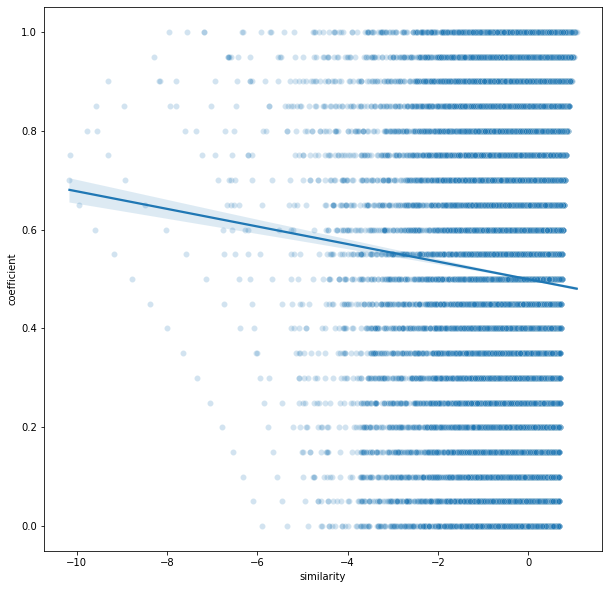

In [468]:
import seaborn as sns
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)

x = [i[1] for i in checking_corr_crop_hard]
y = [i[2] for i in checking_corr_crop_hard]

sns.scatterplot(x = x, y = y, alpha=0.2)
# sns.kdeplot(x = x, y = y, fill=True, common_norm=False, palette="crest", alpha=.2)
ax = sns.regplot(x = x, y = y, scatter=False)
ax.set(xlabel='similarity', ylabel='coefficient')

In [320]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
for l in range(1000):
#     if freqs[l] > 20:
#         continue
    for z in tqdm(range(50000)):
        if ls[z] == l:
            final_pred = []
            best_agreement = -np.inf
            default_pred = 0
            all_coef_preds = []
            all_coef_pred_probas = []
            all_agreements = []
            best_mixer = 0
            x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
            best_acc_temp = 0
            for ii in range(0, 21):
                i = ii/20.0
                mixed_clf.coef_ = i*conv_comb_0_8_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
                mixed_clf.intercept_ = i*conv_comb_0_8_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
                probas = mixed_clf.predict_proba(x)
                preds = mixed_clf.predict(x)
                all_coef_preds.append(preds)
                all_coef_pred_probas.append(probas)
                agreement = 0
                if i == 0.65:
                    default_pred = preds[0]

                agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
                mu, sig = cossim_jitter[ii]
                agreement1 = (agreement1- mu)/sig

                agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
                mu, sig = cossim_gray[ii]
                agreement2 = 0

                agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
                mu, sig = cossim_crop_easy[ii]
                agreement3 = (agreement3- mu)/sig
            
                agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
                mu, sig = cossim_crop_med[ii]
                agreement4 = 0
                
                agreement5 = 1 - spatial.distance.cosine(probas[5], probas[4])
                mu, sig = cossim_crop_hard[ii]
                agreement5 = 0


                agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
                all_agreements.append(agreement)
                if agreement > best_agreement and ii < 19 and ii>1:
                    final_pred = [ii]
                    best_agreement = agreement
                    best_mixer = i
                if preds[0] == ls[z]:
                    best_acc_temp = 1
            final_pred = all_coef_preds[final_pred[0]][0]
            best_acc[ls[z]] += best_acc_temp

            if final_pred == ls[z]:
                total_acc[ls[z]] +=1

            if default_pred == ls[z]:
                def_acc[ls[z]] +=1
    stats = np.array([50, best_acc[l], def_acc[l], total_acc[l]])
    print(l, freqs[l], stats)
    following += stats
    print(following)
    print(following*100/following[0])

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [273]:
l = 2
for z in tqdm(range(50000)):
    if ls[z] == l:
        print(z)

  0%|          | 0/50000 [00:00<?, ?it/s]

165
367
390
2511
2855
3682
3899
4510
7403
8948
9954
11091
11655
14516
15611
15616
17040
18128
18303
19117
20131
22112
24948
26328
26436
26568
26827
28427
30167
32229
33211
34537
36300
37299
37579
38827
39167
40895
40915
41211
41368
41612
42114
43594
44031
44648
45843
47129
47189
47448


In [440]:
z = 2122

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))


x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
og_probas = []
og_preds = []
for ii in range(0, 21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    probas = mixed_clf.predict_proba(x)
    preds = mixed_clf.predict(x)
    og_probas.append(probas[0])
    og_preds.append(preds[0])
    
og_probas = np.array(og_probas)
print(og_preds)
og_preds = np.unique(np.array(og_preds))

og_preds

[855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 855, 650, 650, 650, 650, 650, 650, 650, 650]


array([650, 855])

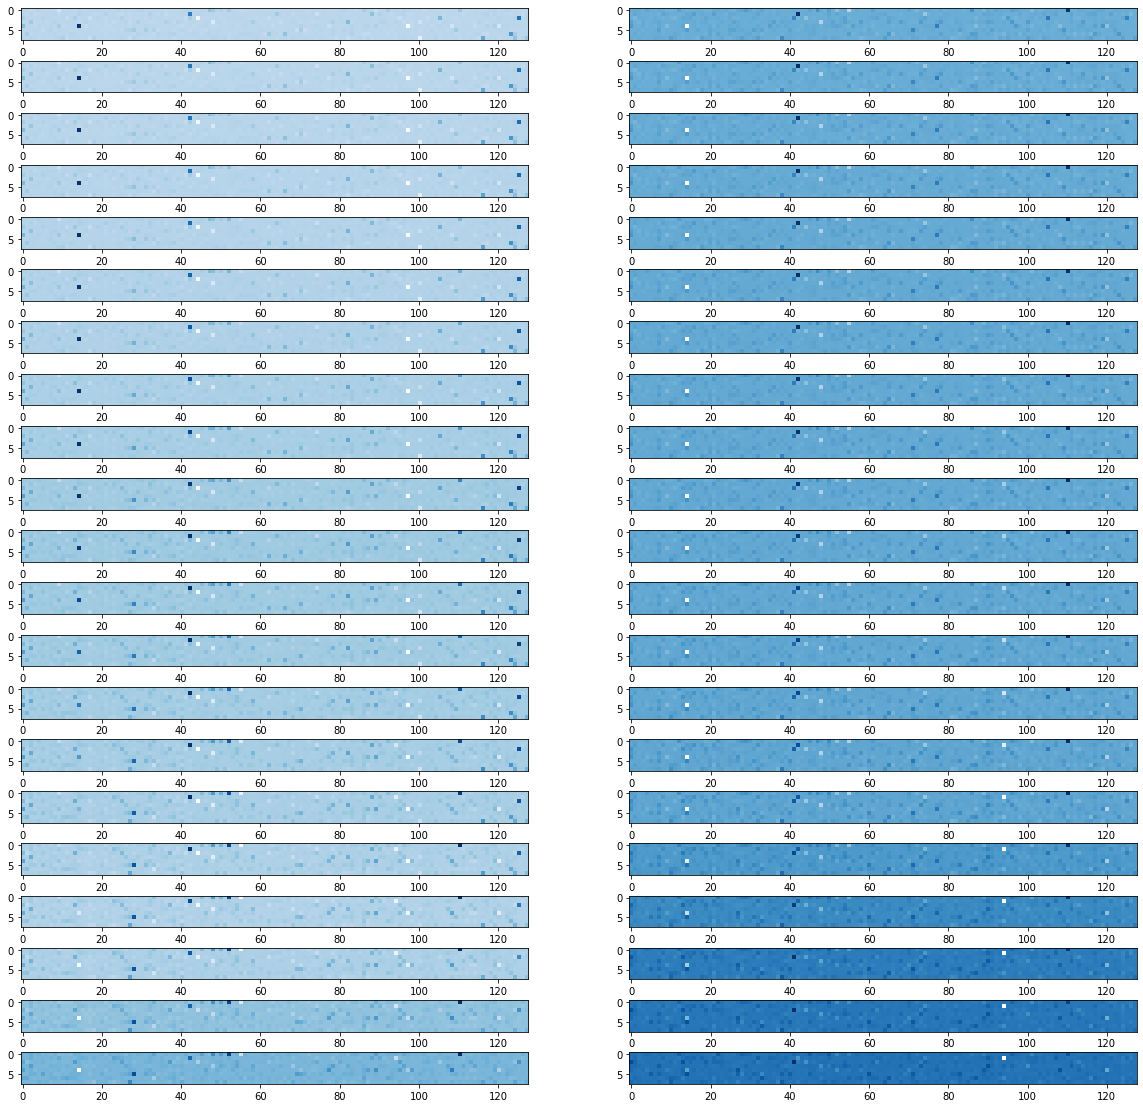

In [441]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (100,30)

fig, axs = plt.subplots(21, 2, figsize= (20,20))

for ii in range(21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    
    orig = np.array([mixed_clf.coef_[og_preds[0]] * all_og[z]])
    orig = (orig-np.mean(orig))/np.std(orig)
    to_plt = []
    for j in range(8):
        start = 128*j
        end = 128*(j+1)
        to_plt.append(orig[:,start:end])
    to_plt = np.vstack(to_plt)
    axs[ii][0].imshow(to_plt, cmap='Blues', interpolation='nearest')

#     mixed_clf.coef_ = j*text_only_balanced_clf.coef_ + (1-j)*image_only_clf_oversampled.coef_
    orig = np.array([mixed_clf.coef_[og_preds[1]] * all_og[z]])
    orig = (orig-np.mean(orig))/np.std(orig)
    to_plt = []
    for j in range(8):
        start = 128*j
        end = 128*(j+1)
        to_plt.append(orig[:,start:end])
    to_plt = np.vstack(to_plt)
    axs[ii][1].imshow(to_plt, cmap='Blues', interpolation='nearest')

plt.show()

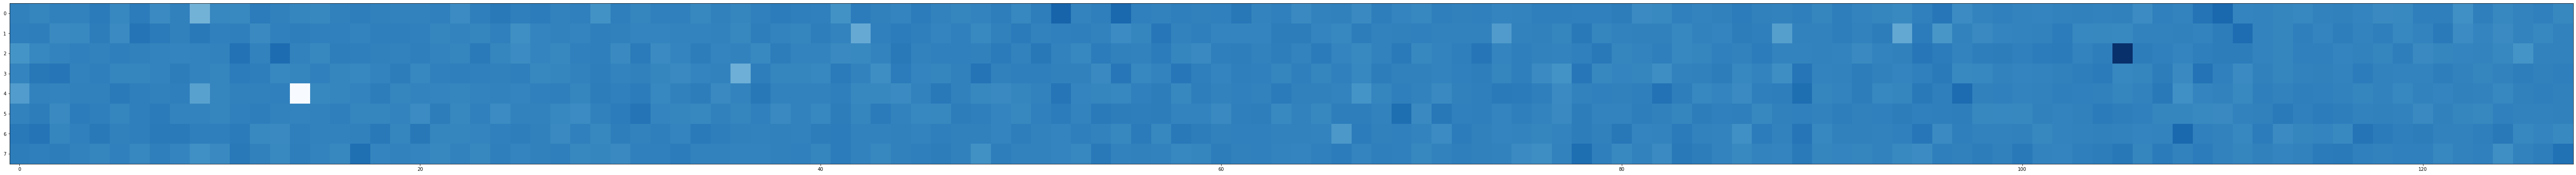

In [439]:
orig = np.array([all_og[z]])
orig = (orig-np.mean(orig))/np.std(orig)
to_plt = []
for j in range(8):
    start = 128*j
    end = 128*(j+1)
    to_plt.append(orig[:,start:end])
to_plt = np.vstack(to_plt)
plt.imshow(to_plt, cmap='Blues', interpolation='nearest')

In [433]:
for ii in range(21):
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    a = all_og[z]
    b = mixed_clf.coef_[og_preds[0]]
    print(1 - spatial.distance.cosine(a, b))

0.35950187812130885
0.35917293697043773
0.35856298988082447
0.3576083773943681
0.35623256991235186
0.35434405838109306
0.3518342256647746
0.34857543282884307
0.34441970397445654
0.3391985902692679
0.3327250253321179
0.3247982056105927
0.31521264579761044
0.3037724126165371
0.29031092599373687
0.274715462276796
0.25695361987014476
0.23709692582694042
0.21533536050193325
0.19197696282199206
0.16742950575302284


In [436]:
from scipy import spatial

l = 650

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = [0,0,0,0]
for z in tqdm(range(50000)):
    if ls[z] == l:
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([all_og[z], all_0[z], all_1[z], all_2[z], all_3[z], all_4[z]])
        best_acc_temp = 0
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]
                
            agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
            mu, sig = cossim_jitter[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
            mu, sig = cossim_gray[ii]
            agreement2 = (agreement2- mu)/sig
            
            agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
            mu, sig = cossim_crop_easy[ii]
            agreement3 = (agreement3- mu)/sig
            
            agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
            mu, sig = cossim_crop_hard[ii]
            agreement4 = (agreement4- mu)/sig
            
            
            agreement = agreement3 + agreement4
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == ls[z]:
                best_acc_temp = 1
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[ls[z]] += best_acc_temp

        print(default_pred, final_pred, best_agreement, best_mixer)
        print(z, CLASSES[default_pred], CLASSES[final_pred])
        if final_pred == ls[z]:
            total_acc[ls[z]] +=1
            if default_pred != ls[z]:
                print("*********")
                print(all_coef_preds)
                print(all_agreements)

        if default_pred == ls[z]:
            def_acc[ls[z]] +=1
            if final_pred != ls[z]:
                print("xxxxxxxx")
                print(all_coef_preds)
                print(all_agreements)
                
print(l, best_acc[l]*2, def_acc[l]*2, total_acc[l]*2)

# print(np.mean(best_acc), np.mean(def_acc), np.mean(total_acc))

  0%|          | 0/50000 [00:00<?, ?it/s]

613 613 -3.6908292575847086 0.7
995 joystick joystick
855 650 0.6504401396115733 0.9
1064 thimble microphone
*********
[array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([855, 855, 855, 855, 855, 855]), array([650, 855, 855, 650, 855, 650]), array([650, 855, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650])]
[-0.1417877450156978, -0.12228071708653752, -0.10145146084162

683 683 -1.3070733451873975 0.1
12770 oboe oboe
622 650 -0.49054687367374183 0.9
13231 lens cap microphone
*********
[array([872, 818, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([872, 855, 872, 855, 818, 745]), array([818, 855, 818, 855, 818, 745]), array([818, 855, 818, 855, 818, 745]), array([855, 855, 855, 855, 818, 745]), array([855, 855, 855, 855, 818, 745]), array([622, 855, 622, 650, 818, 745]), array([622, 650, 622, 650, 563, 745]), array([622, 650, 622, 650, 563, 745]), array([650, 650, 650, 650, 563, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650]), array([650, 650, 650, 650, 650, 650])]
[-0.7571272965217076, -0.7440353462674993, -0.7319365749649853,

593 593 0.9174650667446027 0.8
24738 harmonica harmonica
650 650 1.3990555950732588 0.9
25777 microphone microphone
596 596 -1.245254758686568 0.1
26769 hatchet hatchet
546 546 0.541032664894589 0.45
28534 electric guitar electric guitar
477 477 -1.432117537452565 0.7
29079 tool kit tool kit
610 16 -0.06668554933710391 0.9
30318 T-shirt bulbul
650 632 -2.678707033744166 0.1
33039 microphone music speaker
xxxxxxxx
[array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 818, 818, 818]), array([632, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 632, 650, 818, 818]), array([650, 650, 650, 650, 818, 818]), array([650, 650, 650, 650, 818, 818]), array([650, 650, 650, 650, 818, 650]), array([650, 650, 650, 650, 818, 650]), array([650, 650, 650, 650, 818, 650]

In [442]:
cossim_jitter_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_0])
    proba = mixed_clf.predict_proba(x)
    t1, t2 = proba[0:50000], proba[50000:]
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_jitter_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_gray_cc = []
all_cossims_text = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_2])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_gray_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_crop_easy_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_1])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_easy_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
    
cossim_crop_med_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_og, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_med_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()
    
cossim_crop_hard_cc = []
import sklearn
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
# inds = np.random.randint(0, 50000, size=2000)
for ii in range(0, 21):
    print(ii)
    i = ii/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
    x = np.vstack([all_4, all_3])
    proba = mixed_clf.predict_proba(x)
#     print(proba.shape)
    t1, t2 = proba[0:50000], proba[50000:]
#     print(t1.shape, t2.shape)
    A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
    cossim_crop_hard_cc.append([np.mean(A),np.std(A)])
    print([np.mean(A),np.std(A)])
    print()

0


KeyboardInterrupt: 

### Learning to predict based on augmentations similarities

In [22]:
def vis_enc(im):
    x = visual_model(im.half()).float()
    x = x / x.norm(dim=-1, keepdim=True)
    return x

In [23]:
# Find augmentations for which entropy of text and image classifiers are similar
import importlib
from data_loader import dataloaders as dataloader
importlib.reload(dataloader)
d = dataloader.load_data(
    data_root="./datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="test",
    batch_size=500,
    sampler_dic=None,
    num_workers=10,
    type="LT_Dataset_transform_mix",
    prompt_set="Imagenet",
#     override_transform = [T.RandomGrayscale(p=0.5)]
)

dataset_test = d[0]

val_og = []
val_0 = []
val_1 = []
val_2 = []
val_3 = []
val_4 = []
val_ls = []
for im_cj, im_hf, im_rc, im_gb, im_gs, im_og, label, _, _ in tqdm(dataset_test):
    with torch.no_grad():
        val_0.append(vis_enc(im_cj))
        val_1.append(vis_enc(im_hf))
        val_2.append(vis_enc(im_rc))
        val_3.append(vis_enc(im_gb))
        val_4.append(vis_enc(im_gs))
        val_og.append(vis_enc(im_og))
        val_ls.append(label)
        
val_0 = torch.cat(val_0,0).cpu().numpy()
val_1 = torch.cat(val_1,0).cpu().numpy()
val_2 = torch.cat(val_2,0).cpu().numpy()
val_3 = torch.cat(val_3,0).cpu().numpy()
val_4 = torch.cat(val_4,0).cpu().numpy()
val_og = torch.cat(val_og,0).cpu().numpy()
val_ls = torch.cat(val_ls,0).cpu().numpy()

print(val_ls.shape)

Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_test.txt
Use data transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
***********************DATASET: test LT_Dataset_transform_mix
test 50000
No sampler.
Shuffle is True.


  0%|          | 0/100 [00:00<?, ?it/s]

(50000,)


In [24]:
import sklearn
from scipy import spatial
def generate_cossim_matrix(og, c):
    cossim = []
    mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
    # inds = np.random.randint(0, 50000, size=2000)
    for ii in tqdm(range(0, 21)):
        i = ii/20.0
        mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
        mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
        x = np.vstack([og, c])
        proba = mixed_clf.predict_proba(x)
        n = og.shape[0]
        t1, t2 = proba[0:n], proba[n:]
        A = [1 - spatial.distance.cosine(a,b) for a,b in zip(t1, t2)]
        cossim.append([np.mean(A),np.std(A)])
    return cossim

cossim_jitter_val = generate_cossim_matrix(val_og, val_0)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/cossim_jitter.npz', arr1=cossim_jitter_val)
cossim_gray = generate_cossim_matrix(val_og, val_1)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/cossim_gray.npz', arr1=cossim_gray)
cossim_crop_easy = generate_cossim_matrix(val_og, val_2)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/cossim_crop_easy.npz', arr1=cossim_crop_easy)
cossim_crop_med = generate_cossim_matrix(val_og, val_3)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/cossim_crop_med.npz', arr1=cossim_crop_med)
cossim_crop_hard = generate_cossim_matrix(val_og, val_4)
np.savez('/nethome/bdevnani3/flash1/long_tail_lang/data/matrices/cossim_crop_hard.npz', arr1=cossim_crop_hard)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
from scipy import spatial

l = 337

mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
from scipy import stats

total_acc = np.zeros(1000)
best_acc = np.zeros(1000)
def_acc = np.zeros(1000)
following = np.array([0.,0.,0.,0.])
checking_corr_jitter = []
checking_corr_gray = []
checking_corr_crop_easy = []
checking_corr_crop_med = []
checking_corr_crop_hard = []
proba_set = []
# inds = np.random.randint(0, 50000, size=5000)
for l in range(1000):
#     if freqs[l] > 20:
#         continue
    l_count = 0
for z in tqdm(range(20000)):
        print(z)
        l = val_ls[z]
        final_pred = []
        best_agreement = -np.inf
        default_pred = 0
        all_coef_preds = []
        all_coef_pred_probas = []
        all_agreements = []
        best_mixer = 0
        x = np.vstack([val_og[z], val_0[z], val_1[z], val_2[z], val_3[z], val_4[z]])
        best_acc_temp = 0
        og_proba = []
        for ii in range(0, 21):
            i = ii/20.0
            mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf_oversampled.coef_
            mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf_oversampled.intercept_
            probas = mixed_clf.predict_proba(x)
            preds = mixed_clf.predict(x)
            all_coef_preds.append(preds)
            all_coef_pred_probas.append(probas)
            agreement = 0
            if i == 0.65:
                default_pred = preds[0]

            agreement1 = 1 - spatial.distance.cosine(probas[0], probas[1])
            mu, sig = cossim_jitter_val[ii]
            agreement1 = (agreement1- mu)/sig

            agreement2 = 1 - spatial.distance.cosine(probas[0], probas[3])
            mu, sig = cossim_gray_val[ii]
            agreement2 = (agreement2- mu)/sig

            agreement3 = 1 - spatial.distance.cosine(probas[0], probas[2])
            mu, sig = cossim_crop_val[ii]
            agreement3 = (agreement3- mu)/sig

            agreement4 = 1 - spatial.distance.cosine(probas[0], probas[4])
            mu, sig = cossim_crop_val[ii]
            agreement4 = (agreement4- mu)/sig

            agreement5 = 1 - spatial.distance.cosine(probas[5], probas[4])
            mu, sig = cossim_crop_val[ii]
            agreement5 = (agreement5- mu)/sig

            agreement = agreement1+ agreement2+agreement3+agreement4+agreement5
            all_agreements.append(agreement)
            if agreement > best_agreement and ii < 19 and ii>1:
                final_pred = [ii]
                best_agreement = agreement
                best_mixer = i
            if preds[0] == val_ls[z]:
                best_acc_temp = 1
                checking_corr_jitter.append([z, agreement1, ii])
                checking_corr_gray.append([z, agreement2, ii])
                checking_corr_crop_easy.append([z, agreement3, ii])
                checking_corr_crop_med.append([z, agreement4, ii])
                checking_corr_crop_hard.append([z, agreement5, ii])
                proba_set.append([z, probas[1], probas[2], ii])
        final_pred = all_coef_preds[final_pred[0]][0]
        best_acc[val_ls[z]] += best_acc_temp

        if final_pred == val_ls[z]:
            total_acc[val_ls[z]] +=1

        if default_pred == val_ls[z]:
            def_acc[val_ls[z]] +=1
    stats = np.array([l_count, best_acc[l], def_acc[l], total_acc[l]])
    print(l, freqs[l], stats)
# following += stats
# print(following)
# print(following*100/following[0])

  0%|          | 0/20000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981


8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621


In [ ]:
input_features_train = 
corr_coefs_train = 

input_features_val = 
corr_coefs_val = 

In [ ]:
import torch
import torch.nn as nn
import copy
from sklearn.metrics import top_k_accuracy_score

class LogReg(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(input_dim, input_dim)
#         self.bn = nn.LayerNorm(100)
#         self.do = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(input_dim, output_dim)
        self.m = nn.Sigmoid()
        self.m = nn.ReLU()
        self.mse = nn.MSELoss()

    def forward(self, x):
        x = self.linear(x)
#         x = self.bn(x)
#         x = self.do(x)
        x = self.linear2(x)
        return x

loss_fn = nn.CrossEntropyLoss()

epochs = 5000
model = LogReg(5, 21)
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= epochs)
# best_model = model
best_acc = 0

for epoch in range(epochs):
    
    model.train()
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(input_features_train).float().requires_grad_()
    targets = torch.from_numpy(corr_coefs_train)
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 
    
    # Forward to get output
    outputs = model(inputs)
    
#     print(targets.shape, outputs.shape)
    # Calculate Loss
    loss = loss_fn(outputs, targets)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    sched.step()
    
    if epoch%10 == 0:
        with torch.no_grad():
            model.eval()
            tr_coef_preds = np.argmax(outputs, axis=-1)
            tr_acc = torch.sum(tr_coef_preds == targets)/len(targets)
            
            val_coef_preds = model(torch.from_numpy(input_features_val).float())
            val_coef_preds = np.argmax(val_coef_preds, axis=-1)

            val_acc = torch.sum(val_coef_preds == torch.from_numpy(corr_coefs_val))/len(val_coef_preds)

            test_coef_preds_log = model(torch.from_numpy(input_features_test).float())
            test_coef_preds = np.argmax(test_coef_preds_log, axis=-1)
            test_acc = torch.sum(test_coef_preds == torch.from_numpy(corr_coefs_test))/len(test_coef_preds)
            test_acc_2 = top_k_accuracy_score(torch.from_numpy(corr_coefs_test), test_coef_preds_log.numpy(),k=2)
            

            if val_acc >= best_acc:
                print("Updating best model")
                best_acc = val_acc
                best_model = copy.deepcopy(model)
        
            print(f'epoch {epoch}, loss {loss.item():.5f}, training_acc {tr_acc.item():5f} ,val_acc {val_acc:.5f} ,test_acc {test_acc:.5f},test_acc2 {test_acc_2:.5f}')
        